### Análisis Inicial

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

df = pd.read_csv('../../data/Brujo/BaseCompletaBrujo.csv')
df.set_index('fecha', inplace=True)

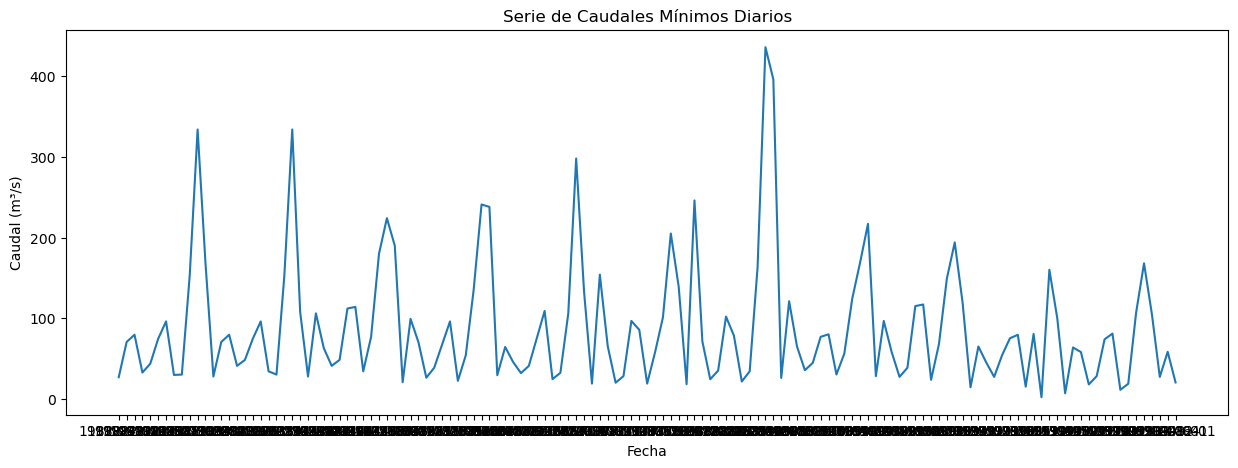

In [2]:
plt.figure(figsize=(15,5))
plt.plot(df['caudal_minimo'], label='Caudal')
plt.title('Serie de Caudales Mínimos Diarios')
plt.xlabel('Fecha')
plt.ylabel('Caudal (m³/s)')
plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from typing import List, Tuple, Optional, Dict
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import argparse
import json
import time
import os
from datetime import datetime

In [4]:
class EVL(nn.Module):
    """
    Pérdida EVT para **mínimos extremos**.

    Esta clase implementa un término de pérdida inspirado en Extreme Value Theory (EVT)
    para priorizar eventos raros de *mínimos* en series temporales. Se usa junto con
    una pérdida de regresión (MSE) y, opcionalmente, con un término de memoria.

    Parameters
    ----------
    gamma : float, default=1
        Exponente que controla el peso relativo de las partes (u/gamma)^gamma
        y (1 - u/gamma)^gamma. Debe ser > 0. Valores mayores endurecen el
        decaimiento, valores cercanos a 1 son más suaves.

    Atributos
    ---------
    gamma : float
        Copia del hiperparámetro usada internamente por la fórmula EVT.
    """

    def __init__(self, gamma: float = 1.0) -> None:
        super().__init__()
        self.gamma = gamma

    def evl_perdida_minimos(
        self,
        u: torch.Tensor,
        v: torch.Tensor,
        p_minimo: float
    ) -> torch.Tensor:
        """
        Calcula la pérdida EVT para **mínimos extremos** (forma estable numéricamente).

        Fórmula (por elemento)
        ----------------------
        L = - β_min * (u/γ)^γ * v * log(u)  -  β_norm * (1 - u/γ)^γ * (1 - v) * log(1 - u)

        donde `u` es probabilidad en (0,1), `v`∈{0,1} indica mínimo (1=min), `β_min = p_minimo`,
        `β_norm = 1 - p_minimo`, y `γ = gamma`.

        Parameters
        ----------
        u : torch.Tensor
            Probabilidades en (0, 1). Si llega fuera de rango/NaN/Inf, se estabiliza internamente.
            Shape: arbitraria y broadcastable con `v`.
        v : torch.Tensor
            Etiquetas binarias {0,1} donde 1 indica mínimo extremo. Si llegara en convención {-1,0},
            se mapea a {1,0} internamente. Shape: broadcastable con `u`.
        p_minimo : float
            Proporción esperada (0,1) de mínimos extremos (ajusta β). Si llega fuera de (0,1),
            se recorta a (eps, 1-eps).

        Returns
        -------
        torch.Tensor
            Tensor de pérdidas **por elemento** (no reducido). Reduce fuera con `.mean()` o `.sum()`.

        NOTAS IMPORTANTES
        -----------------
        - `torch.nan_to_num(u, ...)`: reemplaza NaN/±Inf por valores finitos (seguro para logs).
        - `u = u.clamp(eps, 1-eps)`: evita `log(0)` y `log(1-0)`, que producirían `-inf`.
        - `torch.log1p(-u)`: es `log(1-u)` pero más precisa y estable cerca de 0.
        - `base_min = clamp(u/gamma, eps, 1)`: asegura base positiva en `pow`; evita bases ≤0.
        - `torch.pow(base, gamma)`: si `gamma` no es entero, la base debe ser > 0 (de ahí el clamp).
        - El resultado **no** está reducido: decide tú si usar `.mean()` (típico) o `.sum()`.
        """
        eps = 1e-6

        # v a {0,1} (si viene como {-1,0}, se transforma a {1,0})
        v = v.float()
        if v.min() < 0 or v.max() > 1:
            v = (v == -1).float()

        # β en (0,1) y γ > 0 (recorte estable)
        beta_minimo = float(p_minimo)
        beta_minimo = max(min(beta_minimo, 1.0 - eps), eps)
        beta_normal = 1.0 - beta_minimo

        gamma = float(getattr(self, "gamma", 1.0))
        gamma = max(gamma, eps)

        # u estable en (0,1)
        u = torch.nan_to_num(u, nan=0.5, posinf=1.0, neginf=0.0)
        u = torch.clamp(u, eps, 1.0 - eps)

        # bases para potencias en (0,1] (evita negativos/cero)
        base_min = torch.clamp(u / gamma, eps, 1.0)         # (u/γ)^γ
        base_norm = torch.clamp(1.0 - (u / gamma), eps, 1.0) # (1 - u/γ)^γ

        # pesos
        pesos_minimos = beta_minimo * torch.pow(base_min, gamma)
        pesos_normal  = beta_normal  * torch.pow(base_norm, gamma)

        # términos log-estables
        log_u = torch.log(u)
        log_1mu = torch.log1p(-u)  # == log(1-u) con mejor estabilidad

        termino_minimo = -pesos_minimos * v        * log_u
        termino_normal = -pesos_normal  * (1.0 - v) * log_1mu

        loss_elem = termino_minimo + termino_normal
        loss_elem = torch.nan_to_num(loss_elem, nan=0.0, posinf=1e6, neginf=1e6)
        return loss_elem  # ← reducir fuera (p. ej., .mean())

    def forward(self, ut: torch.Tensor, vt: torch.Tensor, p_minimo: float) -> torch.Tensor:
        """
        Interfaz de compatibilidad: convierte `vt` a {0,1} y usa `-ut` como probabilidad de mínimo.

        Esto permite llamar a `EVL` como un módulo estándar (`loss = evl(ut, vt, p)`),
        asumiendo que `ut` es un *score* donde **más negativo ⇒ más extremo**.
        Se invierte el signo y se delega a `evl_perdida_minimos`.

        Parameters
        ----------
        ut : torch.Tensor
            Puntajes de extremidad (más negativo ⇒ más extremo). Shape broadcastable con `vt`.
        vt : torch.Tensor
            Etiquetas en {-1,0} o {0,1}. Si es {-1,0}, se mapea a {1,0}.
        p_minimo : float
            Proporción (0,1) de mínimos extremos.

        Returns
        -------
        torch.Tensor
            Pérdida por elemento (no reducida).

        NOTAS IMPORTANTES
        -----------------
        - Mapeo de etiquetas: `vt_minimo = (vt == -1).float()` produce {0,1}.
        - Inversión de signo: como `ut` más negativo es más extremo, `-ut` crece con la probabilidad
          de “ser mínimo”. Si `ut` ya es probabilidad en [0,1], preferir llamar directamente a
          `evl_perdida_minimos(ut, vt_minimo, p_minimo)` sin invertir.
        - Esta función **no reduce** la pérdida: reduce fuera con `.mean()` o `.sum()`.
        """
        vt_minimo = (vt == -1).float()
        return self.evl_perdida_minimos(-ut, vt_minimo, p_minimo)


In [5]:
class GRU_EVT(nn.Module):
    """
    GRU con memoria atencional y pérdida EVT para detección de mínimos extremos.

    El modelo predice el próximo valor de la serie y, simultáneamente, aprende
    a resaltar eventos raros de tipo **mínimo** usando:
      (1) una GRU como backbone,
      (2) un banco de memoria con embeddings de ventanas pasadas,
      (3) un score `ut` derivado de atención sobre la memoria,
      (4) una pérdida EVT (mínimos) además del MSE.

    Parameters
    ----------
    size_input : int
        Dimensión de entrada por paso temporal (número de features, F).
    size_oculto : int
        Dimensión del estado oculto de la GRU (H).
    size_memoria : int
        Capacidad del banco de memoria (M), número de embeddings almacenados.
    size_ventana : int
        Longitud de ventana W usada para codificar ventanas al banco de memoria.
    size_salida : int, default=1
        Dimensión de la salida por paso (normalmente 1 para series univariadas).
    gamma : float, default=1
        Hiperparámetro pasado a la pérdida EVT (exponente en la fórmula).
    labda : float, default=1
        Peso λ del término EVT de secuencia (L1) dentro de la pérdida total.
    lr : float, default=1e-4
        Tasa de aprendizaje prevista (el optimizador vive fuera de esta clase).

    Atributos
    ---------
    gru : nn.GRU
        GRU con `batch_first=True` ⇒ salidas `[B, T, H]` y oculto `[1, B, H]`.
    capa_salida : nn.Linear
        Proyección de `H → size_salida` para la predicción base (`pred_normal`).
    extreme_predictor : nn.Sequential
        MLP pequeño para estimar (logit/prob) de extremo a partir de embeddings `[H]`.
    b : nn.Parameter
        Parámetro escalar que modula la contribución de `ut` a la predicción final.
    embedding_modulo : Optional[torch.Tensor]
        Banco de memoria `S ∈ R^{M×H}` (embeddings de ventanas).
    historia_modulo : Optional[torch.Tensor]
        Etiquetas de memoria `Q ∈ {-1,0,1}^M` (se usa {−1,0} en este setup).
    evl_perdida : EVL
        Módulo con la pérdida EVT para mínimos extremos.
    umbral_ut : float
        Umbral fraccional para decidir extremos (UT ≤ −umbral). Puede calibrarse.
    lambda1 : float
        Peso de la pérdida EVT de secuencia.
    """

    def __init__(
        self,
        size_input: int,
        size_oculto: int,
        size_memoria: int,
        size_ventana: int,
        size_salida: int = 1,
        gamma: float = 1,
        labda: float = 1,
        lr: float = 0.0001,
    ) -> None:
        super(GRU_EVT, self).__init__()

        self.size_oculto = size_oculto
        self.size_memoria = size_memoria
        self.size_ventana = size_ventana
        self.gamma = gamma
        self.lambda1 = labda
        self.taza_aprendizaje = lr
        self.umbral_ut = 0.1

        # Backbone
        self.gru = nn.GRU(size_input, size_oculto, batch_first=True)

        # Salidas
        self.capa_salida = nn.Linear(size_oculto, size_salida)
        self.extreme_predictor = nn.Sequential(
            nn.Linear(size_oculto, size_oculto // 2),
            nn.ReLU(),
            nn.Linear(size_oculto // 2, 1),
            nn.Tanh()  # salida en (−1,1)
        )

        # Parámetro escalar (paper)
        self.b = nn.Parameter(torch.tensor(1.0, requires_grad=True))

        # Memoria
        self.embedding_modulo = None  # S ∈ R^{M×H}
        self.historia_modulo = None   # Q ∈ {-1,0,1}^M

        # EVT
        self.evl_perdida = EVL(gamma=gamma)

        # Stats (opcionales)
        self.p_derecha = 0
        self.p_izq = 0

    def inicializar_memoria(self, device: torch.device) -> None:
        """
        Inicializa los tensores del banco de memoria en el `device` indicado.

        Parameters
        ----------
        device : torch.device
            Dispositivo de destino (CPU o CUDA) para S y Q.

        NOTAS IMPORTANTES
        -----------------
        - `torch.zeros(..., device=device)`: crea el tensor directamente en el dispositivo.
        - Shapes:
            * `embedding_modulo` S: `[M, H]`
            * `historia_modulo`   Q: `[M]` con ints en {−1,0,1}
        """
        self.embedding_modulo = torch.zeros(self.size_memoria, self.size_oculto, device=device)
        self.historia_modulo = torch.zeros(self.size_memoria, dtype=torch.long, device=device)

    def actualizar_proporciones(self, vt_batch: torch.Tensor) -> None:
        """
        Actualiza la proporción de mínimos (`p_minimo`) a partir de un batch de etiquetas.

        Parameters
        ----------
        vt_batch : torch.Tensor
            Etiquetas por paso temporal, típicamente `{−1, 0}`. Shape: `[B, T]` o `[T]`.

        NOTAS IMPORTANTES
        -----------------
        - Se usa `vt_batch.cpu().numpy()` para computar proporciones con NumPy.
        - `p_minimo` se guarda como fracción en (0,1) y la consumen las pérdidas EVT.
        """
        vt_np = vt_batch.cpu().numpy()
        total = len(vt_np)
        self.p_minimo = np.sum(vt_np == -1) / total  # Solo mínimos

    def predecir_extremo_ventana(self, sj: torch.Tensor) -> torch.Tensor:
        """
        Estima (logit/prob) de extremo desde un embedding o lote de embeddings.

        Parameters
        ----------
        sj : torch.Tensor
            Embedding(s) de memoria. Shape `[M, H]` o `[H]`.

        Returns
        -------
        torch.Tensor
            Salida escalar por embedding (después de `squeeze`): `[M]` o `[]`.

        NOTAS IMPORTANTES
        -----------------
        - `Sequential` aplica capas a la **última dimensión** H.
        - `squeeze()` elimina dimensiones de tamaño 1 (la final aquí), dejando `[M]`.
        """
        return self.extreme_predictor(sj).squeeze()

    def computar_perdidas(
        self,
        prediccion: torch.Tensor,
        targets: torch.Tensor,
        ut_valores: torch.Tensor,
        vt_valores: torch.Tensor
    ) -> Dict[str, torch.Tensor]:
        """
        Compone la pérdida total: `MSE + lambda1 * EVT(secuencia) + EVT(memoria)`.

        Parameters
        ----------
        prediccion : torch.Tensor
            Predicción final apilada en el tiempo. Shape `[B, T, 1]`.
        targets : torch.Tensor
            Valores reales alineados con `prediccion`. Shape `[B, T, 1]`.
        ut_valores : torch.Tensor
            Score de extremidad por paso (más negativo ⇒ más extremo). Shape `[B, T]`.
        vt_valores : torch.Tensor
            Etiquetas por paso `{−1,0}`. Shape `[B, T]`.

        Returns
        -------
        dict
            Diccionario con `perdida_total`, `L1`, `L2`, `mse_perdida`, `evl_perdida_ut`.

        NOTAS IMPORTANTES
        -----------------
        - **Sanitización**: `torch.nan_to_num` evita NaN/Inf que romperían MSE o logs.
        - **u_prob**: si `ut` no está en [0,1], se mapea con `sigmoid(-ut/τ)` (más negativo → prob más alta).
        - **Clamp**: `clamp(eps, 1-eps)` previene `log(0)` en la pérdida EVT.
        - **Memoria (L2)**:
            * `predecir_extremo_ventana(S)` produce `[M]`; si es logit, se pasa por `sigmoid`.
            * `historia_modulo == -1` → target binario `[M]` en {0,1}.
            * Reduce con `.mean()` tras sanitizar.
        """
        import torch.nn.functional as F
        eps = 1e-6

        # Sanitizar entradas
        prediccion = torch.nan_to_num(prediccion, nan=0.0, posinf=1e6, neginf=-1e6)
        targets    = torch.nan_to_num(targets,    nan=0.0, posinf=1e6, neginf=-1e6)
        ut_valores = torch.nan_to_num(ut_valores, nan=0.0, posinf=1e6, neginf=-1e6)
        vt_valores = torch.nan_to_num(vt_valores, nan=0.0, posinf=1e6, neginf=-1e6)

        # MSE
        mse_loss = F.mse_loss(prediccion, targets)

        # EVT sobre secuencia (L1)
        v_bin = (vt_valores == -1).float()
        tau = 2  # suavizado de sigmoide
        u_prob = ut_valores
        if (u_prob.min() < 0) or (u_prob.max() > 1):
            u_prob = torch.sigmoid(-u_prob / tau)  # más negativo → prob(mínimo) ↑
        u_prob = u_prob.clamp(eps, 1 - eps)

        evl_loss_ut = self.evl_perdida.evl_perdida_minimos(u_prob, v_bin, self.p_minimo).mean()
        L1 = mse_loss + self.lambda1 * evl_loss_ut

        # EVT sobre memoria (L2)
        if (getattr(self, "embedding_modulo", None) is not None) and (getattr(self, "historia_modulo", None) is not None):
            pj_predicciones = self.predecir_extremo_ventana(self.embedding_modulo)  # [M]
            if (pj_predicciones.min() < 0) or (pj_predicciones.max() > 1):
                pj_predicciones = torch.sigmoid(pj_predicciones)
            pj_predicciones = pj_predicciones.clamp(eps, 1.0 - eps)

            qj_target = (self.historia_modulo == -1).float()  # [M]
            evl_L2 = self.evl_perdida.evl_perdida_minimos(pj_predicciones, qj_target, self.p_minimo)
            L2 = torch.nan_to_num(evl_L2, nan=0.0, posinf=1e6, neginf=-1e6).mean()
        else:
            L2 = prediccion.new_tensor(0.0)

        perdida_total = torch.nan_to_num(L1 + L2, nan=0.0, posinf=1e6, neginf=-1e6)

        return {
            'perdida_total': perdida_total,
            'L1': L1,
            'L2': L2,
            'mse_perdida': mse_loss,
            'evl_perdida_ut': evl_loss_ut
        }

    def forward(
        self,
        x: torch.Tensor,
        tiempo_actual: int,
        return_components: bool = False
    ) -> torch.Tensor | Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Computa la predicción en el paso `t` usando GRU + memoria atencional.

        Parameters
        ----------
        x : torch.Tensor
            Entrada acumulada hasta `t`. Shape `[B, t+1, F]` (por `batch_first=True`).
        tiempo_actual : int
            Índice temporal (0..T−1) correspondiente a `x[:, :t+1]`.
        return_components : bool, default=False
            Si True, devuelve `(pred_final, pred_normal, ut)`.

        Returns
        -------
        torch.Tensor | tuple
            Si False: `pred_final` `[B, 1]`.
            Si True : `(pred_final [B,1], pred_normal [B,1], ut [B])`.

        NOTAS IMPORTANTES
        -----------------
        - `gru(x)` → `gru_out [B, t+1, H]`, `oculto [1, B, H]` (último estado).
        - `oculto.squeeze(0)` → `[B, H]`: elimina el eje de capas (num_layers=1).
        - `pred_normal = capa_salida([B, H])` → `[B, 1]`: proyección lineal.
        - **Atención con memoria**:
            * Banco S `[M, H]`; similitud: `ultimo_oculto @ S.t()`:
              `[B, H] @ [H, M] = [B, M]`.
            * `softmax(dim=1)` normaliza por memoria (cada fila suma 1).
            * `historia_modulo` se pasa a **one-hot** `[M,3]` con índices `{−1,0,1}→{0,1,2}`.
            * Mezcla: `[B,M] @ [M,3] = [B,3]`; `ut = P(+1) − P(−1)` → `[B]`.
        - **Broadcasting**: `ut.unsqueeze(1)` → `[B,1]` para sumarlo a `pred_normal`.
        - `nan_to_num` protege contra NaN/Inf antes de salir.
        """
        batch_size, sucesion_len, _ = x.shape

        # GRU
        gru_out, oculto = self.gru(x)           # oculto: [1, B, H]
        ultimo_oculto = oculto.squeeze(0)       # [B, H]

        # Predicción base
        pred_normal = self.capa_salida(ultimo_oculto)  # [B, 1]

        # Atención de memoria → score ut
        ut = torch.zeros(batch_size, device=x.device)

        if (hasattr(self, 'embedding_modulo') and self.embedding_modulo is not None and
            hasattr(self, 'historia_modulo') and self.historia_modulo is not None):

            # Scores de atención: [B, H] @ [H, M] = [B, M]
            score_atencion = ultimo_oculto @ self.embedding_modulo.t()

            # Pesos de atención por memoria
            pesos_atencion = torch.softmax(score_atencion, dim=1)  # softmax por fila
            pesos_atencion = torch.nan_to_num(pesos_atencion, nan=0.0)

            # One-hot de historial Q (desplazado +1): [M,3]
            historia_one_hot = torch.zeros(self.size_memoria, 3, device=x.device)
            historia_one_hot[torch.arange(self.size_memoria), self.historia_modulo.long() + 1] = 1

            # Mezcla: [B,M] @ [M,3] = [B,3]
            contribucion_memoria = torch.matmul(pesos_atencion, historia_one_hot)  # [B,3]

            # ut = P(+1) − P(−1)  (índices 2 y 0 tras desplazar +1)
            ut = contribucion_memoria[:, 2] - contribucion_memoria[:, 0]          # [B]

        # Predicción final  (suma ponderada por 'b')
        pred_final = pred_normal + self.b * ut.unsqueeze(1)  # [B,1]
        ut = torch.nan_to_num(ut, nan=0.0, posinf=1e6, neginf=-1e6)

        if return_components:
            return pred_final, pred_normal, ut
        return pred_final

    def get_label(self, sucesion: torch.Tensor, time_step: int) -> int:
        """
        Heurística simple para etiquetar **mínimos** (−1) mirando el siguiente paso.

        Parameters
        ----------
        sucesion : torch.Tensor
            Secuencia parcial de la serie. Shape `[T]` o `[T, F]` (se toma la columna objetivo).
        time_step : int
            Índice actual (se usa hasta `time_step` para etiquetar `time_step+1`).

        Returns
        -------
        int
            `-1` si el siguiente paso cae por debajo del umbral (mínimo); `0` en caso contrario.

        NOTAS IMPORTANTES
        -----------------
        - Umbral: `valor_actual − 2 * std(sucesion[:t])`. Es una heurística (ajústala a tu dominio).
        - Si `time_step + 1` excede la longitud, devuelve `0` (no hay siguiente).
        """
        if time_step + 1 >= len(sucesion):
            return 0

        valor_actual = sucesion[time_step]
        valor_sig = sucesion[time_step + 1]

        umbral_abajo = valor_actual - 2 * torch.std(sucesion[:time_step])
        return -1 if valor_sig < umbral_abajo else 0

    def sample_historia(
        self,
        tiempo_actual: int,
        sucesion: torch.Tensor,
        vt_sucesion: torch.Tensor
    ) -> Tuple[List[torch.Tensor], List[int]]:
        """
        Muestrea ventanas para el banco de memoria priorizando pasos extremos.

        Parameters
        ----------
        tiempo_actual : int
            Paso temporal actual; se consideran finales de ventana `< tiempo_actual`.
        sucesion : torch.Tensor
            Secuencia de **una** muestra (usualmente `[T, F]`).
        vt_sucesion : torch.Tensor
            Etiquetas `[T]` con {−1,0}.

        Returns
        -------
        ventanas : list of torch.Tensor
            Lista de ventanas `[1, W, F]` (se añade `unsqueeze(0)` como eje batch).
        labels : list of int
            Etiquetas por ventana en {−1,0} para la posición `final`.

        NOTAS IMPORTANTES
        -----------------
        - **Device**: se fuerzan todos los índices/tensores a estar en el **mismo device**.
        - Índices válidos: `range(W, t−1)`. Cada índice es el **final** de una ventana `[i−W:i]`.
        - Priorización: se toman **todos** los extremos disponibles y se completa con normales hasta `k`.
        - `unsqueeze(0)`: ventana `[W,F]` → `[1,W,F]`, listo para pasar por la GRU.
        """
        ventanas, labels = [], []

        if tiempo_actual <= self.size_ventana + 1:
            return [], []

        device = vt_sucesion.device
        if sucesion.device != device:
            sucesion = sucesion.to(device)

        indices = torch.arange(self.size_ventana, tiempo_actual - 1, device=device)
        if indices.numel() == 0:
            return [], []

        vt_seg = vt_sucesion[self.size_ventana:tiempo_actual - 1].to(device)
        ext_mask = (vt_seg == -1)
        if ext_mask.device != indices.device:
            ext_mask = ext_mask.to(indices.device)

        ext_indices  = indices[ext_mask]
        norm_indices = indices[~ext_mask]

        k = min(getattr(self, "size_memoria", self.size_ventana), indices.numel())

        sel_ext = ext_indices
        faltan = k - sel_ext.numel()
        if faltan > 0:
            if norm_indices.numel() >= faltan:
                perm = torch.randperm(norm_indices.numel(), device=device)[:faltan]
                sel_norm = norm_indices[perm]
            else:
                if norm_indices.numel() > 0:
                    rnd = torch.randint(0, norm_indices.numel(), (faltan,), device=device)
                    sel_norm = norm_indices[rnd]
                else:
                    sel_norm = torch.empty(0, dtype=indices.dtype, device=device)
            sample_id = torch.cat([sel_ext, sel_norm], dim=0)
        else:
            perm = torch.randperm(sel_ext.numel(), device=device)[:k]
            sample_id = sel_ext[perm]

        for idx in sample_id.tolist():
            inicio, final = idx - self.size_ventana, idx
            ventana = sucesion[inicio:final]          # [W, F]
            etiqueta = int(vt_sucesion[final].item()) # etiqueta para ese final
            etiqueta = -1 if etiqueta == -1 else 0
            ventanas.append(ventana.unsqueeze(0))     # [1, W, F]
            labels.append(etiqueta)

        return ventanas, labels

    def actualizar_memoria(self, ventanas: List[torch.Tensor], labels: List[int]) -> None:
        """
        Actualiza el banco de memoria con nuevos embeddings y sus etiquetas.

        Parameters
        ----------
        ventanas : list of torch.Tensor
            Ventanas `[1, W, F]` listas para codificar con la GRU.
        labels : list of int
            Etiquetas por ventana {−1,0}.

        NOTAS IMPORTANTES
        -----------------
        - Codificación: `gru(ventana)` devuelve `oculto [1,1,H]`. Con `squeeze(0).squeeze(0)` queda `[H]`.
        - Apilado: `stack([...], dim=0)` produce `[M, H]` listo para concatenar al banco.
        - Desplazamiento circular: `cat([S[new:], new_embeddings], dim=0)` mantiene tamaño `M`.
        - Las etiquetas se concatenan en `historia_modulo` de forma paralela.
        """
        if len(ventanas) == 0:
            return

        with torch.no_grad():
            embeddings = []
            for ventana in ventanas:
                _, oculto = self.gru(ventana)          # oculto: [1,1,H]
                emb = oculto.squeeze(0).squeeze(0)     # [H]
                embeddings.append(emb)
            embeddings = torch.stack(embeddings, dim=0)  # [M, H]

        size_memoria_nueva = embeddings.size(0)

        if self.embedding_modulo is None:
            self.inicializar_memoria(embeddings.device)

        # Desplaza y concatena (mantiene tamaño M)
        self.embedding_modulo = torch.cat([
            self.embedding_modulo[size_memoria_nueva:],  # “antiguas” que sobreviven
            embeddings                                   # nuevas al final
        ], dim=0)

        labels_tensor = torch.tensor(labels, dtype=torch.long, device=self.historia_modulo.device)
        self.historia_modulo = torch.cat([
            self.historia_modulo[size_memoria_nueva:],
            labels_tensor
        ], dim=0)


In [26]:
class EntrenamientoEVT(nn.Module):
    """
    Orquestador de entrenamiento/validación para `GRU_EVT` con pérdida EVT.

    Esta clase envuelve al modelo `GRU_EVT` y maneja:
    - el loop de entrenamiento por épocas,
    - la evaluación en validación,
    - la calibración del umbral de UT para clasificación de extremos,
    - el registro de pérdidas (train/val) y early stopping.

    Parameters
    ----------
    size_input : int
        Número de features por paso temporal (F) que entran a la GRU.
    size_oculto : int
        Tamaño del estado oculto de la GRU (H).
    size_memoria : int
        Capacidad del banco de memoria (M) usado por el modelo.
    size_ventana : int
        Longitud de ventana W para construir embeddings de memoria.
    tasa_aprendizaje : float, default=0.001
        Learning rate para el optimizador Adam.
    gamma : float, default=1
        Hiperparámetro que se pasa a la pérdida EVT (exponente).
    labda1 : float, default=1
        Peso λ de la pérdida EVT de secuencia (L1) dentro de la pérdida total.

    Atributos
    ---------
    device : torch.device
        `cuda` si está disponible, de lo contrario `cpu`.
    model : GRU_EVT
        Modelo principal (GRU+Memoria+EVT).
    optimizador : torch.optim.Optimizer
        Optimizador Adam sobre los parámetros del modelo.
    lambda1 : float
        Peso del término EVT en la pérdida L1.
    loss_history : dict
        Registro de pérdidas con claves `train` y `val`.
    last_val_f1 : float
        Último F1 de extremos medido en validación (para logging).
    """

    def __init__(self, size_input, size_oculto, size_memoria, size_ventana,
                 tasa_aprendizaje=0.001, gamma=1, labda1=1):
        super(EntrenamientoEVT, self).__init__()
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = GRU_EVT(
            size_input=size_input,
            size_oculto=size_oculto,
            size_memoria=size_memoria,
            size_ventana=size_ventana,
            gamma=gamma,
            labda=labda1,
            lr = tasa_aprendizaje
        ).to(self.device)

        try:
            self.model.gru.flatten_parameters()
        except:
            pass
        
        self.optimizador = optim.Adam(self.model.parameters(), lr=tasa_aprendizaje)
        self.lambda1 = labda1
        self.loss_history = {'train': [], 'val': []}
    
    def alinear_targets(self, predicciones, targets, vt_labels):
        """
        Alinea `targets` y `vt_labels` con la longitud temporal de `predicciones`.

        Caso típico *next-step*: si `targets` tiene T_pred+1 pasos, se recorta
        como `targets[:, 1:1+T_pred]` para que la predicción de `t` compare con el real `t+1`.

        Parameters
        ----------
        predicciones : torch.Tensor
            Tensor apilado de predicciones por paso. Shape `[B, T_pred, 1]`.
        targets : torch.Tensor
            Valores reales. Shape `[B, T_tgt]` o `[B, T_tgt, 1]`.
        vt_labels : torch.Tensor
            Etiquetas por paso `{−1, 0}` con shape `[B, T_tgt]`.

        Returns
        -------
        targets : torch.Tensor
            Targets **alineados** a `T_pred`. Shape `[B, T_pred, 1]`.
        vt_slice : torch.Tensor
            Etiquetas alineadas a `T_pred`. Shape `[B, T_pred]`.

        NOTAS IMPORTANTES
        -----------------
        - Si `targets.dim()==2`, se hace `unsqueeze(-1)` → `[B,T,1]` para matchear `[B,T,1]`.
        - Si `T_tgt == T_pred + 1`, recorte `[1:1+T_pred]` (desplazamiento +1).
        - Si no, se truncan ambos a `:T_pred`.
        """
        if targets.dim() == 2:
            targets = targets.unsqueeze(-1)
        T_pred = predicciones.size(1)
        if targets.size(1) == T_pred + 1:
            targets = targets[:, 1:1+T_pred, :]
            vt_slice = vt_labels[:, 1:1+T_pred]
        else:
            targets = targets[:, :T_pred, :]
            vt_slice = vt_labels[:, :T_pred]
        return targets, vt_slice


    def entrenar_epoca(self, train_loader):
        """
        Ejecuta **una época** de entrenamiento completa sobre `train_loader`.

        Recorre cada batch, resetea memoria por batch, acumula predicciones paso a paso,
        alinea targets y calcula la pérdida total (MSE + EVT secuencia + EVT memoria).

        Parameters
        ----------
        train_loader : torch.utils.data.DataLoader
            Loader que entrega tuplas `(data, targets, vt_labels)`.

        Returns
        -------
        float
            Pérdida media de entrenamiento en la época.

        NOTAS IMPORTANTES
        -----------------
        - `self.model.inicializar_memoria(self.device)`: memoria limpia **por batch**.
        - Bucle temporal: para cada `t`, entrada acumulada `data[:, :t+1, :]` (shape `[B,t+1,F]`).
        - `pred_todas` acumula tensores `[B,1]` y luego `stack(..., dim=1)` → `[B,T_pred,1]`.
        - `ut_val_todos` acumula `[B]` y `stack(..., dim=1)` → `[B,T_pred]`.
        - Clipping: `clip_grad_norm_` estabiliza entrenamiento en secuencias largas.
        - `nan_to_num` en gradientes y pesos protege contra NaN/Inf tras el step.
        """

        try:
            self.model.gru.flatten_parameters()
        except Exception:
            pass
        self.model.train()
        total_loss = 0.0
        for batch_idx, (data, targets, vt_labels) in enumerate(train_loader):
            data, targets, vt_labels = data.to(self.device), targets.to(self.device), vt_labels.to(self.device)

            # Reiniciar memoria para cada batch
            self.model.inicializar_memoria(self.device)

            self.optimizador.zero_grad()
            self.model.actualizar_proporciones(vt_labels)

            batch_size, sec_len, _ = data.shape
            pred_todas, ut_val_todos = [], []

            for t in range(sec_len):
                input_actual = data[:, :t+1, :]
                if t > self.model.size_ventana:
                    ventanas, labels = self.model.sample_historia(t, data[0, :t], vt_labels[0])
                    self.model.actualizar_memoria(ventanas, labels)

                pred, normal_pred, ut = self.model(input_actual, t, return_components=True)
                pred_todas.append(pred)
                ut_val_todos.append(ut)

            predicciones = torch.stack(pred_todas, dim=1)  # [B, T_pred, 1]
            ut_valores   = torch.stack(ut_val_todos, dim=1) # [B, T_pred]

            targets, vt_slice = self.alinear_targets(predicciones, targets, vt_labels)
            perdidas = self.model.computar_perdidas(predicciones, targets, ut_valores, vt_slice)

            perdidas['perdida_total'].backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            # Sanitiza gradientes (por si algún op devuelve inf/NaN)
            for p in self.model.parameters():
                if p.grad is not None:
                    p.grad.data = torch.nan_to_num(p.grad.data, nan=0.0, posinf=1e6, neginf=-1e6)

            self.optimizador.step()

            # Sanitiza pesos tras el step
            with torch.no_grad():
                for p in self.model.parameters():
                    p.data = torch.nan_to_num(p.data, nan=0.0, posinf=1e6, neginf=-1e6)

            total_loss += float(perdidas['perdida_total'].detach().cpu())

            # (Opcional) debug cada N batches
            if getattr(self, "debug", False) and (batch_idx % 100 == 0):
                print(
                    f"evl_ut={float(perdidas['evl_perdida_ut']):.4e} "
                    f"L1={float(perdidas['L1']):.4e} L2={float(perdidas['L2']):.4e} "
                    f"total={float(perdidas['perdida_total']):.4e}")

        return total_loss / max(1, len(train_loader))


    def evaluar(self, val_loader):
        """
        Evalúa en validación, regresando la pérdida media y guardando F1 de extremos.

        Parameters
        ----------
        val_loader : torch.utils.data.DataLoader
            Loader de validación que puede devolver (data, targets, vt) o (data, targets, ut, vt).

        Returns
        -------
        float
            Pérdida media en validación.

        NOTAS IMPORTANTES
        -----------------
        - Si el batch trae 4 elementos, se ignora `ut_labels` y se usa `vt_labels`.
        - Bucle temporal usa `range(sec_len - 1)` para evitar desbordes al alinear.
        - `stack` y `alinear_targets` se usan igual que en entrenamiento.
        - Métrica de extremos:
            * Predicción binaria: `ut ≤ −umbral`.
            * Verdad: `vt == −1`.
            * F1 se calcula con `sklearn.metrics.f1_score`.
        """

        try:
            self.model.gru.flatten_parameters()
        except Exception:
            pass
        self.model.eval()
        total_loss = 0.0
        total_batches = 0
        self.last_val_f1 = float('nan')  # por si no se calcula

        with torch.no_grad():
            for batch in val_loader:
                if isinstance(batch, (list, tuple)) and len(batch) == 4:
                    data, targets, ut_labels, vt_labels = batch
                elif isinstance(batch, (list, tuple)) and len(batch) == 3:
                    data, targets, vt_labels = batch  # val/test devuelven vt
                    ut_labels = vt_labels            # placeholder no usado
                else:
                    raise ValueError(f"Esperaba 3 o 4 elementos por batch, recibí {len(batch)}.")

                data, targets = data.to(self.device), targets.to(self.device)
                ut_labels, vt_labels = ut_labels.to(self.device), vt_labels.to(self.device)

                sec_len = data.size(1)
                pred_todas, ut_val_todos = [], []

                for t in range(sec_len - 1):
                    input_actual = data[:, :t+1, :]
                    if t > self.model.size_ventana:
                        ventanas, labels = self.model.sample_historia(t, data[0, :t], vt_labels[0])
                        self.model.actualizar_memoria(ventanas, labels)

                    pred, normal_pred, ut = self.model(input_actual, t, return_components=True)
                    pred_todas.append(pred)
                    ut_val_todos.append(ut)

                predicciones = torch.stack(pred_todas, dim=1)
                ut_valores   = torch.stack(ut_val_todos, dim=1)

                targets, vt_slice = self.alinear_targets(predicciones, targets, vt_labels)
                perdidas = self.model.computar_perdidas(predicciones, targets, ut_valores, vt_slice)

                total_loss += float(perdidas['perdida_total'].detach().cpu())
                total_batches += 1

                # F1 de extremos en validación
                umbral = float(getattr(self.model, "umbral_ut", getattr(self.model, "p_minimo", 0.1)))
                if umbral > 1:
                    umbral = umbral / 100.0
                pred_extremo_val = (ut_valores <= -umbral)
                true_extremo_val = (vt_slice == -1)
                from sklearn.metrics import f1_score
                y_pred_val = pred_extremo_val.detach().cpu().numpy().astype(int).ravel()
                y_true_val = true_extremo_val.detach().cpu().numpy().astype(int).ravel()
                self.last_val_f1 = f1_score(y_true_val, y_pred_val, zero_division=0)

        return total_loss / max(1, total_batches)

    def calibrar_umbral_ut(self, val_loader):
        """
        Busca el umbral `t` que maximiza **F1** de extremos en validación (grid simple).

        Recorre una rejilla t ∈ [0.02, 0.6] y elige el que mejor F1 produce para la
        regla `pred = (ut ≤ −t)` vs `true = (vt == −1)`.

        Parameters
        ----------
        val_loader : torch.utils.data.DataLoader
            Loader de validación.

        Returns
        -------
        (best_t, best_f1) : tuple[float, float]
            Umbral elegido y el F1 correspondiente.

        NOTAS IMPORTANTES
        -----------------
        - Se acumulan secuencias de UT por batch, se alinean VT y se aplanan.
        - Si `ut` no está en [0,1], no importa: aquí se usa como **score ordenable** (más negativo ⇒ más extremo).
        - Requiere `from sklearn.metrics import f1_score` (asegúrate de importar dentro o fuera).
        """
        self.model.eval()
        uts, vts = [], []
        with torch.no_grad():
            for batch in val_loader:
                if isinstance(batch, (list, tuple)) and len(batch) == 4:
                    data, targets, ut_labels, vt_labels = batch
                else:
                    data, targets, vt_labels = batch
                data, vt_labels = data.to(self.device), vt_labels.to(self.device)

                sec_len = data.size(1)
                ut_steps = []
                for t in range(sec_len - 1):
                    inp = data[:, :t+1, :]
                    _, _, ut = self.model(inp, t, return_components=True)
                    ut_steps.append(ut)
                ut_seq = torch.stack(ut_steps, dim=1)  # [B, T]
                # Reusa tu helper de alineación para recortar vt
                _, vt_slice = self.alinear_targets(ut_seq.unsqueeze(-1), targets, vt_labels)
                uts.append(ut_seq.detach().cpu().numpy().ravel())
                vts.append((vt_slice == -1).float().cpu().numpy().ravel())

        ut_all = np.concatenate(uts)   # en [-1, 0]
        vt_all = np.concatenate(vts).astype(int)

        best_t, best_f1 = 0.10, -1.0
        for t in np.linspace(0.02, 0.6, 60):
            pred = (ut_all <= -t).astype(int)
            from sklearn.metrics import f1_score  # <- asegúrate de tenerlo importado
            f1 = f1_score(vt_all, pred, zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t

        self.model.umbral_ut = float(best_t)
        return best_t, best_f1

    def entrenar_epocas(self, train_loader, val_loader, epochs=100, paciencia=10):
        """
        Entrena múltiples épocas con early stopping según pérdida de validación.

        Parameters
        ----------
        train_loader : torch.utils.data.DataLoader
            Loader de entrenamiento.
        val_loader : torch.utils.data.DataLoader
            Loader de validación.
        epochs : int, default=100
            Número máximo de épocas.
        paciencia : int, default=10
            Paciencia para early stopping (número de épocas sin mejora).

        Returns
        -------
        dict
            Diccionario `{'train': [...], 'val': [...]}` con el historial de pérdidas.

        NOTAS IMPORTANTES
        -----------------
        - Early stopping guarda el **mejor estado** con `torch.save(state_dict)`.
        - Logging incluye F1 de extremos (`self.last_val_f1`) actualizado en `evaluar`.
        - Al finalizar, se carga el mejor checkpoint y (opcionalmente) se calibra el umbral UT.
        """
        mejor_perdida_val = float('inf')
        contador_paciencia = 0
        
        for epoch in range(epochs):
            # Entrenamiento
            train_loss = self.entrenar_epoca(train_loader)
            self.loss_history['train'].append(train_loss)
            
            # Validación
            val_loss = self.evaluar(val_loader)
            self.loss_history['val'].append(val_loss)
            
            # Early stopping
            if val_loss < mejor_perdida_val:
                mejor_perdida_val = val_loss
                contador_paciencia = 0
                # Guardar mejor modelo
                torch.save(self.model.state_dict(), 'mejor_modelo.pth')
            else:
                contador_paciencia += 1
                if contador_paciencia >= paciencia:
                    print(f"Early stopping en época {epoch}")
                    break
            
            # Logging
            f1_txt = f" | Val F1(ext): {getattr(self, 'last_val_f1', float('nan')):.3f}"
            print(f"Época {epoch:3d} | Train Loss: {train_loss:.6e} | Val Loss: {val_loss:.6e}{f1_txt} | Paciencia: {contador_paciencia}/{paciencia}")

        
        # Cargar mejor modelo
        state = torch.load('mejor_modelo.pth', map_location=self.device)
        self.model.load_state_dict(state)

        # Calibrar umbral con validación (opcional pero recomendado)
        try:
            umbral, f1 = self.calibrar_umbral_ut(val_loader)
        except Exception as e:
            # TODO: maneja la excepción si decides silenciarla (p. ej., print(e) o pass)
            # Dejar vacío produce SyntaxError en Python.
            ...
        
        return self.loss_history

In [7]:
class Data:
    """
    Utilidades de preparación de datos para series temporales con detección de mínimos.

    Esta clase:
      1) Carga el CSV, separa `X` (todas las columnas ≠ `target`) y `y` (`target`),
      2) Estandariza `X` e `y` con `StandardScaler`,
      3) Genera **sucesiones** (ventanas deslizantes) para *next-step prediction*,
      4) Etiqueta **mínimos extremos** por ventana,
      5) Realiza la partición train/val/test (sin mezclar orden temporal).

    Parameters
    ----------
    ruta : str
        Ruta al CSV. Se espera que el índice de la primera columna pueda usarse como índice temporal (opcional).
    target : str
        Nombre de la columna objetivo (serie a predecir).
    suc_long : int
        Longitud de cada **sucesión** (ventana) `W`.

    Atributos
    ---------
    scaler_x : StandardScaler
        Escalador para las features `X`.
    scaler_y : StandardScaler
        Escalador para el objetivo `y`.
    feature : list[str] | None
        Lista de nombres de columnas usadas como features (todas salvo `target`).
    verbose : bool
        Si `True`, imprime conteos de mínimos detectados por ventana.
    """

    def __init__(self, ruta, target, suc_long):
        self.ruta = ruta
        self.target = target
        self.suc_long = suc_long
        self.scaler_x = StandardScaler()
        self.scaler_y = StandardScaler()
        self.feature = None
        self.verbose = False

    def cargar_datos(self):
        """
        Carga el CSV, separa `X` y `y`, y aplica estandarización (z-score).

        Returns
        -------
        X_scaled : np.ndarray
            Matriz de features escaladas. Shape `[N, F]` (float32).
        y_scaled : np.ndarray
            Objetivo escalado. Shape `[N, 1]` (float32).
        df : pd.DataFrame
            DataFrame original cargado (sin modificar los tipos ni el orden de columnas).

        NOTAS IMPORTANTES
        -----------------
        - `feature = [col for col in df.columns if col != target]`
          Usa **todas** las columnas ≠ `target` como entrada.
        - `y.reshape(-1,1)` garantiza shape `[N, 1]` (no `[N]`) para escalado/ventanas.
        - **Fuga de información**: aquí `StandardScaler.fit_transform` se aplica sobre **todo** el dataset
          (train+val+test). Si deseas evitar fuga, ajusta los scalers **solo con training** y después
          aplica `.transform` en val/test.
        - Dtypes: se castea a `np.float32` por compatibilidad con PyTorch y eficiencia.
        """
        df = pd.read_csv(self.ruta, index_col=0)

        self.feature = [col for col in df.columns if col != self.target]
        X = df[self.feature].values.astype(np.float32)         # [N, F]
        y = df[self.target].values.astype(np.float32).reshape(-1, 1)  # [N, 1]

        X_scaled = self.scaler_x.fit_transform(X)  # [N, F]
        y_scaled = self.scaler_y.fit_transform(y)  # [N, 1]

        return X_scaled, y_scaled, df
    
    def detectar_extremos(self, y_sucesion, metodo) -> np.ndarray:
        """
        Etiqueta mínimos extremos dentro de **una sucesión** (ventana) de `y`.

        Parameters
        ----------
        y_sucesion : np.ndarray
            Ventana del objetivo escalado. Shape `[W, 1]` o `[W]`.
        metodo : {"percentil", "zscore-like"}
            - `"percentil"`: marca −1 por debajo del **percentil 15** de la ventana.
            - otro (fallback): marca −1 por debajo de `media − 1.5 * std` de la ventana.

        Returns
        -------
        vt : np.ndarray
            Vector de etiquetas de longitud `W` con valores en {0, −1}.
            Donde −1 indica **mínimo extremo** y 0 indica normal.

        NOTAS IMPORTANTES
        -----------------
        - `y_sucesion.flatten()` → `[W]` para trabajar con percentiles/std fácilmente.
        - La etiqueta se asigna **comparando cada punto de la ventana** contra el umbral
          de esa **misma** ventana (método adaptativo por ventana).
        - Si `verbose=True`, se imprime el conteo de mínimos detectados por ventana.
        - Los umbrales (p15 o μ−1.5σ) son **heurísticos**; ajusta a tu dominio si necesitas
          mayor/menor sensibilidad.
        """
        y_flat = y_sucesion.flatten()
        vt = np.zeros(len(y_flat))

        if metodo == 'percentil':
            lower_threshold = np.percentile(y_flat, 15) 
            vt[y_flat < lower_threshold] = -1
        else:
            mean_val = np.mean(y_flat)
            std_val = np.std(y_flat)
            lower_threshold = mean_val - 1.5 * std_val
            vt[y_flat < lower_threshold] = -1 

        if self.verbose:
            n_ext = int(np.sum(vt == -1))
            print(f"Mínimos extremos detectados: {n_ext}/{len(vt)} ({(n_ext/len(vt))*100:.1f}%)")
        return vt

    def crear_sucesiones(self, X, y, metodo):
        """
        Construye ventanas deslizantes de longitud `W = suc_long` para X, y y vt.

        Para *next-step prediction*: la sucesión de `y` se toma **desplazada +1**,
        es decir, para X[i : i+W] el objetivo es y[i+1 : i+W+1].

        Parameters
        ----------
        X : np.ndarray
            Features escaladas. Shape `[N, F]`.
        y : np.ndarray
            Objetivo escalado. Shape `[N, 1]`.
        metodo : {"percentil", "zscore-like"}
            Método para etiquetar mínimos en cada sucesión (ver `detectar_extremos`).

        Returns
        -------
        X_sucesion : np.ndarray
            Tensor de sucesiones de features. Shape `[N−W, W, F]`.
        y_sucesion : np.ndarray
            Tensor de sucesiones objetivo **desplazadas +1**. Shape `[N−W, W, 1]`.
        vt_sucesion : np.ndarray
            Etiquetas por sucesión (cada una de longitud W) en {0, −1}. Shape `[N−W, W]`.

        NOTAS IMPORTANTES
        -----------------
        - `n = N − W` es el número de sucesiones completas que se pueden extraer.
        - Para cada `i`:
            * `X_suc = X[i : i+W]` → shape `[W, F]`.
            * `y_suc = y[i+1 : i+W+1]` → shape `[W, 1]` (**desplazado +1**).
            * `vt_suc = detectar_extremos(y_suc, metodo)` → `[W]`.
        - El **desplazamiento +1** alinea el *target* del paso `t` con la **predicción del paso previo**
          (lo que tu modelo aprende en cada `t` es a predecir el `t+1`).
        """
        n = len(X) - self.suc_long
        X_sucesion, y_sucesion, vt_sucesion = [], [], []

        for i in range(n):
            X_suc = X[i:i+self.suc_long]                 # [W, F]
            y_suc = y[i+1:i+self.suc_long+1]            # [W, 1]  (shift +1)
            vt_suc = self.detectar_extremos(y_suc, metodo=metodo)  # [W]
            X_sucesion.append(X_suc)
            y_sucesion.append(y_suc)
            vt_sucesion.append(vt_suc)
        
        return np.array(X_sucesion), np.array(y_sucesion), np.array(vt_sucesion)
    
    def procesar_datos(self, metodo, test_size=0.3, val_size=0.15):
        """
        Pipeline completo: carga/escala, crea sucesiones y separa train/val/test.

        Parameters
        ----------
        metodo : {"percentil", "zscore-like"}
            Método para detección de mínimos por sucesión.
        test_size : float, default=0.2
            Proporción para test (en fracción de sucesiones).
        val_size : float, default=0.1
            Proporción para validación **dentro del split de entrenamiento**.
            Es decir, primero se separa test (`test_size`) y luego se divide
            el restante en train/val con esta proporción.

        Returns
        -------
        (X_train, y_train, vt_train) : tuple[np.ndarray, np.ndarray, np.ndarray]
            Sucesiones de entrenamiento.
        (X_val, y_val, vt_val) : tuple[np.ndarray, np.ndarray, np.ndarray]
            Sucesiones de validación.
        (X_test, y_test, vt_test) : tuple[np.ndarray, np.ndarray, np.ndarray]
            Sucesiones de prueba.

        NOTAS IMPORTANTES
        -----------------
        - `train_test_split(..., shuffle=False)`: mantiene el **orden temporal** (muy importante en series).
        - El split `val_size` se aplica **sobre el remanente** después de extraer test.
        - Shapes:
            * `X_*` → `[N_*, W, F]`
            * `y_*` → `[N_*, W, 1]`
            * `vt_*` → `[N_*, W]` con valores {0, −1}
        - Si deseas evitar **fuga de información** en el escalado:
            1) llama a `cargar_datos` solo para leer `df`,
            2) ajusta `scaler_x`/`scaler_y` **con train**,
            3) transforma val/test con `.transform`.
          Aquí se usa la ruta simple (fit sobre todo el dataset) para reproducibilidad rápida.
        """
        X, y, df = self.cargar_datos()
        X_suc, y_suc, vt_suc = self.crear_sucesiones(X, y, metodo)

        X_train, X_test, y_train, y_test, vt_train, vt_test = train_test_split(
            X_suc, y_suc, vt_suc, test_size=test_size, random_state=42, shuffle=False
        )
    
        X_train, X_val, y_train, y_val, vt_train, vt_val = train_test_split(
            X_train, y_train, vt_train, test_size=val_size, random_state=42, shuffle=False
        )

        return (X_train, y_train, vt_train), (X_val, y_val, vt_val), (X_test, y_test, vt_test)


In [11]:
def load_config() -> dict:
    """
    Carga la configuración del experimento combinando valores por defecto y, si existe,
    un archivo `config.json` en el directorio de trabajo que puede **sobrescribir** los
    defaults.

    Returns
    -------
    dict
        Diccionario de configuración final con (al menos) las siguientes claves:

        - excel_path : str
            Ruta al CSV/Excel con los datos. Úsalo en `Data(ruta=...)`.
        - target_column : str
            Nombre de la columna objetivo (y).
        - input_size : int
            Número de features (F) que entran a la GRU. Debe coincidir con las columnas
            **no-target** que pasas a `Data`.
        - hidden_size : int
            Tamaño del estado oculto de la GRU (H).
        - memory_size : int
            Capacidad del banco de memoria (M) en `GRU_EVT`.
        - window_size : int
            Longitud de ventana (W) para construir embeddings de memoria.
        - seq_length : int
            Longitud de la secuencia que alimenta a la GRU por muestra (T).
        - batch_size : int
            Tamaño de lote (B) en los `DataLoader`.
        - learning_rate : float
            Tasa de aprendizaje para Adam.
        - gamma : float
            Parámetro de la pérdida EVT (exponente en la fórmula).
        - lambda1 : float
            Peso λ del término EVT de secuencia dentro de la pérdida total.

    Notas
    -----
    - **Precedencia**: primero se definen los *defaults*; si existe `config.json`,
      se leen sus claves y se hace `default_config.update(loaded_config)` para
      **sobrescribir** valores.
    - **Rutas**: en Windows puedes usar `r'C:\\path\\al\\archivo.csv'` o
      `'C:/path/al/archivo.csv'`. Si pones la ruta en `config.json`, prefiere
      el formato con **slashes** (`/`) para portabilidad.
    - **Coherencia de shapes**:
        * `input_size == número de columnas de X` (todas las no-target).
        * `hidden_size == H` debe ser consistente con capas lineales que proyectan H→1.
        * `window_size == W` afecta a `sample_historia` y a la construcción de memoria.
        * `seq_length == T` es la longitud temporal que verán los bucles `for t in range(T)`.
    - **Validación**: si vas a permitir claves extra en `config.json`, documenta qué se ignora
      y qué se utiliza; si quieres ser estricto, valida contra un conjunto permitido.
    - **Ejemplo mínimo de `config.json`**:
      {
        "excel_path": "data/Base.csv",
        "target_column": "caudal_minimo",
        "input_size": 68,
        "hidden_size": 64,
        "memory_size": 30,
        "window_size": 10,
        "seq_length": 30,
        "batch_size": 8,
        "learning_rate": 1e-4,
        "gamma": 1,
        "lambda1": 2
      }

    NOTAS IMPORTANTES
    -----------------
    - `os.path.exists('config.json')`:
      si el archivo existe, **sobrescribe** (update) los defaults con sus valores.
    - `json.load(f)`:
      convierte el JSON en dict; si hay tipos erróneos (p. ej., strings donde esperas int),
      conviene validar antes de usar.
    - Si cambias `input_size` (p. ej., al filtrar columnas), recuerda actualizarlo aquí
      o en tu código antes de instanciar el modelo.
    """
    default_config = {
        "excel_path": r'C:\Users\andre\OneDrive\Documentos\II2025\Asistencia CIMPA\Cuencas\ValoresExtremos\data\Brujo\BaseCompletaFecha.csv',
        "target_column": "caudal_minimo",
        "input_size": 68,
        "hidden_size": 64,
        "memory_size": 30,
        "window_size": 10,
        "seq_length": 30,
        "batch_size": 8,
        "learning_rate": 1e-4,
        "gamma": 1,
        "lambda1": 2
    }

    if os.path.exists('config.json'):
        with open('config.json', 'r', encoding='utf-8') as f:
            loaded_config = json.load(f)
            # Sobrescribe defaults con lo que venga en el JSON:
            default_config.update(loaded_config)

    return default_config


In [12]:
def inicializar():
    """
    Construye la configuración, selecciona el device y crea `Data` y `EntrenamientoEVT`.

    Flujo
    -----
    1) Lee configuración con `load_config()`.
    2) Selecciona `cuda` si está disponible; si no, `cpu`.
    3) Instancia `Data` (lectura y preparación de dataset).
    4) Instancia `EntrenamientoEVT` y mueve el modelo al `device`.

    Returns
    -------
    config : dict
        Diccionario de configuración final (defaults + overrides de `config.json` si existe).
    device : torch.device
        Dispositivo de ejecución (`cuda` o `cpu`).
    cargar_datos : Data
        Objeto para cargar, escalar, crear sucesiones y partir en train/val/test.
    entrenador : EntrenamientoEVT
        Orquestador de entrenamiento/validación con el modelo `GRU_EVT` adentro.

    NOTAS IMPORTANTES
    -----------------
    - **Coherencia de shapes**:
        * `config["input_size"]` debe igualar el número de columnas de entrada (todas ≠ target).
        * `config["seq_length"]` (T) se usa para construir sucesiones de longitud fija.
        * `config["window_size"]` (W) se usa para el módulo de **memoria** del modelo.
    - `.to(device)`: aquí mueves **el modelo**; los tensores de datos se mueven por batch en los loops.
    - Si filtras features a mano, recuerda actualizar `config["input_size"]`.
    """
    config = load_config()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    
    cargar_datos = Data(
        ruta=config['excel_path'],
        target=config['target_column'],
        suc_long=config['seq_length']
    )
    
    entrenador = EntrenamientoEVT(
        size_input=config['input_size'],
        size_oculto=config['hidden_size'],
        size_memoria=config['memory_size'],
        size_ventana=config['window_size'],
        tasa_aprendizaje=config['learning_rate'],
        gamma=config['gamma'],
        labda1=config['lambda1']
    ).to(device)
    
    return config, device, cargar_datos, entrenador

def dataloaders(cargar_datos, batch_size, metodo):
    """
    Crea `DataLoader`s de train/val/test a partir del pipeline de `Data`.

    Llama a:
        `(X_train, y_train, vt_train), (X_val, y_val, vt_val), (X_test, y_test, vt_test)
         = cargar_datos.procesar_datos(metodo)`

    y luego construye `TensorDataset` y `DataLoader` para cada split.

    Parameters
    ----------
    cargar_datos : Data
        Objeto `Data` ya configurado (ruta, target, suc_long).
    batch_size : int
        Tamaño de batch (B).
    metodo : {"percentil", "zscore-like"}
        Método para etiquetar mínimos dentro de cada sucesión (ver `Data.detectar_extremos`).

    Returns
    -------
    train_loader : torch.utils.data.DataLoader
        DataLoader de entrenamiento (shuffle=True).
    val_loader : torch.utils.data.DataLoader
        DataLoader de validación (shuffle=False).
    test_loader : torch.utils.data.DataLoader
        DataLoader de prueba (shuffle=False).

    NOTAS IMPORTANTES
    -----------------
    - Shapes en los `TensorDataset`:
        * `X_*` : `[N_*, W, F]` → `FloatTensor`
        * `y_*` : `[N_*, W, 1]` → `FloatTensor`
        * `vt_*`: `[N_*, W]`    → `FloatTensor` (se tratará como {0, −1} luego)
    - `shuffle=False` en val/test para respetar **orden temporal**.
    - Si prefieres `vt_*` como entero, puedes castear a `LongTensor`, pero en este flujo
      se opera binarizando/comparando (== −1) y funciona como float.
    """
    (X_train, y_train, vt_train), (X_val, y_val, vt_val), (X_test, y_test, vt_test) = cargar_datos.procesar_datos(metodo)
    
    train_loader = DataLoader(
        TensorDataset(
            torch.FloatTensor(X_train),
            torch.FloatTensor(y_train),
            torch.FloatTensor(vt_train)
        ),
        batch_size=batch_size,
        shuffle=True
    )
    
    val_loader = DataLoader(
        TensorDataset(
            torch.FloatTensor(X_val),
            torch.FloatTensor(y_val),
            torch.FloatTensor(vt_val)
        ),
        batch_size=batch_size,
        shuffle=False
    )
    
    test_loader = DataLoader(
        TensorDataset(
            torch.FloatTensor(X_test),
            torch.FloatTensor(y_test),
            torch.FloatTensor(vt_test)
        ),
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, val_loader, test_loader

def evaluar_modelo(entrenador, dataloader, device, dataset_name="Caudal_Minimo"):
    """
    Recorre un `dataloader` (val/test), ejecuta el modelo paso a paso, y acumula resultados.

    Flujo
    -----
    - `model.eval()` + `no_grad()`.
    - Para cada batch:
        1) Mueve tensores a `device`.
        2) **Reinicia memoria** del modelo (por batch).
        3) Recorre el tiempo `t=0..T-1`:
            * `current_input = data[:, :t+1, :]` (acumulado).
            * Si `t > window_size`: muestrea/actualiza **memoria** con `sample_historia`/`actualizar_memoria`.
            * `pred_final, pred_normal, ut = model(..., return_components=True)`.
        4) `stack` de listas → tensores por batch y apéndice a listas globales.
    - Concatena todos los batches y devuelve arrays listos para métricas/gráficos.

    Parameters
    ----------
    entrenador : EntrenamientoEVT
        Contiene `model` (`GRU_EVT`) y utilidades.
    dataloader : torch.utils.data.DataLoader
        Loader de validación/prueba con tuplas `(data, targets, vt_labels)`.
    device : torch.device
        Dispositivo de ejecución.
    dataset_name : str, default="Caudal_Minimo"
        Solo informativo (se usa al imprimir/guardar en otros flujos).

    Returns
    -------
    all_predictions : np.ndarray
        Vector 1D con todas las predicciones apiladas. Shape `[B_total * T]`.
    all_targets : np.ndarray
        Vector 1D con todos los targets apilados. Shape `[B_total * T]`.
    all_ut : np.ndarray
        Matriz `[B_total, T]` con los scores `ut` por paso.
    all_vt : np.ndarray
        Matriz `[B_total, W]` con etiquetas {0, −1} por sucesión (sin realinear aquí).

    NOTAS IMPORTANTES
    -----------------
    - **Memoria por batch**: `entrenador.model.inicializar_memoria(device)` reinicia el banco S/Q.
      Esto aísla el contexto entre batches (útil si no quieres “contaminación” entre muestras).
    - **Acumulación temporal**:
        * `predictions.append(pred_final)` con `pred_final` de shape `[B,1]`.
        * `torch.stack(predictions, dim=1)` → `[B, T, 1]`.
        * Lo mismo para `ut` (`[B]` → stack → `[B, T]`).
    - **Alineación**: aquí **no** se realinea `targets`/`vt`; se devuelven tal cual.
      Si requieres estricta alineación *next-step* para métricas, hazlo externamente (ver abajo).
    """
    entrenador.model.eval()
    all_predictions = []
    all_targets = []
    all_ut = []
    all_vt = []
    
    with torch.no_grad():
        for data, targets, vt_labels in dataloader:
            data, targets, vt_labels = data.to(device), targets.to(device), vt_labels.to(device)
            
            entrenador.model.inicializar_memoria(device)

            predictions = []
            ut_values = []
            
            for t in range(data.size(1)):
                current_input = data[:, :t+1, :]

                if t > entrenador.model.size_ventana:
                    ventanas, labels = entrenador.model.sample_historia(t, data[0, :t], vt_labels[0])
                    entrenador.model.actualizar_memoria(ventanas, labels)

                pred_final, pred_normal, ut = entrenador.model(current_input, t, return_components=True)
                predictions.append(pred_final)
                ut_values.append(ut)
            
            predictions = torch.stack(predictions, dim=1)  # [B, T, 1]
            ut_values   = torch.stack(ut_values, dim=1)    # [B, T]
            
            all_predictions.append(predictions.cpu())
            all_targets.append(targets.cpu())
            all_ut.append(ut_values.cpu())
            all_vt.append(vt_labels.cpu())
    
    all_predictions = torch.cat(all_predictions).numpy().reshape(-1)
    all_targets = torch.cat(all_targets).numpy().reshape(-1)
    all_ut = torch.cat(all_ut).numpy()
    all_vt = torch.cat(all_vt).numpy()
    
    return all_predictions, all_targets, all_ut, all_vt


def calcular_metricas(predictions, targets, ut, vt, dataset_name, p_minimo):
    """
    Calcula métricas de regresión y de detección de extremos usando `UT` como score.

    Métricas
    --------
    - **Regresión**: MSE, MAE, RMSE, R² (sobre todo el set).
    - **Regresión en extremos**: MSE/MAE solo en puntos con `vt == −1`.
    - **Extremos (clasificación)**: `precision/recall/F1` con regla binaria
      `pred_extreme = (ut <= −umbral)`, donde `umbral = p_minimo` (o porcentaje/100).

    Parameters
    ----------
    predictions : np.ndarray
        Predicciones apiladas; se aplana a 1D internamente. `[B_total * T]` esperado.
    targets : np.ndarray
        Reales apilados; se aplana a 1D internamente. `[B_total * T]` esperado.
    ut : np.ndarray
        Scores `ut` por paso. Puede ser 1D o `[B_total, T]`; se aplana.
    vt : np.ndarray
        Etiquetas {0, −1} por paso o por sucesión; se aplana.
    dataset_name : str
        Prefijo para las claves del diccionario de métricas.
    p_minimo : float
        Proporción esperada de mínimos; se usa como umbral (si >1, se asume % y se divide entre 100).

    Returns
    -------
    dict
        Diccionario con métricas de regresión, de extremos y la matriz de confusión.

    NOTAS IMPORTANTES
    -----------------
    - **Alineación**: se asume que `predictions` y `targets` ya están **alineados**
      (p. ej., usando `alinear_targets` en otro punto). Aquí solo se aplanan.
      Si notas desplazamiento, recorta `vt` a `vt[:,1:]` antes de aplanar para el *next-step*.
    - **Umbral UT**: más extremo = **más negativo**. Se clasifica con `ut <= −umbral`.
      Si prefieres calibración por F1, usa `entrenador.calibrar_umbral_ut(...)`.
    - **Extremos raros**: si casi no hay `vt == −1`, F1 puede ser inestable; considera
      `average='binary'` y `zero_division=0` como aquí.
    """
    print(f"UT : min={ut.min():.3f}, max={ut.max():.3f}, mean={ut.mean():.3f}, std={ut.std():.3f}")
    print(f"UT valores: {np.unique(ut.round(2), return_counts=True)}")
    print(f"VT : {np.unique(vt, return_counts=True)}")

    # --- UMBRAL CORRECTO: más extremo = más negativo ---
    umbral = float(p_minimo)
    if umbral > 1:
        umbral = umbral / 100.0
    ut_extreme_mask = (ut <= -umbral)
    print(f"UT <= -{umbral:.3f}: {np.sum(ut_extreme_mask)} samples")
    print(f"VT= {vt[ut_extreme_mask]}")

    predictions = predictions.flatten()
    targets = targets.flatten()
    ut = ut.flatten()
    vt = vt.flatten()

    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(targets, predictions)

    extreme_mask = (vt == -1)
    if extreme_mask.any():
        extreme_mse = mean_squared_error(targets[extreme_mask], predictions[extreme_mask])
        extreme_mae = mean_absolute_error(targets[extreme_mask], predictions[extreme_mask])
    else:
        extreme_mse = extreme_mae = 0.0

    # Predicción binaria de extremos basada en UT y p_minimo
    predicted_extremes = (ut <= -umbral).astype(int)
    true_extremes = (vt == -1).astype(int)

    if np.any(true_extremes):
        precision = precision_score(true_extremes, predicted_extremes, zero_division=0)
        recall    = recall_score(true_extremes, predicted_extremes, zero_division=0)
        f1        = f1_score(true_extremes, predicted_extremes, zero_division=0)
        cm        = confusion_matrix(true_extremes, predicted_extremes).tolist()
    else:
        precision = recall = f1 = 0.0
        cm = [[0, 0], [0, 0]]

    metrics = {
        f'{dataset_name}_mse': float(mse),
        f'{dataset_name}_mae': float(mae),
        f'{dataset_name}_rmse': float(rmse),
        f'{dataset_name}_r2': float(r2),
        f'{dataset_name}_extreme_mse': float(extreme_mse),
        f'{dataset_name}_extreme_mae': float(extreme_mae),
        f'{dataset_name}_extreme_ratio': float(np.mean(extreme_mask)),
        f'{dataset_name}_precision': float(precision),
        f'{dataset_name}_recall': float(recall),
        f'{dataset_name}_f1': float(f1),
        f'{dataset_name}_confusion_matrix': cm
    }

    print(f"Eventos Extremos : {np.sum(vt != 0)}")
    print(f"Proporción: {np.mean(vt != 0):.4f}")

    print(f"MÉTRICAS {dataset_name.upper()}:")
    for k, v in metrics.items():
        if 'confusion_matrix' not in k:
            print(f"   {k}: {v:.6f}")

    return metrics


### BRUJO

In [14]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=r".*RNN module weights are not part of single contiguous chunk of memory.*"
)

config, device, cargar_datos, entrenador = inicializar()
entrenador.debug = False 

train_loader, val_loader, test_loader = dataloaders(cargar_datos, config['batch_size'], 'percentil')

'''

print("Epocas")
loss_history = entrenador.entrenar_epocas(train_loader, val_loader, epochs=1000, paciencia=100)

print("Evaluando")
predictions, targets, ut, vt = evaluar_modelo(entrenador, test_loader, device, "Test")
umbral_test = getattr(entrenador.model, "umbral_ut", getattr(entrenador.model, "p_minimo", 0.1))
umbral = float(getattr(entrenador.model, "umbral_ut", entrenador.model.p_minimo))
metrics = calcular_metricas(predictions, targets, ut, vt, "Test", umbral)

'''

cuda


'\n\nprint("Epocas")\nloss_history = entrenador.entrenar_epocas(train_loader, val_loader, epochs=1000, paciencia=100)\n\nprint("Evaluando")\npredictions, targets, ut, vt = evaluar_modelo(entrenador, test_loader, device, "Test")\numbral_test = getattr(entrenador.model, "umbral_ut", getattr(entrenador.model, "p_minimo", 0.1))\numbral = float(getattr(entrenador.model, "umbral_ut", entrenador.model.p_minimo))\nmetrics = calcular_metricas(predictions, targets, ut, vt, "Test", umbral)\n\n'

In [46]:
import numpy as np
import torch
from collections import OrderedDict

@torch.no_grad()
def _forward_pred(entrenador, data, vt_labels):
    """
    Replica tu forward de evaluación, devolviendo predicciones [B,T,1].
    No usa 'ut' ni el loss; solo infiere.
    """
    model = entrenador.model
    device = data.device
    sec_len = data.size(1)

    # Reinicia memoria por batch (como haces en evaluar)
    model.inicializar_memoria(device)

    preds = []
    for t in range(sec_len):
        inp = data[:, :t+1, :]
        if t > model.size_ventana:
            ventanas, labels = model.sample_historia(t, data[0, :t], vt_labels[0])
            model.actualizar_memoria(ventanas, labels)
        pred, _, _ = model(inp, t, return_components=True)
        preds.append(pred)                 # [B,1]
    predicciones = torch.stack(preds, dim=1)  # [B,T,1]
    return predicciones


def _rmse_numpy(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    return float(np.sqrt(np.mean((y_pred - y_true) ** 2)))


@torch.no_grad()
def _metric_rmse(entrenador, loader, device):
    """
    Calcula RMSE sobre 'loader' alineando targets a predicciones como en tu entrenamiento.
    """
    model = entrenador.model
    model.eval()

    all_pred, all_tgt = [], []
    for batch in loader:
        data, targets, vt_labels = [b.to(device) for b in batch]

        # inferencia
        pred = _forward_pred(entrenador, data, vt_labels)  # [B,T,1]

        # alinear (usa tu helper)
        tgt_aligned, _ = entrenador.alinear_targets(pred, targets, vt_labels)

        all_pred.append(pred.cpu().numpy())
        all_tgt.append(tgt_aligned.cpu().numpy())

    y_pred = np.concatenate(all_pred, axis=0)
    y_true = np.concatenate(all_tgt,  axis=0)
    return _rmse_numpy(y_true, y_pred)


@torch.no_grad()
def feature_permutation_importance(entrenador, loader, device, n_repeats=3, seed=123):
    """
    Importancia de features por PERMUTACIÓN (↓RMSE => mayor importancia).

    Para cada feature j:
      - Por batch, para cada timestep t, se permuta data[:, t, j] entre ejemplos del batch.
      - Se evalúa RMSE y se mide la caída vs. baseline.

    Returns
    -------
    OrderedDict {feature_name: importance_rmse}
        Importancias ordenadas (desc).
    """
    rng = torch.Generator(device=device).manual_seed(seed)

    # 1) Métrica base
    base_rmse = _metric_rmse(entrenador, loader, device)

    # 2) Preparar nombres y tamaños
    #    Tomamos F del primer batch
    first_batch = next(iter(loader))
    X0 = first_batch[0]
    F = X0.shape[-1]
    # Si tienes la lista desde Data, pásala al final para renombrar
    feat_names = [f"feat_{j}" for j in range(F)]

    importancias = np.zeros(F, dtype=float)

    for j in range(F):
        rmse_acum = 0.0

        for rep in range(n_repeats):
            # Recorre el loader permutando SOLO la columna j
            all_pred, all_tgt = [], []

            for batch in loader:
                data, targets, vt_labels = [b.to(device) for b in batch]

                # Clonamos y permutamos por timestep (mantiene estructura temporal por paso)
                Xp = data.clone()
                B, T, _ = Xp.shape
                for t in range(T):
                    perm = torch.randperm(B, generator=rng, device=device)
                    Xp[:, t, j] = Xp[perm, t, j]

                # Inferencia sobre X permutado
                pred = _forward_pred(entrenador, Xp, vt_labels)  # [B,T,1]
                tgt_aligned, _ = entrenador.alinear_targets(pred, targets, vt_labels)

                all_pred.append(pred.cpu().numpy())
                all_tgt.append(tgt_aligned.cpu().numpy())

            y_pred = np.concatenate(all_pred, axis=0)
            y_true = np.concatenate(all_tgt,  axis=0)
            rmse_perm = _rmse_numpy(y_true, y_pred)
            rmse_acum += rmse_perm

        rmse_mean = rmse_acum / n_repeats
        importancias[j] = rmse_mean - base_rmse  # caída de performance

    # Ordenar descendentemente por importancia
    order = np.argsort(importancias)[::-1]
    ordered = OrderedDict((feat_names[i], float(importancias[i])) for i in order)
    return base_rmse, ordered


In [47]:
device = entrenador.device
base_rmse, imp = feature_permutation_importance(entrenador, val_loader, device, n_repeats=5)
print(f"RMSE base (val): {base_rmse:.4f}")
for k, v in imp.items():
    print(f"{k:>20s}: +{v:.6f} RMSE")

# Si quieres nombres reales de columnas:
feat_names = cargar_datos.feature
#y luego re-etiquetas el OrderedDict: 
imp_renamed = OrderedDict((feat_names[int(k.split('_')[-1])], v) for k,v in imp.items())


RMSE base (val): 0.9275
             feat_50: +0.022499 RMSE
              feat_8: +0.019999 RMSE
             feat_46: +0.018668 RMSE
              feat_4: +0.017467 RMSE
             feat_59: +0.017173 RMSE
             feat_51: +0.016391 RMSE
              feat_2: +0.015499 RMSE
             feat_42: +0.015137 RMSE
             feat_20: +0.015070 RMSE
             feat_55: +0.014678 RMSE
             feat_52: +0.013886 RMSE
             feat_41: +0.013864 RMSE
             feat_38: +0.013549 RMSE
             feat_18: +0.012591 RMSE
             feat_61: +0.012589 RMSE
             feat_28: +0.012471 RMSE
             feat_13: +0.012370 RMSE
             feat_27: +0.012369 RMSE
             feat_17: +0.011829 RMSE
             feat_26: +0.011689 RMSE
             feat_22: +0.010186 RMSE
             feat_65: +0.010126 RMSE
             feat_36: +0.009502 RMSE
             feat_54: +0.009248 RMSE
             feat_39: +0.009040 RMSE
             feat_49: +0.008977 RMSE
             f

In [48]:
imp_renamed

OrderedDict([('soil_perfil_lag_5', 0.022498667240142822),
             ('dir_viento_lag_1', 0.019998574256896995),
             ('temp_lag_5', 0.01866757869720459),
             ('temp_min_lag_1', 0.017466688156127952),
             ('temp_min_lag_6', 0.01717299222946167),
             ('soil_superf_lag_5', 0.016391229629516557),
             ('temp_lag_1', 0.015498936176300049),
             ('vel_viento_lag_4', 0.015136742591857932),
             ('vel_viento_lag_2', 0.015069985389709495),
             ('caudal_minimo_lag_5', 0.014677834510803178),
             ('dir_viento_lag_5', 0.013886237144470237),
             ('dir_viento_lag_4', 0.013864243030548118),
             ('prep_lag_4', 0.01354901790618901),
             ('soil_superf_lag_2', 0.01259148120880127),
             ('soil_perfil_lag_6', 0.012589478492736839),
             ('soil_perfil_lag_3', 0.01247106790542607),
             ('temp_lag_2', 0.012369608879089333),
             ('prep_lag_3', 0.012368607521057173),
     

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1315000074.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Paired")  # puedes cambiar por "plasma", "coolwarm", etc.


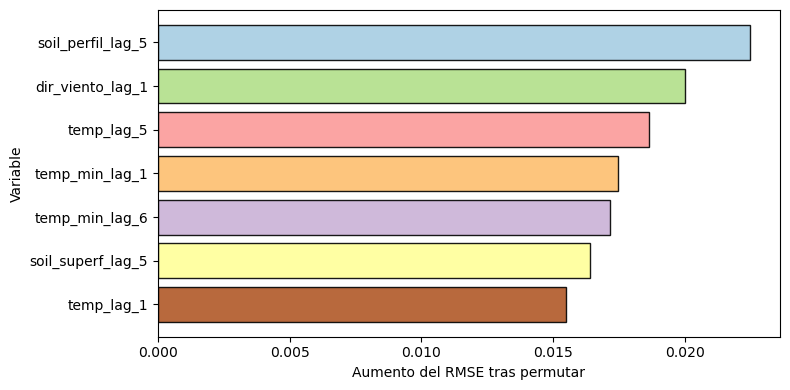

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

def plot_importances(ordered_dict, top=None, title=""):
    names = list(ordered_dict.keys())
    vals  = np.array(list(ordered_dict.values()))
    if top is not None:
        names, vals = names[:top], vals[:top]

    plt.figure(figsize=(8, max(4, 0.35*len(names))))
    y = np.arange(len(names))[::-1]

    # Colores: mapea valores a una paleta
    cmap = cm.get_cmap("Paired")  # puedes cambiar por "plasma", "coolwarm", etc.
    colors = cmap(np.linspace(0, 1, len(vals)))

    plt.barh(y, vals, alpha=0.9, color=colors, edgecolor="black")
    plt.yticks(y, names)
    plt.xlabel("Aumento del RMSE tras permutar")
    plt.ylabel("Variable")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ejemplo
plot_importances(imp_renamed, top=7)

In [51]:
def desalinear_a_target(predicciones, targets, vt_labels, pad_value=float('nan')):
    """
    Devuelve:
      - pred_pad  : [B, T_tgt, 1] con pred_pad[:, 1:, :] = predicciones
      - targets_f : [B, T_tgt, 1] igual al original (si venía [B,T_tgt], se unsqueezea)
      - vt_full   : [B, T_tgt]    igual al original (sin recorte)

    No modifica el target; 'rellena' pred con un primer paso = pad_value.
    """
    if targets.dim() == 2:
        targets_f = targets.unsqueeze(-1)     # [B, T_tgt, 1]
    else:
        targets_f = targets                   # [B, T_tgt, 1]
    B, T_tgt = targets_f.size(0), targets_f.size(1)
    T_pred   = predicciones.size(1)

    # crea [B, T_tgt, 1] lleno con pad_value y copia pred desde el índice 1
    pred_pad = predicciones.new_full((B, T_tgt, predicciones.size(2)), fill_value=pad_value)
    T_copy = min(T_pred, T_tgt-1)
    pred_pad[:, 1:1+T_copy, :] = predicciones[:, :T_copy, :]

    vt_full = vt_labels  # [B, T_tgt]
    return pred_pad, targets_f, vt_full


def desalinear_ut(ut_valores, T_tgt, pad_value=float('nan')):
    """
    ut_valores: [B, T_pred]  ->  ut_pad: [B, T_tgt] con ut_pad[:, 1:] = ut_valores
    """
    B = ut_valores.size(0)
    ut_pad = ut_valores.new_full((B, T_tgt), fill_value=pad_value)
    T_pred = ut_valores.size(1)
    T_copy = min(T_pred, T_tgt-1)
    ut_pad[:, 1:1+T_copy] = ut_valores[:, :T_copy]
    return ut_pad


In [52]:
# Suponiendo que predictions y targets están aplanados (len = n_sucesiones * W)
W = config['seq_length']
L = len(predictions)
assert L % W == 0, "La longitud de predictions/targets no es múltiplo de W."
n_sucesiones = L // W

pred_mat = np.asarray(predictions).reshape(n_sucesiones, W)
tgt_mat  = np.asarray(targets).reshape(n_sucesiones, W)

# Serie sin solapamiento (una observación por sucesión)
pred_unique = pred_mat[:, -1]   # predicción del último paso de cada ventana
real_unique = tgt_mat[:, -1]    # real correspondiente (sin duplicación)

# (Opcional) si también quieres UT/VT por punto único:
# ut_mat = np.asarray(ut).reshape(n_sucesiones, W)
# vt_mat = np.asarray(vt).reshape(n_sucesiones, W)
# ut_unique = ut_mat[:, -1]
# vt_unique = vt_mat[:, -1]

# Si dibujabas líneas de corte, ahora los cortes van por sucesión, no por punto:
n_train = len(train_loader.dataset)
n_val   = len(val_loader.dataset)
cut_train_val = n_train             # ya no se multiplica por W
cut_val_test  = n_train + n_val

import matplotlib.pyplot as plt
x = np.arange(n_sucesiones)

plt.figure(figsize=(12, 5))
plt.plot(x, real_unique, label='Real', alpha=0.8)
plt.plot(x, pred_unique, label='Predicho', alpha=0.8)

# líneas de split (si caen dentro del rango)
if 0 < cut_train_val < n_sucesiones:
    plt.axvline(cut_train_val, color='k', linestyle='--', linewidth=1, label='Split train/val')
if 0 < cut_val_test < n_sucesiones:
    plt.axvline(cut_val_test,  color='k', linestyle=':',  linewidth=1, label='Split val/test')

plt.title('Serie (sin solapamiento): Real vs Predicho')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


NameError: name 'predictions' is not defined

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def reconstruir_pred_series(pred_flat, W, N_raw):
    """
    pred_flat: vector 1D con las predicciones aplanadas (n_sucesiones * W).
    W       : longitud de ventana (seq_length).
    N_raw   : longitud de la serie original.

    Devuelve yhat_scaled de longitud N_raw, con NaN en posiciones sin cobertura (t=0).
    """
    pred_flat = np.asarray(pred_flat).ravel()
    assert pred_flat.size % W == 0, "La longitud de predicciones no es múltiplo de W."
    n = pred_flat.size // W
    pred_mat = pred_flat.reshape(n, W)

    # Para cada sucesión i, sus W predicciones corresponden a los tiempos t = i+1 ... i+W
    sums   = np.zeros(N_raw, dtype=float)
    counts = np.zeros(N_raw, dtype=int)
    for i in range(n):
        t_idx = np.arange(i + 1, i + 1 + W)  # long W
        sums[t_idx]   += pred_mat[i]
        counts[t_idx] += 1

    yhat = np.full(N_raw, np.nan, dtype=float)
    m = counts > 0
    yhat[m] = sums[m] / counts[m]
    return yhat

# === 1) Reconstruir predicción al timeline original ===
W = config['seq_length']

# Cargar y real original del CSV
df = pd.read_csv(config['excel_path'], index_col=0)
y_real_orig = df[config['target_column']].values.astype(float)
N_raw = len(y_real_orig)

# Reconstruir en escala "normalizada"
yhat_scaled = reconstruir_pred_series(predictions, W, N_raw)

# Volver a escala original con tu scaler
# (si predictions ya están en escala original, omite este paso)
yhat_orig = cargar_datos.scaler_y.inverse_transform(
    yhat_scaled.reshape(-1, 1)
).ravel()

# === 2) Opcional: líneas de corte en índice original ===
n_train = len(train_loader.dataset)  # número de sucesiones en train
n_val   = len(val_loader.dataset)
# Fin de train y val en el índice original:
cut_train_val = n_train + W - 1
cut_val_test  = n_train + n_val + W - 1

# === 3) Gráfico ===
x = np.arange(N_raw)

plt.figure(figsize=(12, 6))
plt.plot(x, y_real_orig, label='Real (original)', alpha=0.8)
plt.plot(x, yhat_orig, label='Predicho (reconstruido)', alpha=0.8)

# Líneas verticales (solo si están dentro del rango)
if 0 < cut_train_val < N_raw:
    plt.axvline(cut_train_val, color='k', linestyle='--', linewidth=1, label='Split train/val')
if 0 < cut_val_test < N_raw:
    plt.axvline(cut_val_test,  color='k', linestyle=':',  linewidth=1, label='Split val/test')

plt.title('Serie original vs. predicción reconstruida (sin solapamiento)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


NameError: name 'predictions' is not defined

In [45]:
def reconstruir_pred_series(pred_flat, W, N_raw, start_seq=0):
    """
    pred_flat : vector 1D (n_sucesiones * W) de un split concreto (train/val/test)
    W         : seq_length
    N_raw     : longitud de la serie original
    start_seq : índice de sucesión donde empieza este split en el dataset completo
                (train=0, val=n_train, test=n_train+n_val)
    """
    pred_flat = np.asarray(pred_flat).ravel()
    assert pred_flat.size % W == 0, "La longitud de predicciones no es múltiplo de W."
    n = pred_flat.size // W
    pred_mat = pred_flat.reshape(n, W)

    sums   = np.zeros(N_raw, dtype=float)
    counts = np.zeros(N_raw, dtype=int)

    # Cada sucesión i del split corresponde a las posiciones (start_seq+i+1 ... +W)
    for i in range(n):
        t_idx = np.arange(start_seq + i + 1, start_seq + i + 1 + W)
        m = (t_idx >= 0) & (t_idx < N_raw)        # por seguridad en bordes
        if m.any():
            sums[t_idx[m]]   += pred_mat[i][m]
            counts[t_idx[m]] += 1

    yhat = np.full(N_raw, np.nan)
    mask = counts > 0
    yhat[mask] = sums[mask] / counts[mask]
    return yhat


In [46]:
W = config['seq_length']
df = pd.read_csv(config['excel_path'], index_col=0)
y_real_orig = df[config['target_column']].values.astype(float)
N_raw = len(y_real_orig)

n_train = len(train_loader.dataset)
n_val   = len(val_loader.dataset)

# Si tus 'predictions' vienen del TEST:
start_seq = n_train + n_val

# Si vienen del TRAIN:
# start_seq = 0

# Si vienen del VAL:
# start_seq = n_train

yhat_scaled = reconstruir_pred_series(predictions, W, N_raw, start_seq=start_seq)
yhat_orig = cargar_datos.scaler_y.inverse_transform(yhat_scaled.reshape(-1,1)).ravel()


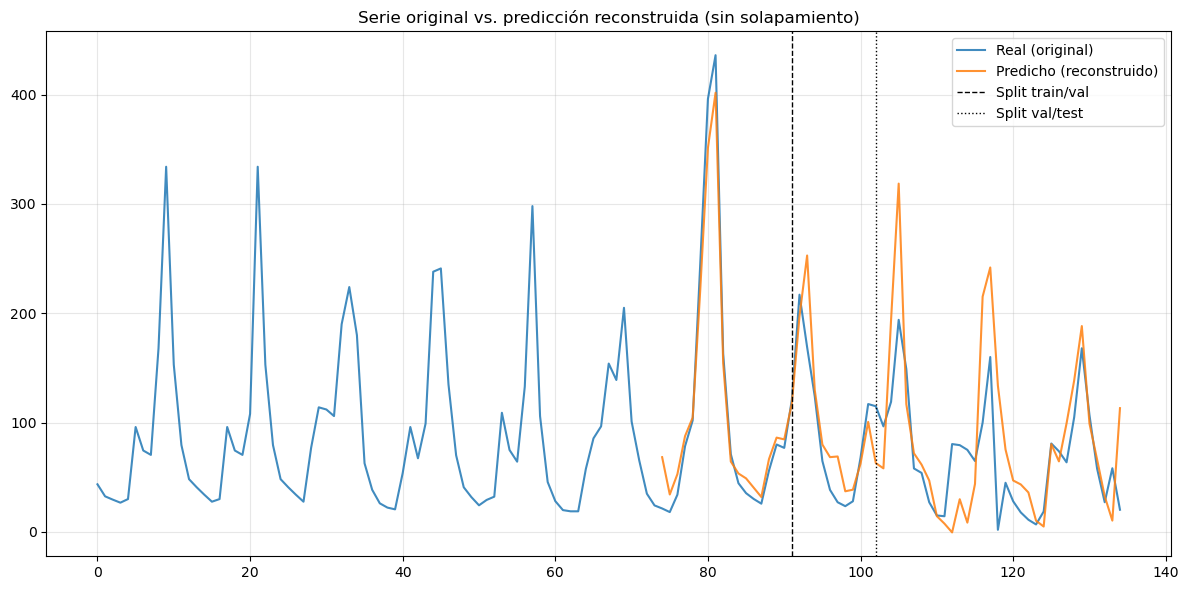

In [47]:
x = np.arange(N_raw)
plt.figure(figsize=(12,6))
plt.plot(x, y_real_orig, label='Real (original)', alpha=0.85)
plt.plot(x, yhat_orig, label='Predicho (reconstruido)', alpha=0.85)

# líneas de split (opcional)
cut_train_val = n_train + W - 1
cut_val_test  = n_train + n_val + W - 1
if 0 < cut_train_val < N_raw:
    plt.axvline(cut_train_val, color='k', linestyle='--', linewidth=1, label='Split train/val')
if 0 < cut_val_test < N_raw:
    plt.axvline(cut_val_test,  color='k', linestyle=':',  linewidth=1, label='Split val/test')

plt.title('Serie original vs. predicción reconstruida (sin solapamiento)')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


In [59]:
df.index

DatetimeIndex([          '1970-01-01 00:00:00',
               '1970-01-01 00:00:00.000000026',
               '1970-01-01 00:00:00.000000059',
               '1970-01-01 00:00:00.000000063',
               '1970-01-01 00:00:00.000000093',
               '1970-01-01 00:00:00.000000150',
               '1970-01-01 00:00:00.000000178',
               '1970-01-01 00:00:00.000000198',
               '1970-01-01 00:00:00.000000217',
               '1970-01-01 00:00:00.000000272',
               ...
               '1970-01-01 00:00:00.000003776',
               '1970-01-01 00:00:00.000003830',
               '1970-01-01 00:00:00.000003860',
               '1970-01-01 00:00:00.000003872',
               '1970-01-01 00:00:00.000003914',
               '1970-01-01 00:00:00.000003947',
               '1970-01-01 00:00:00.000003988',
               '1970-01-01 00:00:00.000004082',
               '1970-01-01 00:00:00.000004201',
               '1970-01-01 00:00:00.000004323'],
              dtype=

In [89]:
indices = pd.read_csv(r'../../data/Brujo/BaseCompletaBrujo.csv').sort_values(by='fecha')
indices.set_index('fecha', inplace=True)
ind = indices.index

In [99]:
ind

Index(['1982-01-30', '1982-02-25', '1982-03-30', '1982-04-03', '1982-05-03',
       '1982-06-29', '1982-07-27', '1982-08-16', '1982-09-04', '1982-10-29',
       ...
       '1992-06-02', '1992-07-26', '1992-08-25', '1992-09-06', '1992-10-18',
       '1992-11-20', '1992-12-31', '1993-04-04', '1993-08-01', '1993-12-01'],
      dtype='object', name='fecha', length=135)

In [92]:
years = pd.to_datetime(ind).year
print(years)

Index([1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982,
       ...
       1992, 1992, 1992, 1992, 1992, 1992, 1992, 1993, 1993, 1993],
      dtype='int32', name='fecha', length=135)


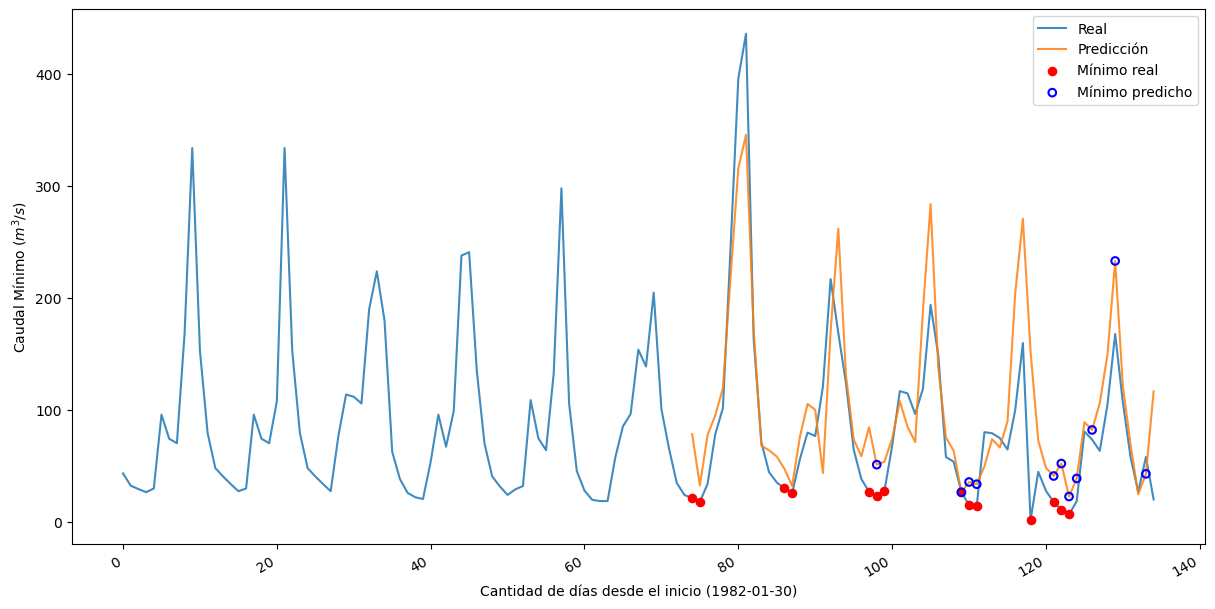

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# ---------- Helpers de reconstrucción (sin solapamiento) ----------
def reconstruir_pred_series(pred_flat, W, N_raw, start_seq=0):
    """Reconstruye predicciones al índice original (long N_raw)."""
    pred_flat = np.asarray(pred_flat).ravel()
    assert pred_flat.size % W == 0
    n = pred_flat.size // W
    pred_mat = pred_flat.reshape(n, W)

    sums   = np.zeros(N_raw, dtype=float)
    counts = np.zeros(N_raw, dtype=int)
    for i in range(n):
        t_idx = np.arange(start_seq + i + 1, start_seq + i + 1 + W)
        m = (t_idx >= 0) & (t_idx < N_raw)
        sums[t_idx[m]]   += pred_mat[i][m]
        counts[t_idx[m]] += 1
    yhat = np.full(N_raw, np.nan)
    mask = counts > 0
    yhat[mask] = sums[mask] / counts[mask]
    return yhat

def reconstruir_vt(vt_flat, W, N_raw, start_seq=0, rule="any"):
    """
    Reconstruye etiquetas de extremos al índice original.
    rule: "any" (extremo si aparece en alguna ventana) | "majority" | "prob" (devuelve prob).
    """
    vt_flat = np.asarray(vt_flat).ravel()
    assert vt_flat.size % W == 0
    n = vt_flat.size // W
    vt_mat = vt_flat.reshape(n, W)
    vt_bin = (vt_mat == -1).astype(int)

    sums   = np.zeros(N_raw, dtype=float)
    counts = np.zeros(N_raw, dtype=int)
    for i in range(n):
        t_idx = np.arange(start_seq + i + 1, start_seq + i + 1 + W)
        m = (t_idx >= 0) & (t_idx < N_raw)
        sums[t_idx[m]]   += vt_bin[i][m]
        counts[t_idx[m]] += 1

    prob = np.zeros(N_raw, dtype=float)
    mask = counts > 0
    prob[mask] = sums[mask] / counts[mask]

    if rule == "prob":
        return prob, prob  # por compatibilidad
    elif rule == "majority":
        return (prob >= 0.5).astype(int), prob
    else:  # "any"
        return (sums > 0).astype(int), prob

def reconstruir_ut(ut_flat, W, N_raw, start_seq=0, agg="mean"):
    """
    Reconstruye un score UT por instante original.
    agg: "mean" (promedio de UT), "min" (más conservador: el UT más negativo).
    """
    ut_flat = np.asarray(ut_flat).ravel()
    assert ut_flat.size % W == 0
    n = ut_flat.size // W
    ut_mat = ut_flat.reshape(n, W)

    if agg == "min":
        # Usamos +inf y tomamos mínimos
        ut_rec = np.full(N_raw, np.inf)
        counts = np.zeros(N_raw, dtype=int)
        for i in range(n):
            t_idx = np.arange(start_seq + i + 1, start_seq + i + 1 + W)
            m = (t_idx >= 0) & (t_idx < N_raw)
            idx = t_idx[m]
            ut_rec[idx] = np.minimum(ut_rec[idx], ut_mat[i][m])
            counts[idx] += 1
        ut_rec[counts == 0] = np.nan
    else:
        sums   = np.zeros(N_raw, dtype=float)
        counts = np.zeros(N_raw, dtype=int)
        for i in range(n):
            t_idx = np.arange(start_seq + i + 1, start_seq + i + 1 + W)
            m = (t_idx >= 0) & (t_idx < N_raw)
            sums[t_idx[m]]   += ut_mat[i][m]
            counts[t_idx[m]] += 1
        ut_rec = np.full(N_raw, np.nan)
        mask = counts > 0
        ut_rec[mask] = sums[mask] / counts[mask]
    return ut_rec
# -------------------------------------------------------------------

# === Parámetros y datos base ===
W = config['seq_length']
df = pd.read_csv(config['excel_path'], index_col=0)
df.set_index(pd.to_datetime(df['fecha']), inplace=True)
y_real_orig = df[config['target_column']].values.astype(float)
N_raw = len(y_real_orig)

# ¿Desde qué sucesión arranca este split?
n_train = len(train_loader.dataset)
n_val   = len(val_loader.dataset)
# Si tus arrays (predictions/ut/vt) vienen de TEST:
start_seq = n_train + n_val
# Si son de TRAIN: start_seq = 0
# Si son de VAL  : start_seq = n_train

# Reconstrucciones
yhat_scaled = reconstruir_pred_series(preds, W, N_raw, start_seq=start_seq)
yhat_orig   = cargar_datos.scaler_y.inverse_transform(yhat_scaled.reshape(-1,1)).ravel()

vt_rec_bin, vt_prob = reconstruir_vt(vt, W, N_raw, start_seq=start_seq, rule="any")
ut_rec      = reconstruir_ut(ut, W, N_raw, start_seq=start_seq, agg="mean")

# Umbral para UT (más extremo = más negativo)
umbral = float(getattr(entrenador.model, "umbral_ut", getattr(entrenador.model, "p_minimo", 0.1)))
if umbral > 1:
    umbral /= 100.0
pred_ext_mask = (ut_rec <= -umbral)  # extremos predichos
true_ext_mask = (vt_rec_bin == 1)    # extremos reales reconstruidos

# Cortes (en índice original)
cut_train_val = n_train + W - 1
cut_val_test  = n_train + n_val + W - 1

# ============== PLOT 1: Serie + extremos =================
x = np.arange(N_raw)
plt.figure(figsize=(12, 6))
plt.plot(x, y_real_orig, label='Real', alpha=0.85)
plt.plot(x, yhat_orig,   label='Predicción', alpha=0.85)

# Mínimos reales (rojo) y predichos por UT (azul vacío)
plt.scatter(x[true_ext_mask], y_real_orig[true_ext_mask], c='red', s=35, label='Mínimo real', zorder=5)
# evita NaN en yhat_orig
mask_pred_points = pred_ext_mask & ~np.isnan(yhat_orig)
plt.scatter(x[mask_pred_points], yhat_orig[mask_pred_points],
            s=30, facecolors='none', edgecolors='blue', linewidths=1.5,
            label='Mínimo predicho', zorder=6)

# Líneas de split
#if 0 < cut_train_val < N_raw: plt.axvline(cut_train_val, color='k', linestyle='--', linewidth=1, label='Split train/val')
#if 0 < cut_val_test  < N_raw: plt.axvline(cut_val_test,  color='k', linestyle=':',  linewidth=1, label='Split val/test')

plt.legend()
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.xlabel('Cantidad de días desde el inicio (1982-01-30)')
plt.ylabel(f'Caudal Mínimo ($m^3/s$)')
plt.show()


In [101]:
16/3

5.333333333333333

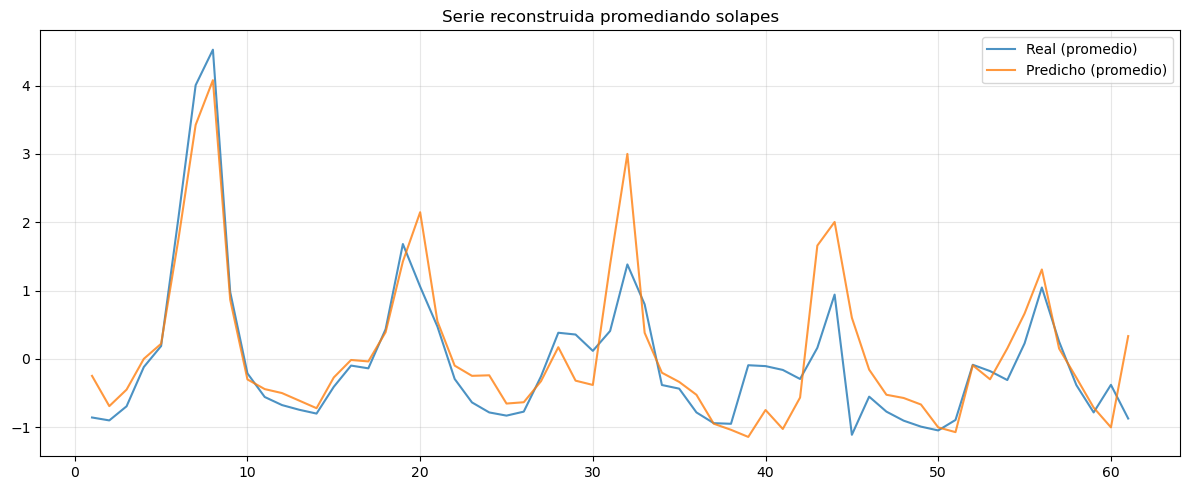

In [42]:
def desolapar_promediando(pred_flat, tgt_flat, W):
    L = len(pred_flat)
    assert L % W == 0
    n = L // W
    pred_mat = np.asarray(pred_flat).reshape(n, W)
    tgt_mat  = np.asarray(tgt_flat).reshape(n, W)
    N = n + W  # aprox. longitud de la serie original (por el esquema y[i+1:i+W+1])

    suma_pred = np.zeros(N, dtype=float)
    suma_tgt  = np.zeros(N, dtype=float)
    cuenta    = np.zeros(N, dtype=int)

    # Cada fila i cubre posiciones temporales (i+1 ... i+W)
    for i in range(n):
        idx = np.arange(i+1, i+W+1)  # longitud W
        suma_pred[idx] += pred_mat[i]
        suma_tgt[idx]  += tgt_mat[i]
        cuenta[idx]    += 1

    mask = cuenta > 0
    pred_rec = np.full(N, np.nan); pred_rec[mask] = suma_pred[mask]/cuenta[mask]
    tgt_rec  = np.full(N, np.nan); tgt_rec[mask]  = suma_tgt[mask]/cuenta[mask]
    return pred_rec, tgt_rec  # contendrán NaN en los puntos sin cobertura

pred_rec, tgt_rec = desolapar_promediando(predictions, targets, config['seq_length'])

plt.figure(figsize=(12,5))
plt.plot(tgt_rec, label='Real (promedio)', alpha=0.8)
plt.plot(pred_rec, label='Predicho (promedio)', alpha=0.8)
plt.title('Serie reconstruida promediando solapes')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


Gráficos individuales


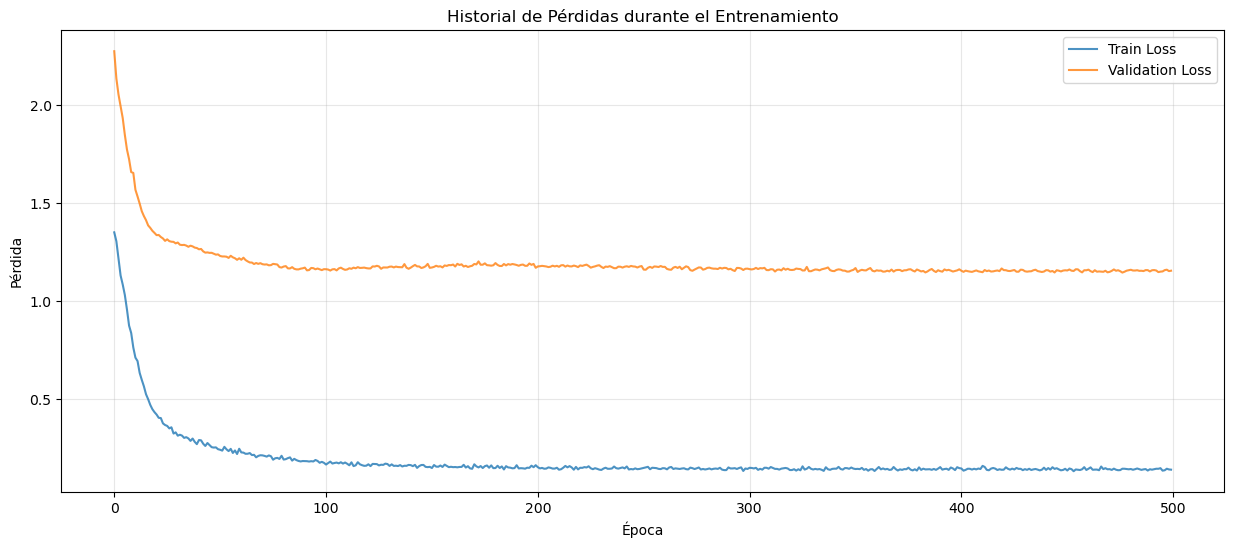

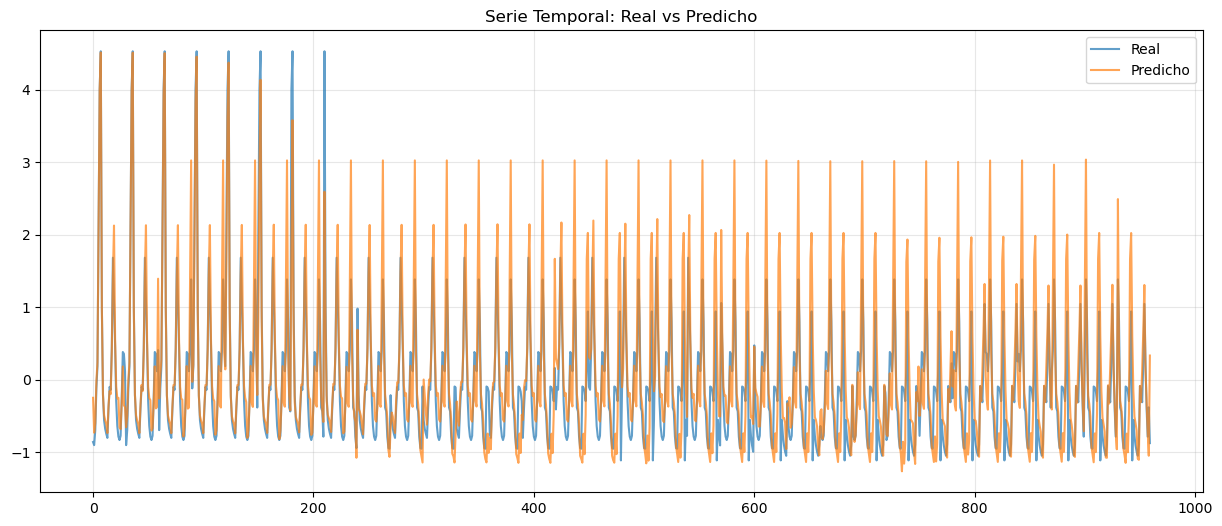

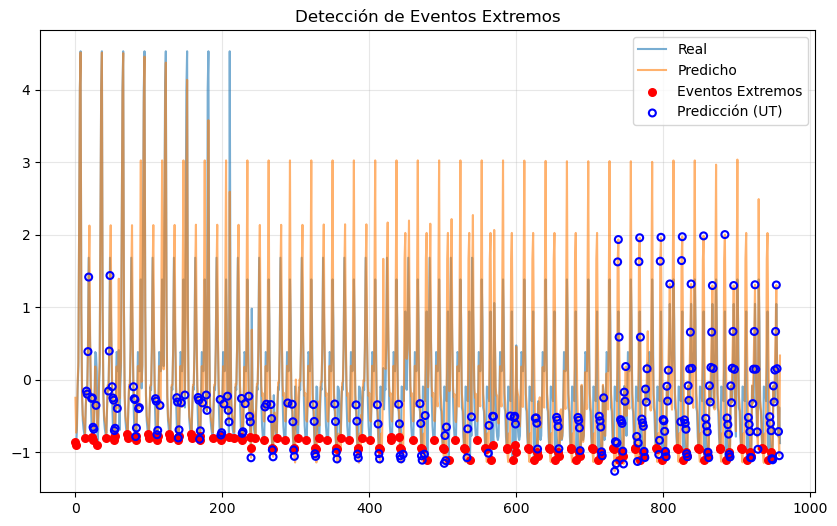

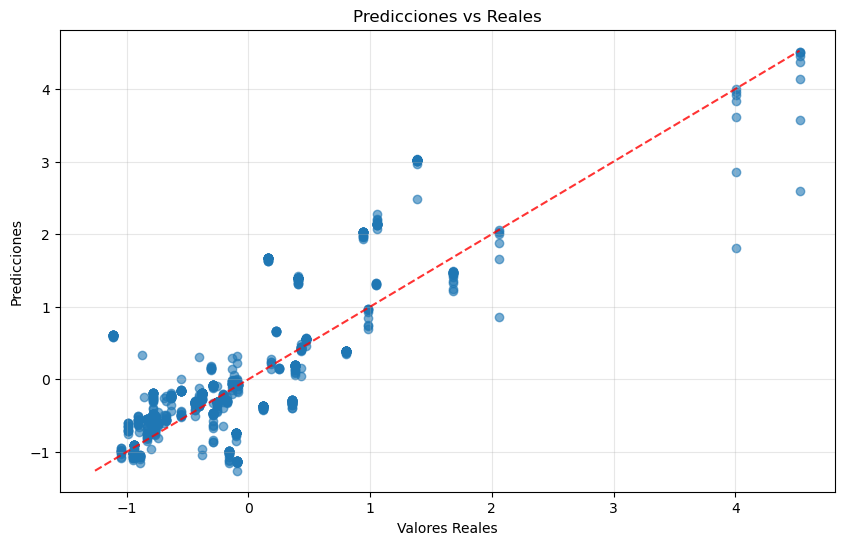

In [ ]:

plt.figure(figsize=(15, 6))
plt.plot(loss_history['train'], label='Train Loss', alpha=0.8)
plt.plot(loss_history['val'], label='Validation Loss', alpha=0.8)
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Historial de Pérdidas durante el Entrenamiento')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


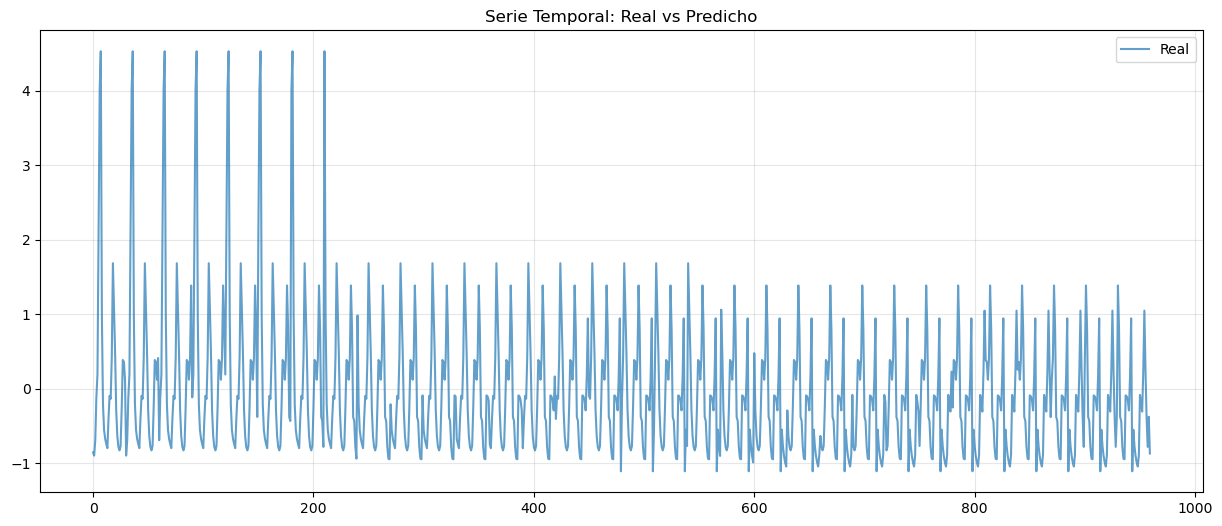

In [37]:
plt.figure(num="Serie Temporal: Real vs Predicho", figsize=(15, 6))
plt.plot(targets, label='Real', alpha=0.7)
#plt.plot(predictions, label='Predicho', alpha=0.7)
plt.title('Serie Temporal: Real vs Predicho')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
from itertools import product
import numpy as np

def grid_search(entrenador_cls, cargar_datos, param_grid, device, 
                batch_size, metodo='percentil', epochs=50, paciencia=10):
    """
    GridSearch manual para EntrenamientoEVT.
    
    Args:
        entrenador_cls : clase del orquestador (EntrenamientoEVT).
        cargar_datos   : instancia de Data (dataset preparado).
        param_grid     : dict con listas de hiperparámetros, ej:
                         {'hidden_size':[32,64], 'learning_rate':[1e-3,1e-4]}
        device         : torch.device
        batch_size     : int
        metodo         : str ('percentil' o 'zscore-like')
        epochs         : int
        paciencia      : int
    """
    # Generar todas las combinaciones posibles
    keys, values = zip(*param_grid.items())
    all_combinations = [dict(zip(keys, v)) for v in product(*values)]

    resultados = []
    for i, params in enumerate(all_combinations, 1):
        print(f"\n=== Grid {i}/{len(all_combinations)}: {params} ===")
        
        # Instanciar nuevo entrenador con estos params
        entrenador = entrenador_cls(
            size_input = params.get('input_size', cargar_datos.feature and len(cargar_datos.feature)),
            size_oculto = params.get('hidden_size', 64),
            size_memoria = params.get('memory_size', 30),
            size_ventana = params.get('window_size', 10),
            tasa_aprendizaje = params.get('learning_rate', 1e-4),
            gamma = params.get('gamma', 1),
            labda1 = params.get('lambda1', 1)
        ).to(device)

        # Crear dataloaders
        train_loader, val_loader, test_loader = dataloaders(cargar_datos, batch_size, metodo)

        # Entrenar
        entrenador.entrenar_epocas(train_loader, val_loader, epochs=epochs, paciencia=paciencia)

        # Evaluar
        preds, tgts, ut, vt = evaluar_modelo(entrenador, test_loader, device, "Test")
        umbral = getattr(entrenador.model, "umbral_ut", getattr(entrenador.model, "p_minimo", 0.1))
        metrics = calcular_metricas(preds, tgts, ut, vt, "Test", umbral)

        # Score combinado: ponderamos R² y F1
        r2 = metrics["Test_r2"]
        f1 = metrics["Test_f1"]
        score = 0.5 * r2 + 0.5 * f1   # ajusta los pesos según prefieras

        resultados.append({
            "params": params,
            "r2": r2,
            "f1": f1,
            "score": score
        })
        print(f"R2={r2:.3f} | F1={f1:.3f} | Score={score:.3f}")

    # Elegir el mejor
    resultados_sorted = sorted(resultados, key=lambda x: x["score"], reverse=True)
    mejor = resultados_sorted[0]
    print("\n=== Mejor combinación ===")
    print(mejor)
    return mejor, resultados_sorted

import random


def random_search(entrenador_cls, cargar_datos, param_grid, n_iter,
                  device, batch_size, metodo='percentil',
                  epochs=50, paciencia=10, f1_weight=0.6):
    """
    Random Search para EntrenamientoEVT.
    
    Args:
        entrenador_cls : clase del orquestador (EntrenamientoEVT).
        cargar_datos   : instancia de Data (dataset preparado).
        param_grid     : dict con listas de hiperparámetros.
        n_iter         : número de combinaciones aleatorias a probar.
        device         : torch.device
        batch_size     : int
        metodo         : str ('percentil' o 'zscore-like')
        epochs         : int, default 50
        paciencia      : int, default 10
        f1_weight      : float, peso del F1 en el score combinado
    """
    # Expandir todas las combinaciones posibles
    keys, values = zip(*param_grid.items())
    all_combinations = [dict(zip(keys, v)) for v in product(*values)]
    
    # Seleccionar al azar n_iter combinaciones
    sampled = random.sample(all_combinations, min(n_iter, len(all_combinations)))
    
    resultados = []
    for i, params in enumerate(sampled, 1):
        print(f"\n=== Random {i}/{len(sampled)}: {params} ===")
        
        # Instanciar nuevo entrenador con estos params
        entrenador = entrenador_cls(
            size_input = len(cargar_datos.feature),
            size_oculto = params.get('hidden_size', 64),
            size_memoria = params['memory_size'],
            size_ventana = params['window_size'],
            tasa_aprendizaje = params['learning_rate'],
            gamma = params['gamma'],
            labda1 = params['lambda1']
        ).to(device)

        # Crear dataloaders
        train_loader, val_loader, test_loader = dataloaders(cargar_datos, batch_size, metodo)

        # Entrenar
        entrenador.entrenar_epocas(train_loader, val_loader, epochs=epochs, paciencia=paciencia)

        # Evaluar
        preds, tgts, ut, vt = evaluar_modelo(entrenador, test_loader, device, "Test")
        umbral = getattr(entrenador.model, "umbral_ut", getattr(entrenador.model, "p_minimo", 0.1))
        metrics = calcular_metricas(preds, tgts, ut, vt, "Test", umbral)

        # Score combinado (pondera F1 más que R² si f1_weight > 0.5)
        r2 = metrics["Test_r2"]
        f1 = metrics["Test_f1"]
        score = (1 - f1_weight) * r2 + f1_weight * f1

        resultados.append({
            "params": params,
            "r2": r2,
            "f1": f1,
            "score": score
        })
        print(f"R2={r2:.3f} | F1={f1:.3f} | Score={score:.3f}")

    # Convertir a DataFrame
    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.sort_values(by="score", ascending=False).reset_index(drop=True)
    
    print("\n=== Top resultados ===")
    print(df_resultados.head(10))
    
    return df_resultados


param_grid = {
    "gamma": [0.8, 1.0, 1.2, 1.5, 2.0],
    "lambda1": [0.5, 1.0, 2.0, 3.0, 5.0],
    "memory_size": [10, 20, 30, 50],
    "window_size": [6, 12, 18, 24],
    "learning_rate": [1e-3, 5e-4, 1e-4]
}

df_resultados = random_search(
    EntrenamientoEVT, cargar_datos, param_grid,
    n_iter=30, device=device, batch_size=config["batch_size"],
    metodo="percentil", epochs=50, paciencia=10, f1_weight=0.6
)

# Ver la mejor combinación
print("Mejor combinación encontrada:")
print(df_resultados.iloc[0])





=== Random 1/30: {'gamma': 1.2, 'lambda1': 2.0, 'memory_size': 10, 'window_size': 24, 'learning_rate': 0.0001} ===
Época   0 | Train Loss: 1.247886e+00 | Val Loss: 2.035409e+00 | Val F1(ext): 0.394 | Paciencia: 0/10
Época   1 | Train Loss: 1.095730e+00 | Val Loss: 2.177454e+00 | Val F1(ext): 0.320 | Paciencia: 1/10
Época   2 | Train Loss: 1.059050e+00 | Val Loss: 1.881672e+00 | Val F1(ext): 0.364 | Paciencia: 0/10
Época   3 | Train Loss: 9.434835e-01 | Val Loss: 1.854831e+00 | Val F1(ext): 0.350 | Paciencia: 0/10
Época   4 | Train Loss: 8.537688e-01 | Val Loss: 1.803594e+00 | Val F1(ext): 0.364 | Paciencia: 0/10
Época   5 | Train Loss: 8.894579e-01 | Val Loss: 1.710269e+00 | Val F1(ext): 0.359 | Paciencia: 0/10
Época   6 | Train Loss: 8.173562e-01 | Val Loss: 1.638231e+00 | Val F1(ext): 0.452 | Paciencia: 0/10
Época   7 | Train Loss: 7.326887e-01 | Val Loss: 1.592654e+00 | Val F1(ext): 0.378 | Paciencia: 0/10
Época   8 | Train Loss: 6.486591e-01 | Val Loss: 1.776325e+00 | Val F1(ext):

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.974, max=0.000, mean=-0.031, std=0.136
UT valores: (array([-0.97, -0.95, -0.92, -0.91, -0.89, -0.87, -0.85, -0.83, -0.79,
       -0.76, -0.74, -0.72, -0.7 , -0.69, -0.67, -0.66, -0.64, -0.61,
       -0.59, -0.57, -0.55, -0.54, -0.49, -0.48, -0.47, -0.45, -0.42,
       -0.41, -0.36, -0.35, -0.34, -0.27, -0.26, -0.25, -0.24, -0.22,
       -0.21, -0.2 , -0.18, -0.17, -0.14, -0.11, -0.09, -0.08, -0.06,
       -0.05,  0.  ], dtype=float32), array([  1,   2,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   3,
         1,   1,   1,   1,   1,   1,   1,   2,   1,   1,   2,   1,   1,
         1,   2,   2,   2,   1,   2,   1,   2,   2,   2,   1,   1,   1,
         1,   2,   3,   1,   2,   1,   2, 896]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.069: 61 samples
VT= [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0. -1.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.999, max=0.000, mean=-0.071, std=0.173
UT valores: (array([-1.  , -0.82, -0.81, -0.8 , -0.79, -0.78, -0.77, -0.76, -0.7 ,
       -0.69, -0.68, -0.67, -0.66, -0.65, -0.64, -0.63, -0.62, -0.61,
       -0.58, -0.57, -0.55, -0.54, -0.53, -0.51, -0.49, -0.48, -0.46,
       -0.45, -0.42, -0.41, -0.4 , -0.38, -0.37, -0.36, -0.35, -0.34,
       -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25,
       -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16,
       -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07,
       -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ], dtype=float32), array([  6,   4,   1,   2,   2,   1,   1,   1,   3,   1,   2,   2,   2,
         2,   2,   1,   1,   1,   2,   4,   1,   2,   1,   2,   4,   2,
         3,   2,   2,   2,   1,   1,   3,   2,   1,   5,   3,   3,   5,
         1,   3,   1,   1,   3,   2,   7,   1,   2,   3,   2,   5,   6,
         7,   6,   2,   5,   3,   1,  10,   8,  12,   7,  10,  11,  14,
         6,  

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.989, max=0.000, mean=-0.074, std=0.170
UT valores: (array([-0.99, -0.97, -0.96, -0.95, -0.93, -0.9 , -0.89, -0.88, -0.87,
       -0.8 , -0.75, -0.73, -0.71, -0.7 , -0.67, -0.66, -0.65, -0.62,
       -0.59, -0.58, -0.57, -0.54, -0.53, -0.52, -0.51, -0.5 , -0.49,
       -0.48, -0.47, -0.44, -0.43, -0.41, -0.4 , -0.39, -0.38, -0.37,
       -0.36, -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28,
       -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19,
       -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 ,
       -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,
        0.  ], dtype=float32), array([  1,   1,   1,   1,   3,   1,   1,   2,   4,   1,   2,   3,   2,
         1,   1,   1,   1,   1,   1,   1,   3,   2,   3,   1,   5,   4,
         1,   1,   1,   1,   3,   1,   1,   2,   2,   2,   3,   2,   1,
         3,   2,   2,   5,   4,   1,   3,   1,   2,   2,   6,   2,   7,
         5,   7,   6,   3,  10,   6,  10,   8,   9,   6, 

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.999, max=0.000, mean=-0.026, std=0.112
UT valores: (array([-1.  , -0.93, -0.92, -0.91, -0.62, -0.58, -0.44, -0.41, -0.4 ,
       -0.39, -0.38, -0.36, -0.35, -0.34, -0.33, -0.31, -0.3 , -0.29,
       -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.21, -0.19, -0.18,
       -0.17, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08,
       -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ],
      dtype=float32), array([  6,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   2,   1,
         3,   1,   1,   3,   1,   2,   2,   1,   1,   1,   1,   3,   1,
         3,   1,   2,   2,   4,   2,   2,   5,   4,   2,  10,   3,  10,
        11,  11,  15,  17, 816]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 122 samples
VT= [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 -1.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.
 -1.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  0.  0.  0. -1.  0. -1. -1.
  0.  0. -1.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.916, max=0.000, mean=-0.015, std=0.088
UT valores: (array([-0.92, -0.91, -0.89, -0.83, -0.82, -0.64, -0.6 , -0.58, -0.52,
       -0.51, -0.48, -0.47, -0.42, -0.41, -0.39, -0.37, -0.36, -0.3 ,
       -0.27, -0.25, -0.24, -0.22, -0.21, -0.18, -0.17, -0.15, -0.13,
       -0.11, -0.1 , -0.09, -0.08, -0.07, -0.04, -0.03, -0.02, -0.01,
        0.  ], dtype=float32), array([  1,   1,   1,   1,   1,   1,   1,   1,   2,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   2,   1,   1,   2,   1,   1,
         1,   1,   2,   1,   1,   4,   7,   1,   7,   8, 898]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.512: 10 samples
VT= [ 0.  0.  0. -1.  0. -1.  0.  0.  0.  0.]
Eventos Extremos : 151
Proporción: 0.1573
MÉTRICAS TEST:
   Test_mse: 0.443261
   Test_mae: 0.459277
   Test_rmse: 0.665779
   Test_r2: 0.436054
   Test_extreme_mse: 0.690012
   Test_extreme_mae: 0.534950
   Test_extreme_ratio: 0.157292
   Test_precision: 0.200000
   Test_recall: 0.0132

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.998, max=0.000, mean=-0.029, std=0.121
UT valores: (array([-1.  , -0.86, -0.82, -0.81, -0.79, -0.72, -0.71, -0.68, -0.62,
       -0.6 , -0.5 , -0.48, -0.46, -0.4 , -0.37, -0.34, -0.31, -0.29,
       -0.28, -0.26, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17,
       -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08,
       -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ],
      dtype=float32), array([  6,   1,   1,   1,   1,   2,   1,   1,   2,   1,   1,   1,   1,
         1,   2,   2,   1,   2,   1,   2,   2,   1,   3,   3,   4,   3,
         1,   4,   4,   2,   1,   1,   4,   3,   4,   8,   6,   4,   6,
         6,  10,  21,  19, 809]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 122 samples
VT= [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 -1.  0.  0. -1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0. -1.  0.  0.
  0.  0. -1.  0.  0. -1.  0. -1.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1.
 -1.  0.  0.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.993, max=0.000, mean=-0.029, std=0.125
UT valores: (array([-0.99, -0.86, -0.85, -0.82, -0.73, -0.7 , -0.69, -0.68, -0.67,
       -0.66, -0.65, -0.62, -0.61, -0.58, -0.52, -0.49, -0.47, -0.43,
       -0.41, -0.34, -0.29, -0.28, -0.27, -0.26, -0.22, -0.21, -0.2 ,
       -0.18, -0.17, -0.14, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07,
       -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  6,   1,   1,   1,   1,   1,   2,   1,   1,   1,   2,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   2,   2,   3,   3,
         3,   1,   6,   1,   2,   4,   4,   4,   5,   4,  10,  11,   9,
        10,   8,  19, 820]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 116 samples
VT= [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1. -1.  0.
  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.
 -1.  0.  0. -1.  0. -1.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.
  0.  0. -1. -1.  0.  0.  0.  

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.026, std=0.117
UT valores: (array([-1.  , -0.86, -0.82, -0.81, -0.69, -0.63, -0.62, -0.61, -0.59,
       -0.58, -0.56, -0.54, -0.52, -0.51, -0.5 , -0.47, -0.43, -0.42,
       -0.36, -0.25, -0.22, -0.2 , -0.18, -0.17, -0.16, -0.15, -0.14,
       -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05,
       -0.04, -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  6,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   2,   2,   1,   1,   1,   1,   1,   2,   2,   4,  10,
         3,   1,   2,   3,   4,   4,   6,   8,   2,   6,   4,   8,  14,
        21, 827]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 106 samples
VT= [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.
 -1. -1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0. -1.  0.
 -1.  0. -1.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0.  0. -1. -1.  0. -1.
  0.  0. -1. -1.  0.  0.  0. -1. -1.  0.  0.  0.  0.  

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.078, std=0.185
UT valores: (array([-1.  , -0.97, -0.96, -0.95, -0.82, -0.8 , -0.78, -0.77, -0.74,
       -0.73, -0.72, -0.71, -0.69, -0.68, -0.67, -0.66, -0.65, -0.64,
       -0.63, -0.62, -0.61, -0.6 , -0.59, -0.58, -0.54, -0.53, -0.49,
       -0.47, -0.46, -0.45, -0.44, -0.43, -0.42, -0.41, -0.39, -0.38,
       -0.36, -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28,
       -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19,
       -0.18, -0.17, -0.16, -0.15, -0.14, -0.12, -0.11, -0.1 , -0.09,
       -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ],
      dtype=float32), array([  5,   1,   1,   1,   1,   2,   3,   2,   3,   6,   6,   1,   1,
         2,   2,   2,   3,   1,   5,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   2,   1,   1,   1,   3,   2,   2,   1,   2,   4,   1,
         1,   1,   5,   5,   3,   3,   4,   4,   2,   3,   9,   9,   2,
         3,   5,   2,   5,   2,   4,   4,   5,   4,   6,   5,   9

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.688, max=0.000, mean=-0.032, std=0.082
UT valores: (array([-0.69, -0.67, -0.65, -0.64, -0.63, -0.52, -0.51, -0.45, -0.39,
       -0.37, -0.35, -0.31, -0.3 , -0.29, -0.28, -0.26, -0.25, -0.24,
       -0.23, -0.22, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14,
       -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05,
       -0.04, -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  1,   1,   1,   1,   1,   1,   2,   1,   1,   2,   1,   2,   1,
         1,   6,   1,   9,   3,   3,   4,   4,   5,   4,   3,   2,   8,
         6,   8,   6,   7,   8,   7,   6,  23,  11,  22,  14,  28,  57,
        62, 626]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.069: 129 samples
VT= [-1. -1.  0.  0. -1. -1. -1.  0. -1. -1. -1.  0. -1. -1. -1.  0. -1. -1.
 -1.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0. -1. -1. -1.  0.  0.  0. -1.
 -1.  0. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. -1.  0.  0.  0. -1. -1. -1.  0.  0. -

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.998, max=0.000, mean=-0.031, std=0.123
UT valores: (array([-1.  , -0.92, -0.89, -0.69, -0.64, -0.6 , -0.57, -0.56, -0.52,
       -0.49, -0.45, -0.43, -0.42, -0.41, -0.39, -0.38, -0.37, -0.36,
       -0.35, -0.34, -0.32, -0.31, -0.29, -0.28, -0.27, -0.26, -0.24,
       -0.21, -0.2 , -0.19, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12,
       -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03,
       -0.02, -0.01,  0.  ], dtype=float32), array([  6,   2,   1,   1,   1,   1,   2,   1,   2,   1,   1,   2,   2,
         2,   3,   1,   2,   2,   1,   1,   1,   1,   2,   1,   1,   1,
         1,   2,   1,   1,   1,   1,   3,   3,   2,   7,   4,   3,   5,
         3,   3,   6,  11,   5,  10,  11,  29, 806]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 121 samples
VT= [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1. -1.
  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.
  0. -1.  0.  0. -1.  0.  0. -1.  0.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.752, max=0.000, mean=-0.030, std=0.081
UT valores: (array([-0.75, -0.73, -0.7 , -0.69, -0.66, -0.64, -0.49, -0.46, -0.4 ,
       -0.36, -0.35, -0.34, -0.31, -0.3 , -0.29, -0.27, -0.26, -0.25,
       -0.24, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15,
       -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06,
       -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   3,
         2,   1,   3,   3,   2,   3,   3,   3,   4,   3,   9,   3,   7,
         4,   3,   6,   5,   5,  14,   6,   5,   8,  19,  15,  28,  42,
        54,  93, 592]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 247 samples
VT= [ 0.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.
  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.  0.
  0. -1. -1. -1.  0.  0.  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0.  0.
  0. -1. -1.  0.  0.  0. -1.  0.  0. -1.  

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.991, max=0.000, mean=-0.036, std=0.135
UT valores: (array([-0.99, -0.98, -0.95, -0.77, -0.74, -0.72, -0.71, -0.69, -0.67,
       -0.66, -0.63, -0.62, -0.58, -0.5 , -0.48, -0.47, -0.46, -0.45,
       -0.43, -0.41, -0.38, -0.37, -0.36, -0.35, -0.3 , -0.29, -0.27,
       -0.26, -0.25, -0.23, -0.22, -0.21, -0.19, -0.18, -0.17, -0.16,
       -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07,
       -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  5,   1,   3,   1,   1,   1,   1,   3,   1,   2,   1,   1,   1,
         1,   1,   2,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   2,   4,   1,   2,   4,   8,   5,   4,
         4,   6,   7,   6,   3,   7,   6,   2,   9,  10,   6,  15, 807]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 134 samples
VT= [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.
 -1.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0. -1. 

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.994, max=0.000, mean=-0.024, std=0.111
UT valores: (array([-0.99, -0.9 , -0.86, -0.83, -0.59, -0.57, -0.54, -0.53, -0.52,
       -0.51, -0.5 , -0.49, -0.47, -0.45, -0.43, -0.39, -0.37, -0.33,
       -0.32, -0.27, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19,
       -0.18, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09,
       -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ],
      dtype=float32), array([  6,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   2,   1,   1,   1,   1,
         1,   2,   2,   1,   2,   2,   2,   1,   5,   5,   5,   5,   4,
         6,   5,  16,  17,  27, 820]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 102 samples
VT= [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1. -1.  0.
  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.
  0.  0. -1.  0.  0. -1.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.


C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.783, max=0.000, mean=-0.012, std=0.075
UT valores: (array([-0.78, -0.77, -0.74, -0.73, -0.7 , -0.65, -0.63, -0.62, -0.47,
       -0.46, -0.44, -0.4 , -0.36, -0.31, -0.3 , -0.26, -0.2 , -0.18,
       -0.17, -0.13, -0.12, -0.11, -0.08, -0.07, -0.06, -0.05, -0.04,
       -0.03, -0.02, -0.01,  0.  ], dtype=float32), array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         2,   1,   1,   1,   1,   2,   1,   1,   1,   4,   3,   2,   2,
         7,   6,   5,   7, 900]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.167: 20 samples
VT= [ 0.  0. -1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
Eventos Extremos : 151
Proporción: 0.1573
MÉTRICAS TEST:
   Test_mse: 0.390214
   Test_mae: 0.431547
   Test_rmse: 0.624671
   Test_r2: 0.503543
   Test_extreme_mse: 0.460041
   Test_extreme_mae: 0.382244
   Test_extreme_ratio: 0.157292
   Test_precision: 0.100000
   Test_recall: 0.013245
   Test_f1: 0.023392
R2=0.504 | F1=

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.994, max=0.000, mean=-0.028, std=0.130
UT valores: (array([-0.99, -0.9 , -0.83, -0.81, -0.78, -0.77, -0.75, -0.72, -0.71,
       -0.56, -0.55, -0.46, -0.44, -0.43, -0.3 , -0.29, -0.23, -0.22,
       -0.21, -0.2 , -0.19, -0.16, -0.15, -0.14, -0.13, -0.11, -0.09,
       -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ],
      dtype=float32), array([  6,   1,   3,   3,   2,   1,   1,   1,   2,   1,   1,   1,   1,
         1,   1,   2,   1,   2,   1,   3,   3,   3,   1,   2,   4,   2,
         5,   4,   4,   4,  13,   3,   9,  16,  30, 822]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 100 samples
VT= [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.
  0.  0. -1. -1.  0.  0.  0.  0. -1.  0.  0.  0. -1.  0.  0.  0. -1.  0.
 -1.  0. -1.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0.  0. -1. -1.  0.  0.
  0. -1. -1.  0.  0.  0. -1. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.
 -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0. 

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.998, max=0.000, mean=-0.028, std=0.119
UT valores: (array([-1.  , -0.88, -0.84, -0.83, -0.75, -0.68, -0.67, -0.65, -0.62,
       -0.56, -0.55, -0.53, -0.52, -0.51, -0.36, -0.33, -0.3 , -0.29,
       -0.28, -0.26, -0.25, -0.24, -0.23, -0.22, -0.2 , -0.19, -0.18,
       -0.17, -0.16, -0.15, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08,
       -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ],
      dtype=float32), array([  6,   1,   1,   1,   2,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   2,   1,   1,   1,   1,   3,   3,   1,   2,
         2,   2,   6,   6,   1,   4,   3,   3,   2,   2,   4,   9,  12,
         6,   6,  21,  21, 812]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 116 samples
VT= [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1. -1.
  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.
  0. -1.  0.  0. -1.  0. -1. -1.  0. -1.  0. -1. -1. -1.  0. -1. -1.  0.
  0. -1. -1.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.072, std=0.158
UT valores: (array([-1.  , -0.99, -0.94, -0.92, -0.84, -0.83, -0.82, -0.75, -0.7 ,
       -0.68, -0.67, -0.66, -0.65, -0.64, -0.63, -0.62, -0.6 , -0.59,
       -0.57, -0.55, -0.54, -0.53, -0.51, -0.5 , -0.49, -0.48, -0.47,
       -0.46, -0.44, -0.43, -0.42, -0.41, -0.4 , -0.39, -0.38, -0.36,
       -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27,
       -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18,
       -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09,
       -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ],
      dtype=float32), array([  2,   2,   1,   1,   1,   1,   1,   1,   2,   2,   1,   1,   2,
         2,   1,   2,   1,   2,   1,   2,   4,   1,   1,   4,   2,   4,
         1,   2,   1,   2,   1,   2,   3,   2,   2,   3,   5,   3,   1,
         4,   2,   1,   3,   2,   2,   1,   2,   1,   6,   4,   8,   6,
         9,   7,   6,   5,   5,  11,   8,  12,  11,  11,  13,  16

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.999, max=0.000, mean=-0.074, std=0.181
UT valores: (array([-1.  , -0.88, -0.87, -0.84, -0.83, -0.82, -0.8 , -0.78, -0.77,
       -0.73, -0.72, -0.71, -0.7 , -0.69, -0.68, -0.66, -0.64, -0.63,
       -0.62, -0.61, -0.6 , -0.59, -0.51, -0.49, -0.48, -0.45, -0.44,
       -0.43, -0.42, -0.41, -0.4 , -0.39, -0.37, -0.36, -0.35, -0.33,
       -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.23,
       -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14,
       -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05,
       -0.04, -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  6,   1,   1,   2,   1,   1,   1,   3,   4,   2,   2,   3,   3,
         1,   1,   3,   2,   2,   2,   1,   1,   1,   3,   2,   6,   1,
         4,   5,   3,   2,   3,   3,   1,   1,   1,   3,   5,   3,   2,
         5,   2,   6,   1,   2,   3,   4,   3,   3,   2,   5,   6,   2,
         3,   1,   1,   8,   3,   7,   6,   8,  13,  19,  10,  11,  22,
        27,  45, 640]))
VT 

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.940, max=0.000, mean=-0.019, std=0.101
UT valores: (array([-0.94, -0.93, -0.87, -0.85, -0.82, -0.74, -0.7 , -0.66, -0.63,
       -0.59, -0.57, -0.56, -0.54, -0.51, -0.49, -0.48, -0.47, -0.43,
       -0.38, -0.31, -0.26, -0.23, -0.22, -0.21, -0.16, -0.14, -0.13,
       -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
       -0.01,  0.  ], dtype=float32), array([  2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   2,   1,   1,   2,   1,   3,   1,   3,   1,
         3,   4,   4,   1,   3,   2,   4,   1,   2,   3,   3, 897]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.158: 30 samples
VT= [ 0.  0.  0.  0.  0.  0. -1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Eventos Extremos : 151
Proporción: 0.1573
MÉTRICAS TEST:
   Test_mse: 0.403902
   Test_mae: 0.432583
   Test_rmse: 0.635533
   Test_r2: 0.486129
   Test_extreme_mse: 0.608583
   Test_extreme_mae

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.995, max=0.000, mean=-0.030, std=0.121
UT valores: (array([-1.  , -0.99, -0.85, -0.84, -0.72, -0.69, -0.59, -0.53, -0.49,
       -0.48, -0.47, -0.46, -0.45, -0.43, -0.39, -0.38, -0.34, -0.31,
       -0.3 , -0.29, -0.28, -0.27, -0.23, -0.21, -0.19, -0.18, -0.17,
       -0.16, -0.15, -0.14, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07,
       -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  2,   4,   1,   2,   1,   2,   2,   1,   4,   1,   1,   1,   1,
         3,   1,   2,   1,   1,   2,   2,   1,   2,   1,   2,   1,   1,
         2,   6,   3,   1,  10,   5,   3,   3,   2,   3,  13,   8,  10,
        16,  16,   8, 808]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 138 samples
VT= [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  0. -1. -1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.
 -1.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  0.  0.  0. -1.  0.  0. -1.
 -1.  0. -1.  0.  0.  0. -1. -

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.918, max=0.000, mean=-0.034, std=0.146
UT valores: (array([-0.92, -0.9 , -0.89, -0.88, -0.86, -0.85, -0.84, -0.83, -0.82,
       -0.81, -0.79, -0.78, -0.77, -0.75, -0.74, -0.73, -0.71, -0.69,
       -0.67, -0.63, -0.62, -0.59, -0.56, -0.55, -0.54, -0.53, -0.49,
       -0.44, -0.43, -0.35, -0.33, -0.32, -0.28, -0.27, -0.26, -0.25,
       -0.22, -0.21, -0.2 , -0.18, -0.16, -0.14, -0.13, -0.1 , -0.07,
       -0.06, -0.03,  0.  ], dtype=float32), array([  1,   3,   1,   1,   1,   1,   1,   1,   2,   1,   2,   1,   1,
         1,   2,   1,   2,   1,   1,   1,   1,   1,   1,   3,   1,   1,
         2,   2,   2,   2,   2,   1,   1,   1,   1,   1,   1,   2,   1,
         1,   2,   3,   1,   1,   1,   1,   1, 896]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.403: 40 samples
VT= [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0. -1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
Eventos Extremos : 

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.999, max=0.000, mean=-0.049, std=0.124
UT valores: (array([-1.  , -0.63, -0.61, -0.58, -0.57, -0.56, -0.55, -0.54, -0.53,
       -0.48, -0.47, -0.46, -0.45, -0.43, -0.4 , -0.39, -0.38, -0.37,
       -0.36, -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28,
       -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19,
       -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 ,
       -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,
       -0.  ], dtype=float32), array([  6,   2,   1,   1,   2,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   4,   1,   1,   3,   3,   1,   1,   3,   2,   3,   3,   2,
         2,   2,   6,   2,   3,   2,   5,   3,   1,   5,   2,   8,   9,
         4,   1,  11,  11,  14,   7,  23,  12,  14,  19,  15,  11,  22,
        29,  32, 637]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.108: 135 samples
VT= [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0.
 -1. -1. -1

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.995, max=0.000, mean=-0.029, std=0.121
UT valores: (array([-1.  , -0.99, -0.87, -0.84, -0.83, -0.76, -0.73, -0.71, -0.61,
       -0.6 , -0.59, -0.58, -0.46, -0.44, -0.41, -0.38, -0.37, -0.34,
       -0.32, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.23, -0.22, -0.21,
       -0.2 , -0.19, -0.18, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 ,
       -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,
       -0.  ], dtype=float32), array([  4,   2,   1,   1,   1,   1,   1,   2,   1,   1,   2,   1,   1,
         1,   1,   1,   2,   1,   1,   2,   1,   1,   2,   2,   1,   1,
         2,   3,   3,   3,   2,   7,   3,   1,   3,   5,   5,   2,   4,
         5,  10,   5,   8,  18,  15, 820]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 111 samples
VT= [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  0. -1. -1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.
  0.  0.  0.  0. -1.  0.  0. -1.  0.  0. -1.  0.  0. -1. -1.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.865, max=0.000, mean=-0.015, std=0.085
UT valores: (array([-0.87, -0.85, -0.81, -0.78, -0.72, -0.68, -0.65, -0.57, -0.56,
       -0.53, -0.52, -0.39, -0.37, -0.34, -0.28, -0.27, -0.24, -0.21,
       -0.19, -0.18, -0.16, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09,
       -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.01,  0.  ],
      dtype=float32), array([  1,   1,   1,   1,   2,   1,   1,   1,   1,   1,   2,   1,   1,
         1,   1,   1,   2,   1,   2,   2,   1,   1,   2,   3,   1,   3,
         4,   2,   3,   4,   5,   2,   6,   2, 896]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.128: 28 samples
VT= [ 0.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Eventos Extremos : 151
Proporción: 0.1573
MÉTRICAS TEST:
   Test_mse: 0.455040
   Test_mae: 0.490693
   Test_rmse: 0.674566
   Test_r2: 0.421068
   Test_extreme_mse: 0.601960
   Test_extreme_mae: 0.478827
   Test_extreme_ratio: 0.157292
  

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.996, max=0.000, mean=-0.032, std=0.128
UT valores: (array([-1.  , -0.99, -0.78, -0.76, -0.75, -0.74, -0.7 , -0.65, -0.63,
       -0.61, -0.58, -0.54, -0.51, -0.44, -0.42, -0.41, -0.4 , -0.38,
       -0.35, -0.34, -0.33, -0.31, -0.29, -0.25, -0.21, -0.2 , -0.19,
       -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 ,
       -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,
       -0.  ], dtype=float32), array([  4,   2,   3,   1,   2,   1,   1,   2,   1,   1,   2,   1,   3,
         1,   1,   2,   3,   1,   1,   2,   1,   1,   1,   2,   2,   1,
         2,   1,   2,   2,   3,   3,   7,   3,   3,   2,   1,   2,   5,
        10,   9,  20,   8,  12,  12, 810]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 131 samples
VT= [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  0. -1. -1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.
 -1.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  0.  0.  0. -1.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.821, max=0.000, mean=-0.013, std=0.081
UT valores: (array([-0.82, -0.8 , -0.77, -0.71, -0.67, -0.64, -0.62, -0.52, -0.51,
       -0.44, -0.42, -0.34, -0.31, -0.3 , -0.29, -0.22, -0.19, -0.18,
       -0.16, -0.15, -0.14, -0.1 , -0.08, -0.06, -0.05, -0.04, -0.03,
       -0.02, -0.01,  0.  ], dtype=float32), array([  2,   1,   1,   1,   1,   1,   2,   1,   1,   1,   1,   1,   2,
         1,   1,   2,   1,   1,   1,   1,   1,   4,   4,   4,   2,   5,
         4,   6,   9, 897]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.167: 22 samples
VT= [ 0.  0.  0. -1.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
Eventos Extremos : 151
Proporción: 0.1573
MÉTRICAS TEST:
   Test_mse: 0.453969
   Test_mae: 0.476923
   Test_rmse: 0.673772
   Test_r2: 0.422431
   Test_extreme_mse: 0.454600
   Test_extreme_mae: 0.389597
   Test_extreme_ratio: 0.157292
   Test_precision: 0.136364
   Test_recall: 0.019868
   Test_f1: 0.034682
R2=0.422 | F1=0.03

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.996, max=0.000, mean=-0.062, std=0.156
UT valores: (array([-1.  , -0.99, -0.71, -0.7 , -0.69, -0.67, -0.66, -0.64, -0.63,
       -0.62, -0.61, -0.58, -0.57, -0.56, -0.55, -0.54, -0.53, -0.52,
       -0.51, -0.5 , -0.49, -0.48, -0.46, -0.44, -0.43, -0.42, -0.41,
       -0.4 , -0.39, -0.38, -0.37, -0.34, -0.33, -0.32, -0.31, -0.3 ,
       -0.29, -0.28, -0.27, -0.26, -0.24, -0.23, -0.22, -0.21, -0.2 ,
       -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 ,
       -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,
       -0.  ], dtype=float32), array([  4,   2,   2,   3,   1,   1,   1,   3,   2,   2,   4,   1,   1,
         1,   3,   3,   2,   3,   1,   1,   2,   2,   1,   2,   1,   2,
         4,   1,   2,   5,   1,   3,   5,   3,   4,   1,   3,   2,   2,
         2,   4,   2,   7,   3,   4,   2,   4,   5,   3,   6,   4,   7,
         4,   7,   6,   9,   8,  13,  16,  14,  12,  27,  49, 655]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.999, max=0.000, mean=-0.027, std=0.122
UT valores: (array([-1.  , -0.93, -0.92, -0.9 , -0.67, -0.66, -0.62, -0.61, -0.6 ,
       -0.59, -0.55, -0.52, -0.51, -0.49, -0.48, -0.45, -0.44, -0.42,
       -0.39, -0.36, -0.35, -0.34, -0.3 , -0.26, -0.25, -0.24, -0.22,
       -0.21, -0.2 , -0.17, -0.16, -0.15, -0.13, -0.12, -0.11, -0.1 ,
       -0.09, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ],
      dtype=float32), array([  6,   1,   1,   1,   1,   1,   1,   1,   1,   1,   2,   1,   2,
         1,   1,   1,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         2,   1,   2,   2,   1,   2,   4,   5,   1,   3,   1,   4,   2,
         6,  13,  12,  24,  24, 817]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 110 samples
VT= [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.
 -1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0. -1.
  0.  0. -1. -1.  0.  0. -1. -1.  0.  0. -1. -1.  0.  0.  0. -1. -1.  0.


C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.999, max=0.000, mean=-0.051, std=0.136
UT valores: (array([-1.  , -0.72, -0.7 , -0.67, -0.65, -0.64, -0.63, -0.62, -0.59,
       -0.55, -0.53, -0.51, -0.5 , -0.49, -0.47, -0.45, -0.44, -0.43,
       -0.42, -0.41, -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35, -0.34,
       -0.33, -0.32, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.24, -0.23,
       -0.22, -0.21, -0.2 , -0.19, -0.17, -0.16, -0.15, -0.14, -0.13,
       -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04,
       -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  6,   1,   1,   1,   2,   2,   4,   1,   1,   1,   2,   1,   2,
         2,   1,   1,   2,   1,   1,   1,   3,   1,   1,   1,   2,   2,
         2,   1,   1,   6,   2,   3,   3,   2,   6,   3,   3,   4,   3,
         3,   5,   8,   2,   2,   5,   6,   6,  10,  12,  12,   8,  18,
        22,  19,  27,  26,  37, 649]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.030: 240 samples
VT= [ 0.  0.  0.  0.  0.  0. -1. -1.  0.  0.  0.  0.

'\nmejor, todos = grid_search(\n    EntrenamientoEVT, cargar_datos, param_grid,\n    device=device, batch_size=config["batch_size"],\n    metodo="percentil", epochs=50, paciencia=10\n)'

In [36]:
param_grid_refined = {
    "gamma": [0.8, 1.0, 1.2],
    "lambda1": [0.5, 1.0, 2.0, 3.0],
    "memory_size": [10, 20],
    "window_size": [6],
    "learning_rate": [1e-3, 5e-4, 1e-4]
}


mejor, todos = grid_search(
    EntrenamientoEVT, cargar_datos, param_grid_refined,
    device=device, batch_size=config["batch_size"],
    metodo="percentil", epochs=50, paciencia=10
)


=== Grid 1/72: {'gamma': 0.8, 'lambda1': 0.5, 'memory_size': 10, 'window_size': 6, 'learning_rate': 0.001} ===
Época   0 | Train Loss: 1.059430e+00 | Val Loss: 1.517792e+00 | Val F1(ext): 0.449 | Paciencia: 0/10
Época   1 | Train Loss: 6.122598e-01 | Val Loss: 1.419016e+00 | Val F1(ext): 0.579 | Paciencia: 0/10
Época   2 | Train Loss: 4.351996e-01 | Val Loss: 1.438938e+00 | Val F1(ext): 0.489 | Paciencia: 1/10
Época   3 | Train Loss: 3.786366e-01 | Val Loss: 1.376013e+00 | Val F1(ext): 0.629 | Paciencia: 0/10
Época   4 | Train Loss: 3.560844e-01 | Val Loss: 1.323556e+00 | Val F1(ext): 0.564 | Paciencia: 0/10
Época   5 | Train Loss: 3.182389e-01 | Val Loss: 1.278107e+00 | Val F1(ext): 0.500 | Paciencia: 0/10
Época   6 | Train Loss: 2.438888e-01 | Val Loss: 1.250770e+00 | Val F1(ext): 0.524 | Paciencia: 0/10
Época   7 | Train Loss: 2.705244e-01 | Val Loss: 1.273897e+00 | Val F1(ext): 0.550 | Paciencia: 1/10
Época   8 | Train Loss: 2.682869e-01 | Val Loss: 1.237806e+00 | Val F1(ext): 0.5

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.055, std=0.119
UT valores: (array([-1.  , -0.95, -0.89, -0.64, -0.62, -0.61, -0.52, -0.5 , -0.49,
       -0.48, -0.46, -0.45, -0.43, -0.42, -0.39, -0.37, -0.36, -0.35,
       -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26,
       -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17,
       -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08,
       -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ],
      dtype=float32), array([  3,   1,   1,   1,   1,   1,   1,   2,   1,   2,   3,   2,   1,
         2,   3,   2,   3,   2,   2,   1,   4,   3,   2,   1,   4,   2,
         3,   4,   9,   6,   8,   7,   1,   7,   6,   9,   3,   9,  18,
        14,  21,  16,  16,   9,  10,  14,  11,  16,   6,  12,  31,  39,
       604]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 301 samples
VT= [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0. -1.
 -1. -1.  0.  0.  0. -1. -1. -1.  0.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.999, max=0.000, mean=-0.054, std=0.122
UT valores: (array([-1.  , -0.99, -0.84, -0.79, -0.67, -0.64, -0.62, -0.56, -0.51,
       -0.46, -0.44, -0.43, -0.42, -0.41, -0.39, -0.37, -0.36, -0.35,
       -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26,
       -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17,
       -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08,
       -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ],
      dtype=float32), array([  4,   1,   1,   1,   1,   1,   2,   1,   2,   2,   1,   1,   2,
         2,   1,   3,   3,   2,   3,   5,   1,   1,   3,   4,   3,   2,
         3,   5,   3,   6,   1,   1,   3,   7,   6,   7,  14,   3,   3,
        13,   4,   8,  14,  15,  17,  26,  36,  24,  34,  36,  36,  37,
       545]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.030: 329 samples
VT= [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0. -1.
 -1. -1.  0.  0.  0. -1. -1. -1.  0.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.072, std=0.164
UT valores: (array([-1.  , -0.99, -0.96, -0.9 , -0.87, -0.83, -0.81, -0.8 , -0.79,
       -0.78, -0.77, -0.75, -0.73, -0.63, -0.56, -0.54, -0.53, -0.52,
       -0.51, -0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.39, -0.38,
       -0.37, -0.36, -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29,
       -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 ,
       -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11,
       -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
       -0.01,  0.  ], dtype=float32), array([  6,   1,   1,   1,   1,   1,   1,   1,   2,   1,   1,   5,   1,
         1,   1,   3,   3,   3,   1,   1,   5,   2,   1,   1,   1,   1,
         2,   1,   6,   2,   6,   2,   2,   1,   3,   1,   6,   2,   3,
        10,   9,   7,   6,   3,   5,   4,   7,   3,   2,   4,   9,   7,
         8,   5,  15,   8,  11,   4,  18,  13,  43,  26,  34,  48, 567]))
VT : (array([-1.,  0.], dtype=float32), array(

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.473, max=0.000, mean=-0.029, std=0.064
UT valores: (array([-0.47, -0.42, -0.4 , -0.39, -0.36, -0.35, -0.34, -0.32, -0.31,
       -0.3 , -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21,
       -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12,
       -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03,
       -0.02, -0.01, -0.  ], dtype=float32), array([  1,   1,   1,   1,   1,   1,   2,   2,   1,   1,   1,   3,   3,
         5,   1,   1,   2,   2,   6,   7,   8,   3,   5,  13,   6,   4,
         7,   2,   6,   8,  11,  12,  12,  16,  36,  36,  55,  88, 589]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 255 samples
VT= [ 0.  0. -1. -1.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.
  0.  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0. -1. -1. -1.
  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0.
  0. -1. -1.  0. -1. -1.  0. -1. -1.  0.  0. -1. -1.  0.  0. -1. -1.  0.
  0. -1. -1.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.708, max=0.000, mean=-0.042, std=0.103
UT valores: (array([-0.71, -0.69, -0.68, -0.67, -0.55, -0.54, -0.5 , -0.48, -0.47,
       -0.46, -0.43, -0.42, -0.41, -0.4 , -0.39, -0.38, -0.37, -0.36,
       -0.35, -0.34, -0.33, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26,
       -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.18, -0.17, -0.16,
       -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07,
       -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  1,   1,   1,   2,   1,   2,   2,   1,   1,   6,   1,   2,   1,
         2,   3,   3,   1,   1,   1,   1,   2,   4,   1,   1,   3,   1,
         1,   5,   6,   1,   2,  11,   1,   6,   4,   5,   9,  11,   6,
         2,   8,   9,  14,   8,   6,   6,  11,  30,  24,  42,  69, 617]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.040: 192 samples
VT= [ 0. -1. -1.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0. -1.
 -1. -1. -1. -1. -1.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0. 

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.674, max=0.000, mean=-0.041, std=0.112
UT valores: (array([-0.67, -0.65, -0.62, -0.61, -0.58, -0.55, -0.54, -0.53, -0.52,
       -0.51, -0.5 , -0.49, -0.48, -0.46, -0.45, -0.44, -0.43, -0.42,
       -0.4 , -0.38, -0.34, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25,
       -0.23, -0.22, -0.21, -0.19, -0.18, -0.17, -0.16, -0.15, -0.14,
       -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05,
       -0.04, -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  1,   1,   2,   1,   1,   1,   3,   2,   1,   2,   5,   5,   1,
         4,   6,   3,   1,   1,   3,   1,   2,   1,   1,   2,   3,   3,
         2,   2,   2,   4,   1,   3,   7,   2,   1,  10,   2,   1,   3,
         5,   9,   7,   5,  15,  20,  22,  28,  28,  81, 643]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.040: 169 samples
VT= [-1. -1.  0.  0. -1. -1. -1.  0. -1. -1. -1.  0. -1. -1. -1.  0. -1. -1.
 -1.  0. -1. -1. -1.  0. -1. -1. -1.  0. -1. -1. -1.  0.  0. -1. -1.  0.
 -1.  0. -1.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.076, std=0.170
UT valores: (array([-1.  , -0.98, -0.92, -0.83, -0.81, -0.8 , -0.77, -0.74, -0.71,
       -0.68, -0.67, -0.66, -0.65, -0.64, -0.63, -0.62, -0.6 , -0.57,
       -0.56, -0.55, -0.54, -0.53, -0.52, -0.51, -0.5 , -0.49, -0.47,
       -0.46, -0.45, -0.44, -0.43, -0.42, -0.41, -0.4 , -0.39, -0.37,
       -0.36, -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28,
       -0.27, -0.26, -0.25, -0.24, -0.22, -0.21, -0.2 , -0.19, -0.18,
       -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09,
       -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ],
      dtype=float32), array([  4,   1,   1,   2,   2,   2,   1,   1,   3,   2,   3,   3,   1,
         3,   1,   1,   1,   2,   1,   3,   2,   1,   1,   2,   2,   4,
         2,   3,   3,   3,   1,   2,   3,   2,   2,   1,   4,   3,   1,
         3,   3,   1,   3,   2,   1,   4,   1,   5,   3,   3,   7,   2,
         6,   7,   3,   2,   6,   9,  13,  13,   6,  10,  10,  18

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.063, std=0.137
UT valores: (array([-1.  , -0.89, -0.87, -0.8 , -0.72, -0.62, -0.61, -0.6 , -0.59,
       -0.56, -0.54, -0.53, -0.52, -0.51, -0.5 , -0.49, -0.48, -0.47,
       -0.46, -0.45, -0.44, -0.42, -0.41, -0.4 , -0.39, -0.38, -0.37,
       -0.36, -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28,
       -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19,
       -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 ,
       -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,
       -0.  ], dtype=float32), array([  3,   1,   1,   1,   1,   1,   1,   2,   1,   2,   1,   4,   1,
         2,   3,   3,   3,   1,   3,   1,   1,   1,   2,   3,   2,   3,
         1,   1,   2,   2,   3,   2,   3,   1,   3,   6,   6,   2,   3,
         1,   1,   8,   6,   7,   6,   8,   5,   8,   9,   4,  10,  10,
         9,  10,  14,  13,   7,  17,  18,  23,  31,  42,  42, 568]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.999, max=0.000, mean=-0.079, std=0.171
UT valores: (array([-1.  , -0.99, -0.83, -0.82, -0.81, -0.8 , -0.78, -0.76, -0.75,
       -0.74, -0.73, -0.72, -0.71, -0.7 , -0.67, -0.66, -0.65, -0.64,
       -0.63, -0.62, -0.61, -0.6 , -0.59, -0.58, -0.56, -0.55, -0.54,
       -0.53, -0.52, -0.5 , -0.47, -0.45, -0.44, -0.43, -0.41, -0.4 ,
       -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.33, -0.32, -0.31,
       -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22,
       -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13,
       -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04,
       -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  2,   2,   1,   1,   1,   2,   1,   2,   1,   1,   2,   1,   3,
         1,   1,   1,   1,   1,   4,   1,   1,   3,   1,   1,   4,   1,
         1,   1,   1,   3,   1,   3,   1,   4,   1,   7,   4,   5,   6,
         7,   4,   2,   1,   3,   4,   5,   1,   1,   2,   1,   3,   3,
         3,   2,   3,   5,   7,   9,

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.648, max=0.000, mean=-0.033, std=0.077
UT valores: (array([-0.65, -0.59, -0.58, -0.54, -0.48, -0.47, -0.46, -0.42, -0.37,
       -0.33, -0.3 , -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 ,
       -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11,
       -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
       -0.01, -0.  ], dtype=float32), array([  1,   1,   1,   1,   1,   2,   1,   6,   1,   1,   1,   3,   2,
         1,   4,   5,   6,   2,   4,   4,   6,   6,   6,  12,   9,   8,
         6,   8,  12,  13,  19,  18,  25,  26,  20,  56,  78, 584]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 267 samples
VT= [ 0.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0.
 -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0. -1. -1. -1.  0.  0.
  0. -1. -1. -1.  0.  0. -1. -1. -1.  0. -1.  0. -1. -1.  0.  0. -1. -1.
  0.  0.  0. -1. -1.  0.  0.  0. -1. -1.  0.  0.  0. -1. -1.  0.  0.  0.
 -1. -1.  0.  0.  0. -1.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.610, max=0.000, mean=-0.033, std=0.080
UT valores: (array([-0.61, -0.59, -0.58, -0.46, -0.45, -0.4 , -0.39, -0.35, -0.33,
       -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22,
       -0.21, -0.2 , -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12,
       -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03,
       -0.02, -0.01, -0.  ], dtype=float32), array([  1,   2,   1,   1,   3,   5,   1,   1,   1,   2,   4,  10,   3,
         2,   4,   1,   1,   1,   1,   1,   3,  11,   4,   5,  10,  12,
        10,   7,  12,   9,   3,  14,   3,   5,  10,  40,  74,  84, 598]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.040: 160 samples
VT= [ 0.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0. -1.
 -1. -1.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.  0. -1. -1. -1.  0.
 -1. -1. -1.  0. -1. -1. -1.  0.  0. -1. -1.  0.  0. -1. -1.  0. -1.  0.
 -1.  0. -1.  0. -1.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0.  0.  0.  0.
 -1.  0.  0.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.751, max=0.000, mean=-0.052, std=0.123
UT valores: (array([-0.75, -0.72, -0.71, -0.7 , -0.67, -0.66, -0.64, -0.6 , -0.58,
       -0.57, -0.55, -0.53, -0.52, -0.51, -0.5 , -0.49, -0.48, -0.47,
       -0.46, -0.42, -0.41, -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35,
       -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26,
       -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17,
       -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08,
       -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ],
      dtype=float32), array([  1,   2,   1,   2,   1,   1,   1,   1,   1,   2,   1,   2,   3,
         6,   2,   1,   1,   2,   1,   2,   1,   2,   2,   1,   2,   3,
         4,   2,   3,   2,   2,   2,   6,   1,   1,   1,   1,   1,   1,
         1,   1,   3,   3,   5,   4,   7,  12,   5,   5,  13,   5,   7,
        15,  13,   6,  12,  23,  30,  32,  45,  52, 589]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.069: 176 sample

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.080, std=0.176
UT valores: (array([-1.  , -0.87, -0.83, -0.82, -0.79, -0.78, -0.77, -0.75, -0.7 ,
       -0.69, -0.68, -0.67, -0.66, -0.65, -0.64, -0.63, -0.62, -0.61,
       -0.6 , -0.58, -0.56, -0.55, -0.54, -0.53, -0.52, -0.51, -0.49,
       -0.48, -0.47, -0.46, -0.45, -0.44, -0.43, -0.42, -0.41, -0.4 ,
       -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.33, -0.32, -0.31,
       -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22,
       -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13,
       -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04,
       -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  4,   1,   2,   1,   2,   2,   2,   1,   1,   2,   1,   5,   3,
         1,   2,   4,   5,   1,   2,   1,   1,   4,   2,   4,   1,   1,
         1,   3,   1,   4,   1,   1,   2,   1,   1,   1,   1,   1,   2,
         2,   1,   1,   3,   2,   6,   1,   7,   5,   4,   3,   2,   4,
         4,   2,   4,   5,   5,   5,

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.086, std=0.187
UT valores: (array([-1.  , -0.92, -0.89, -0.85, -0.81, -0.8 , -0.79, -0.78, -0.77,
       -0.76, -0.75, -0.74, -0.73, -0.72, -0.71, -0.7 , -0.69, -0.68,
       -0.67, -0.66, -0.64, -0.61, -0.6 , -0.59, -0.58, -0.57, -0.56,
       -0.54, -0.53, -0.52, -0.51, -0.5 , -0.49, -0.48, -0.46, -0.45,
       -0.44, -0.43, -0.42, -0.41, -0.4 , -0.39, -0.38, -0.37, -0.36,
       -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27,
       -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18,
       -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09,
       -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ],
      dtype=float32), array([  4,   1,   1,   1,   2,   2,   3,   1,   2,   1,   2,   3,   1,
         2,   1,   4,   1,   1,   3,   4,   2,   1,   1,   1,   1,   1,
         1,   1,   1,   3,   3,   1,   1,   1,   2,   3,   2,   3,   3,
         4,   4,   1,   5,   2,   3,   3,   5,   3,   3,   1,   1, 

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.960, max=0.000, mean=-0.086, std=0.187
UT valores: (array([-0.96, -0.95, -0.94, -0.87, -0.83, -0.81, -0.8 , -0.79, -0.75,
       -0.74, -0.73, -0.7 , -0.69, -0.68, -0.67, -0.66, -0.64, -0.63,
       -0.62, -0.61, -0.59, -0.58, -0.57, -0.56, -0.55, -0.54, -0.53,
       -0.52, -0.51, -0.5 , -0.48, -0.47, -0.45, -0.44, -0.43, -0.42,
       -0.41, -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.33,
       -0.3 , -0.29, -0.28, -0.27, -0.25, -0.24, -0.23, -0.22, -0.21,
       -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12,
       -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03,
       -0.02, -0.01,  0.  ], dtype=float32), array([  1,   2,   4,   1,   1,   1,   5,   1,   2,   5,   2,   3,   2,
         2,   1,   5,   1,   1,   2,   1,   2,   1,   2,   2,   4,   4,
         1,   2,   1,   2,   3,   1,   3,   4,   3,   5,   1,   1,   1,
         5,   3,   1,   2,   1,   2,   1,   2,   2,   1,   1,   1,   4,
         3,   3,   4,   6,   9,   6,   9,  

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.671, max=0.000, mean=-0.038, std=0.090
UT valores: (array([-0.67, -0.64, -0.63, -0.62, -0.5 , -0.47, -0.46, -0.43, -0.41,
       -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.33, -0.32,
       -0.3 , -0.29, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21,
       -0.2 , -0.19, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11,
       -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
       -0.01, -0.  ], dtype=float32), array([  1,   1,   1,   1,   4,   1,   1,   1,   1,   1,   1,   3,   1,
         3,   4,   1,   2,   1,   2,   3,   4,   6,   6,   1,   2,   2,
         6,   7,   2,   4,   4,   9,   6,   6,   4,  10,   2,   4,  13,
         9,  27,  24,  18,  25,  39, 111, 575]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.099: 115 samples
VT= [-1. -1.  0.  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.
  0.  0. -1. -1. -1.  0. -1. -1. -1.  0. -1. -1. -1.  0. -1. -1. -1.  0.
  0. -1. -1.  0.  0.  0.  0.  0.  0. -1.  0.  0.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.839, max=0.000, mean=-0.041, std=0.108
UT valores: (array([-0.84, -0.82, -0.81, -0.8 , -0.73, -0.72, -0.5 , -0.49, -0.48,
       -0.47, -0.46, -0.41, -0.38, -0.37, -0.36, -0.35, -0.33, -0.32,
       -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24, -0.23,
       -0.22, -0.21, -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13,
       -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04,
       -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  1,   1,   3,   1,   1,   1,   2,   1,   3,   1,   1,   1,   7,
         1,   3,   1,   1,   2,   2,   2,   3,   1,   6,   2,   1,   8,
         5,   4,   4,   1,   5,   3,   6,   5,   4,   5,   1,   7,   4,
         3,  14,   7,  14,  42,  19,  31,  27,  78, 614]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.059: 140 samples
VT= [ 0.  0. -1. -1.  0.  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0.  0. -1.
 -1. -1.  0. -1. -1. -1.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0. -1.  0.
 -1. -1.  0.  0. -1. -1.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.731, max=0.000, mean=-0.045, std=0.118
UT valores: (array([-0.73, -0.7 , -0.69, -0.6 , -0.58, -0.57, -0.56, -0.54, -0.52,
       -0.51, -0.5 , -0.48, -0.45, -0.43, -0.42, -0.39, -0.37, -0.36,
       -0.35, -0.34, -0.33, -0.32, -0.31, -0.26, -0.25, -0.23, -0.22,
       -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12,
       -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03,
       -0.02, -0.01, -0.  ], dtype=float32), array([  1,   3,   2,   6,   3,   2,   1,   1,   2,   1,   1,   1,   5,
         2,   6,   1,   1,   1,   5,   3,   2,   3,   6,   2,   2,   4,
         1,   1,   2,   2,   3,   6,   5,   4,   5,   3,   1,  12,   2,
        17,   8,  14,  15,  26,  32,  68,  78, 588]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.030: 208 samples
VT= [ 0. -1. -1.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.
  0. -1. -1. -1.  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0.  0.  0. -1.
 -1. -1.  0.  0. -1. -1. -1.  0.  0.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.072, std=0.178
UT valores: (array([-1.  , -0.97, -0.9 , -0.87, -0.86, -0.84, -0.83, -0.82, -0.8 ,
       -0.79, -0.78, -0.77, -0.76, -0.75, -0.72, -0.69, -0.68, -0.67,
       -0.66, -0.62, -0.61, -0.59, -0.58, -0.57, -0.51, -0.5 , -0.49,
       -0.48, -0.47, -0.46, -0.45, -0.44, -0.42, -0.4 , -0.39, -0.38,
       -0.37, -0.36, -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29,
       -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 ,
       -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11,
       -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
       -0.01,  0.  ], dtype=float32), array([  5,   1,   2,   2,   1,   1,   1,   1,   2,   5,   2,   1,   1,
         1,   3,   1,   1,   2,   1,   3,   2,   1,   1,   1,   3,   1,
         3,   1,   1,   1,   3,   2,   1,   2,   1,   1,   1,   1,   1,
         5,   2,   4,   4,   1,   3,   6,   1,   4,   2,   5,   2,   4,
         1,   4,   3,   3,   3,   3,   8,   2,   2

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.076, std=0.157
UT valores: (array([-1.  , -0.85, -0.78, -0.75, -0.74, -0.73, -0.71, -0.7 , -0.67,
       -0.65, -0.62, -0.6 , -0.58, -0.57, -0.56, -0.55, -0.54, -0.53,
       -0.52, -0.51, -0.5 , -0.49, -0.47, -0.45, -0.44, -0.43, -0.42,
       -0.41, -0.4 , -0.38, -0.37, -0.36, -0.35, -0.34, -0.33, -0.32,
       -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24, -0.23,
       -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14,
       -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05,
       -0.04, -0.03, -0.02, -0.01,  0.  ], dtype=float32), array([  4,   1,   1,   2,   2,   1,   3,   2,   1,   2,   1,   3,   2,
         1,   1,   1,   1,   2,   1,   2,   2,   5,   2,   1,   4,   1,
         1,   3,   3,   1,   2,   2,   2,   2,   5,   6,   9,   3,   3,
         3,   4,   2,   3,   9,   4,   6,   4,   8,   9,   5,   8,   7,
        11,   6,   3,   5,   6,  10,  16,  19,  12,  14,  26,  12,  32,
        41,  35, 549]))
VT 

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.998, max=0.000, mean=-0.094, std=0.186
UT valores: (array([-1.  , -0.94, -0.93, -0.82, -0.81, -0.79, -0.78, -0.77, -0.76,
       -0.75, -0.73, -0.72, -0.71, -0.68, -0.66, -0.65, -0.64, -0.63,
       -0.62, -0.61, -0.59, -0.58, -0.57, -0.55, -0.54, -0.53, -0.52,
       -0.5 , -0.49, -0.48, -0.47, -0.46, -0.45, -0.44, -0.43, -0.42,
       -0.41, -0.4 , -0.39, -0.38, -0.37, -0.35, -0.34, -0.33, -0.32,
       -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24, -0.23,
       -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14,
       -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05,
       -0.04, -0.03, -0.02, -0.01,  0.  ], dtype=float32), array([  2,   1,   3,   1,   1,   3,   1,   1,   1,   1,   1,   1,   2,
         6,   1,   3,   3,   2,   2,   4,   3,   3,   3,   1,   2,   3,
         5,   2,   5,   2,   1,   3,   3,   8,   2,   1,   2,   5,   4,
         2,   1,   6,   1,   4,   2,   4,   3,   2,   2,   1,   1,   1,
         4,   3,   3,   6,   

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.715, max=0.000, mean=-0.035, std=0.082
UT valores: (array([-0.72, -0.66, -0.57, -0.56, -0.41, -0.38, -0.36, -0.34, -0.33,
       -0.31, -0.3 , -0.29, -0.28, -0.27, -0.24, -0.23, -0.22, -0.21,
       -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12,
       -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03,
       -0.02, -0.01, -0.  ], dtype=float32), array([  1,   1,   3,   3,   1,   2,   1,   1,   1,   2,   1,   1,  10,
         2,   1,   2,   2,   5,  13,   4,   5,   6,   5,   7,   3,  10,
         9,   8,   8,   4,   3,  11,  32,  37,  21,  39,  31,  71, 593]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 287 samples
VT= [ 0.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.
  0.  0. -1. -1. -1.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0.  0. -1.
 -1. -1.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0.  0. -1. -1. -1.
  0.  0.  0.  0. -1.  0. -1. -1.  0.  0.  0.  0.  0. -1. -1.  0.  0.  0.
 -1. -1.  0.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.710, max=0.000, mean=-0.047, std=0.105
UT valores: (array([-0.71, -0.67, -0.66, -0.65, -0.64, -0.59, -0.57, -0.56, -0.55,
       -0.52, -0.49, -0.48, -0.47, -0.44, -0.42, -0.41, -0.4 , -0.39,
       -0.38, -0.37, -0.36, -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 ,
       -0.29, -0.28, -0.27, -0.26, -0.24, -0.23, -0.22, -0.21, -0.2 ,
       -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11,
       -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
       -0.01, -0.  ], dtype=float32), array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   2,
         2,   1,   3,   1,   2,   5,   2,   7,   3,   4,   5,   1,   1,
         1,   2,   2,   1,   1,   1,   4,   3,   3,   5,   3,   2,   5,
         9,   5,   9,   7,  11,   9,   6,   4,   9,   9,  21,  26,  40,
        44,  52,  38, 577]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 317 samples
VT= [ 0.  0.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.692, max=0.000, mean=-0.043, std=0.097
UT valores: (array([-0.69, -0.61, -0.6 , -0.52, -0.51, -0.5 , -0.47, -0.46, -0.45,
       -0.44, -0.43, -0.42, -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35,
       -0.32, -0.31, -0.3 , -0.28, -0.27, -0.26, -0.25, -0.24, -0.23,
       -0.22, -0.21, -0.2 , -0.19, -0.17, -0.16, -0.15, -0.14, -0.13,
       -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04,
       -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  1,   1,   1,   2,   1,   2,   3,   3,   3,   1,   1,   1,   2,
         1,   3,   1,   1,   1,   7,   1,   2,   2,   2,   4,   7,   3,
         4,   5,   7,   4,   3,   3,   2,   3,   6,   5,  12,  10,  15,
        14,  12,  14,  11,  29,  26,  22,  48,  86, 562]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 284 samples
VT= [ 0.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0.
 -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0. -1. -1. -1.  0.  0.
  0. -1. -1. -1.  0.  0.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.999, max=0.000, mean=-0.090, std=0.163
UT valores: (array([-1.  , -0.75, -0.74, -0.72, -0.69, -0.68, -0.67, -0.64, -0.63,
       -0.6 , -0.59, -0.58, -0.57, -0.56, -0.55, -0.54, -0.53, -0.52,
       -0.51, -0.49, -0.48, -0.47, -0.46, -0.45, -0.44, -0.43, -0.42,
       -0.41, -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.33,
       -0.32, -0.31, -0.29, -0.28, -0.27, -0.26, -0.25, -0.24, -0.22,
       -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13,
       -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04,
       -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  3,   1,   1,   1,   2,   1,   1,   4,   3,   1,   2,   4,   5,
         6,   3,   1,   1,   1,   3,   5,   4,   1,   3,   1,   4,   2,
         1,   1,   7,   5,   5,   3,   4,   2,   3,   2,   3,   3,   1,
         9,   5,   6,   8,   6,   5,  11,   1,   5,  11,  13,  10,   8,
        10,  13,  21,  14,  10,  12,  14,  12,   8,  12,  19,  13,  20,
        45, 535]))
VT : (array([-1

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.995, max=0.000, mean=-0.083, std=0.156
UT valores: (array([-0.99, -0.98, -0.76, -0.73, -0.72, -0.68, -0.67, -0.65, -0.64,
       -0.63, -0.62, -0.59, -0.58, -0.57, -0.55, -0.54, -0.53, -0.52,
       -0.5 , -0.49, -0.48, -0.46, -0.45, -0.43, -0.42, -0.41, -0.4 ,
       -0.39, -0.37, -0.36, -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 ,
       -0.29, -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21,
       -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12,
       -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03,
       -0.02, -0.01,  0.  ], dtype=float32), array([  3,   1,   1,   1,   1,   2,   2,   3,   2,   2,   2,   2,   4,
         3,   1,   1,   1,   4,   2,   2,   2,   1,   4,   2,   2,   4,
         5,   3,   3,   5,   4,   5,   5,   5,   3,   4,   2,   8,   7,
         4,   2,   4,   1,   5,   5,   4,   4,   8,   9,   4,  10,   8,
         5,  12,  15,  19,  22,  30,  15,  18,  21,  30,  26,   8,  15,
       542]))
VT : (array([-1.,  0.], dty

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.995, max=0.000, mean=-0.094, std=0.203
UT valores: (array([-1.  , -0.99, -0.98, -0.94, -0.93, -0.91, -0.88, -0.87, -0.84,
       -0.83, -0.82, -0.81, -0.79, -0.77, -0.76, -0.74, -0.72, -0.71,
       -0.7 , -0.69, -0.68, -0.67, -0.66, -0.65, -0.64, -0.63, -0.62,
       -0.61, -0.6 , -0.59, -0.58, -0.57, -0.56, -0.55, -0.54, -0.53,
       -0.52, -0.5 , -0.49, -0.45, -0.43, -0.42, -0.41, -0.4 , -0.39,
       -0.38, -0.37, -0.36, -0.35, -0.33, -0.32, -0.31, -0.3 , -0.29,
       -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 ,
       -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11,
       -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
       -0.01, -0.  ], dtype=float32), array([  1,   3,   2,   1,   1,   2,   3,   6,   1,   1,   2,   1,   1,
         1,   2,   3,   1,   1,   1,   1,   1,   1,   2,   5,   1,   1,
         2,   1,   2,   3,   2,   1,   3,   2,   5,   1,   3,   3,   3,
         1,   2,   2,   2,   5,   4,   2,   1,   4, 

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.999, max=0.000, mean=-0.060, std=0.142
UT valores: (array([-1.  , -0.9 , -0.86, -0.85, -0.83, -0.82, -0.81, -0.62, -0.6 ,
       -0.58, -0.56, -0.55, -0.54, -0.53, -0.52, -0.51, -0.5 , -0.49,
       -0.48, -0.46, -0.45, -0.43, -0.42, -0.41, -0.4 , -0.39, -0.38,
       -0.36, -0.35, -0.34, -0.33, -0.32, -0.3 , -0.28, -0.27, -0.24,
       -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14,
       -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05,
       -0.04, -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  1,   1,   2,   1,   1,   1,   2,   1,   2,   2,   1,   1,   5,
         1,   4,   4,   3,   2,   2,   3,   1,   2,   2,   5,   3,   2,
         1,   1,   4,   4,   7,   5,   2,   1,   1,   3,   2,   5,   1,
         3,   5,   1,   2,   1,   6,  17,   7,  12,  20,  17,   6,  16,
         7,  10,  21,  28,  50,  72, 567]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.030: 257 samples
VT= [ 0.  0.  0. -1. -1.  0.  0.  0.  0.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.999, max=0.000, mean=-0.036, std=0.099
UT valores: (array([-1.  , -0.66, -0.54, -0.51, -0.49, -0.48, -0.46, -0.45, -0.42,
       -0.39, -0.38, -0.37, -0.36, -0.34, -0.33, -0.32, -0.3 , -0.29,
       -0.28, -0.26, -0.25, -0.23, -0.22, -0.2 , -0.19, -0.18, -0.17,
       -0.16, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07,
       -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  1,   5,   1,   1,   1,   1,   2,   1,   1,   4,   3,   5,   2,
         2,   5,   3,   3,   5,   1,   4,   4,   3,   4,   2,   1,   1,
         2,   3,   4,   4,   8,   7,   9,   6,   7,   7,   8,  16,  19,
        29,  51,  69, 645]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 217 samples
VT= [ 0.  0. -1. -1.  0.  0.  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0.  0.
 -1. -1. -1.  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.
  0.  0. -1. -1. -1.  0.  0.  0. -1. -1.  0. -1. -1.  0. -1. -1.  0.  0.
 -1.  0.  0.  0. -1. -1.  0.  

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.841, max=0.000, mean=-0.047, std=0.118
UT valores: (array([-0.84, -0.83, -0.82, -0.81, -0.8 , -0.72, -0.61, -0.53, -0.52,
       -0.49, -0.48, -0.46, -0.45, -0.44, -0.43, -0.42, -0.41, -0.4 ,
       -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.33, -0.32, -0.31,
       -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22,
       -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13,
       -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04,
       -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  1,   1,   1,   1,   1,   3,   1,   1,   3,   1,   1,   1,   5,
         1,   1,   3,   1,   1,   3,   2,   2,   3,   4,   1,   3,   1,
         2,   1,   6,   2,   1,   1,   8,   5,   5,   5,   5,   1,   1,
         5,   2,   6,   4,   4,   3,   3,   2,   3,   2,   8,   6,  19,
        21,  29,  36,  54,  80, 583]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.138: 110 samples
VT= [ 0.  0. -1. -1.  0.  0. -1. -1. -1. -1. -1. -1.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.999, max=0.000, mean=-0.066, std=0.144
UT valores: (array([-1.  , -0.85, -0.78, -0.77, -0.76, -0.73, -0.71, -0.68, -0.65,
       -0.64, -0.63, -0.6 , -0.59, -0.58, -0.57, -0.56, -0.55, -0.54,
       -0.51, -0.5 , -0.49, -0.48, -0.47, -0.46, -0.45, -0.44, -0.43,
       -0.42, -0.41, -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.33,
       -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24,
       -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15,
       -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06,
       -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ], dtype=float32), array([  3,   1,   1,   1,   1,   1,   2,   1,   1,   1,   1,   1,   3,
         1,   2,   3,   1,   2,   1,   1,   2,   2,   1,   2,   1,   1,
         2,   3,   2,   2,   3,   2,   3,   5,   3,   3,   7,   4,   2,
         2,   3,   2,   2,   1,   2,   3,   4,   7,   3,   7,   2,   5,
         7,   7,   8,   8,  11,   4,  12,  21,  29,   8,   8,  18,  15,
        26,  46,  48

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.098, std=0.175
UT valores: (array([-1.  , -0.78, -0.76, -0.75, -0.7 , -0.69, -0.68, -0.67, -0.64,
       -0.63, -0.61, -0.6 , -0.59, -0.58, -0.57, -0.56, -0.55, -0.54,
       -0.53, -0.52, -0.5 , -0.49, -0.48, -0.47, -0.46, -0.45, -0.44,
       -0.43, -0.42, -0.41, -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35,
       -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26,
       -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17,
       -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08,
       -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ],
      dtype=float32), array([  5,   1,   2,   2,   3,   1,   2,   1,   1,   5,   3,   1,   3,
         4,   1,   2,   5,   1,   2,   1,   3,   5,   1,   4,   2,   1,
         4,   3,   2,   8,   7,   3,   3,   2,   3,   1,   5,   8,   6,
         3,   3,   2,   2,   5,   2,  10,   2,  13,   7,   5,   5,   6,
        10,   6,   9,   8,   9,  10,  11,  17,  11,  18,   9,  23,  15,


C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.076, std=0.162
UT valores: (array([-1.  , -0.89, -0.82, -0.8 , -0.79, -0.78, -0.77, -0.7 , -0.69,
       -0.68, -0.67, -0.65, -0.64, -0.63, -0.62, -0.61, -0.6 , -0.58,
       -0.57, -0.56, -0.55, -0.5 , -0.48, -0.47, -0.46, -0.45, -0.43,
       -0.41, -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.33,
       -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24,
       -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15,
       -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06,
       -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ], dtype=float32), array([  4,   1,   1,   1,   1,   1,   1,   1,   1,   1,   4,   2,   5,
         1,   1,   2,   1,   1,   2,   2,   1,   2,   5,   7,   3,   2,
         3,   1,   1,   2,   1,   1,   3,   2,   1,   5,   6,   4,  10,
         7,   4,   3,   2,   4,   3,   2,   4,   1,   3,   2,   9,   2,
        10,   5,   6,   6,  11,   9,   6,   8,  19,  16,   8,  16,  20,
        44,  46,  52

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.663, max=0.000, mean=-0.041, std=0.102
UT valores: (array([-0.66, -0.62, -0.61, -0.57, -0.54, -0.53, -0.5 , -0.49, -0.46,
       -0.45, -0.44, -0.43, -0.42, -0.4 , -0.39, -0.38, -0.37, -0.36,
       -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29, -0.26, -0.25,
       -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15,
       -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06,
       -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  1,   2,   1,   1,   1,   1,   1,   4,   6,   1,   3,   1,   1,
         1,   1,   2,   2,   5,   2,   4,   1,   1,   1,   6,   2,   7,
         3,   1,   2,   2,   4,   3,   4,   2,   6,   6,   6,   5,   2,
         3,  10,   9,   5,  12,   6,  11,  18,  36,  56,  81, 608]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 236 samples
VT= [ 0.  0. -1. -1.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.
  0.  0. -1. -1. -1.  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.  0.  0.


C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.606, max=0.000, mean=-0.041, std=0.080
UT valores: (array([-0.61, -0.53, -0.52, -0.5 , -0.48, -0.43, -0.41, -0.4 , -0.37,
       -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26,
       -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17,
       -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08,
       -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ],
      dtype=float32), array([  1,   1,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   2,
         3,   1,   3,   2,   3,   7,   4,   2,   3,   6,   8,   9,   3,
         7,  12,  10,   9,  12,  14,  12,  13,   7,   9,  16,  20,  30,
        46,  43,  32,  28, 571]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 347 samples
VT= [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0.
 -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.  0.  0.
 -1. -1. -1.  0.  0.  0.  0. -1. -1. -1.  0.  0. -1.  0. -1. -1.  0.  0.
  0. -1. -1.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.908, max=0.000, mean=-0.052, std=0.141
UT valores: (array([-0.91, -0.9 , -0.84, -0.83, -0.78, -0.77, -0.76, -0.75, -0.73,
       -0.71, -0.69, -0.68, -0.66, -0.65, -0.64, -0.62, -0.61, -0.48,
       -0.44, -0.43, -0.42, -0.41, -0.4 , -0.39, -0.37, -0.36, -0.33,
       -0.32, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.24, -0.23, -0.22,
       -0.21, -0.2 , -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12,
       -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03,
       -0.02, -0.01, -0.  ], dtype=float32), array([  1,   2,   1,   4,   1,   1,   2,   1,   1,   1,   1,   1,   2,
         2,   4,   1,   1,   1,   1,   3,   2,   5,   1,   4,   2,   1,
         1,   2,   4,   3,   8,   2,   1,   2,   3,   2,   1,   1,   3,
         3,   1,   1,   8,   5,   5,  10,   4,   6,   7,  10,  25,  18,
        28,  30,  52,  87, 580]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.049: 174 samples
VT= [-1. -1.  0.  0. -1. -1. -1.  0. -1. -1. -1.  0. -1. -1. -1.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.999, max=0.000, mean=-0.086, std=0.187
UT valores: (array([-1.  , -0.98, -0.92, -0.91, -0.87, -0.85, -0.8 , -0.79, -0.78,
       -0.77, -0.76, -0.75, -0.73, -0.72, -0.71, -0.7 , -0.69, -0.68,
       -0.65, -0.64, -0.63, -0.62, -0.61, -0.6 , -0.59, -0.58, -0.57,
       -0.56, -0.55, -0.53, -0.52, -0.51, -0.5 , -0.49, -0.48, -0.47,
       -0.46, -0.45, -0.43, -0.42, -0.41, -0.4 , -0.39, -0.38, -0.37,
       -0.36, -0.35, -0.34, -0.32, -0.31, -0.29, -0.28, -0.27, -0.26,
       -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16,
       -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07,
       -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ], dtype=float32), array([  2,   2,   1,   5,   1,   1,   1,   2,   2,   1,   1,   1,   2,
         3,   6,   1,   2,   1,   1,   2,   4,   1,   2,   1,   1,   1,
         1,   1,   2,   1,   2,   1,   2,   2,   2,   1,   3,   1,   3,
         3,   2,   2,   3,   2,   1,   3,   3,   2,   2,   3,   5,   2,
         1,   1

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.070, std=0.152
UT valores: (array([-1.  , -0.92, -0.77, -0.74, -0.7 , -0.67, -0.66, -0.64, -0.63,
       -0.62, -0.6 , -0.59, -0.58, -0.57, -0.56, -0.54, -0.53, -0.52,
       -0.51, -0.5 , -0.49, -0.48, -0.47, -0.46, -0.45, -0.44, -0.43,
       -0.42, -0.41, -0.4 , -0.39, -0.38, -0.36, -0.35, -0.34, -0.33,
       -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24,
       -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15,
       -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06,
       -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ], dtype=float32), array([  5,   1,   1,   1,   1,   2,   1,   1,   1,   3,   2,   1,   2,
         1,   1,   6,   2,   1,   1,   2,   1,   1,   1,   2,   2,   1,
         6,   2,   3,   2,   2,   1,   4,   3,   2,   2,   3,   3,   1,
         2,   4,   4,   2,   3,   2,   5,   6,   3,   3,   4,   5,  10,
        15,   6,   8,   5,   7,   7,   8,   5,   9,  16,  35,  13,  25,
        32,  39,  57

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.076, std=0.160
UT valores: (array([-1.  , -0.99, -0.86, -0.8 , -0.71, -0.7 , -0.68, -0.67, -0.66,
       -0.65, -0.64, -0.63, -0.62, -0.61, -0.59, -0.58, -0.57, -0.56,
       -0.55, -0.54, -0.53, -0.52, -0.51, -0.5 , -0.49, -0.47, -0.46,
       -0.45, -0.43, -0.42, -0.41, -0.4 , -0.39, -0.38, -0.37, -0.36,
       -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27,
       -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18,
       -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09,
       -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ],
      dtype=float32), array([  3,   1,   1,   1,   1,   1,   2,   3,   2,   2,   1,   3,   1,
         2,   2,   3,   2,   2,   1,   4,   1,   2,   3,   1,   1,   4,
         1,   3,   2,   3,   1,   2,   2,   1,   2,   2,   3,   2,   5,
         8,   3,   5,   5,   4,   1,   3,   1,   5,   1,   1,   2,   4,
         6,   5,   3,   7,   6,  12,   5,   4,   6,   6,  19,  20

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.806, max=0.000, mean=-0.036, std=0.096
UT valores: (array([-0.81, -0.79, -0.77, -0.75, -0.68, -0.67, -0.56, -0.54, -0.53,
       -0.52, -0.49, -0.48, -0.47, -0.46, -0.42, -0.4 , -0.34, -0.33,
       -0.3 , -0.29, -0.28, -0.25, -0.23, -0.22, -0.21, -0.2 , -0.19,
       -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 ,
       -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,
       -0.  ], dtype=float32), array([  1,   1,   2,   1,   2,   1,   1,   1,   2,   1,   1,   1,   1,
         1,   1,   2,   1,   1,   1,   1,   1,   1,   3,   7,   1,   4,
         2,   2,   6,   5,   5,   7,  13,  12,   7,   7,   4,   5,  21,
        23,  31,  26,  26,  51, 112, 554]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.040: 208 samples
VT= [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0.
 -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0.  0.  0. -1.
 -1. -1.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.828, max=0.000, mean=-0.051, std=0.119
UT valores: (array([-0.83, -0.76, -0.75, -0.74, -0.69, -0.67, -0.6 , -0.56, -0.55,
       -0.51, -0.48, -0.47, -0.45, -0.44, -0.42, -0.41, -0.4 , -0.39,
       -0.38, -0.37, -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29,
       -0.28, -0.26, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.17,
       -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08,
       -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ],
      dtype=float32), array([  1,   1,   2,   1,   3,   1,   1,   1,   1,   1,   2,   6,   3,
         3,   2,   2,   4,   2,   4,   1,   1,   1,   5,   3,   1,   6,
         3,   1,   4,   4,   2,   3,   8,   3,   5,   3,   5,   6,   6,
         6,   5,   5,  19,  18,  13,   9,  22,   7,  14,  22,  32,  64,
       612]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 264 samples
VT= [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0.  0.
 -1. -1. -1.  0.  0.  0.  0. -1. -1.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.883, max=0.000, mean=-0.063, std=0.162
UT valores: (array([-0.88, -0.86, -0.83, -0.82, -0.79, -0.76, -0.75, -0.74, -0.73,
       -0.71, -0.7 , -0.69, -0.68, -0.67, -0.66, -0.65, -0.64, -0.62,
       -0.61, -0.59, -0.58, -0.57, -0.56, -0.51, -0.5 , -0.49, -0.48,
       -0.47, -0.43, -0.39, -0.37, -0.36, -0.33, -0.32, -0.31, -0.3 ,
       -0.29, -0.28, -0.27, -0.26, -0.24, -0.23, -0.21, -0.2 , -0.19,
       -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 ,
       -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,
       -0.  ], dtype=float32), array([  1,   4,   2,   1,   2,   1,   1,   1,   1,   1,   7,   2,   1,
         1,   3,   2,   1,   1,   3,   1,   4,   1,   2,   1,   4,   4,
         1,   1,   1,   4,   1,   1,   5,   4,   2,   3,   1,   1,   1,
         1,   3,   2,   1,   2,   4,   1,   2,   2,   5,   5,  10,  10,
        10,   6,  11,   7,   9,  17,  14,  15,  22,  54, 107, 561]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.055, std=0.124
UT valores: (array([-1.  , -0.9 , -0.88, -0.72, -0.63, -0.61, -0.6 , -0.59, -0.57,
       -0.55, -0.53, -0.52, -0.5 , -0.47, -0.44, -0.43, -0.42, -0.39,
       -0.38, -0.37, -0.36, -0.35, -0.34, -0.33, -0.32, -0.31, -0.28,
       -0.27, -0.26, -0.25, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18,
       -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09,
       -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ],
      dtype=float32), array([  3,   1,   1,   1,   1,   1,   1,   1,   1,   4,   1,   4,   1,
         2,   2,   3,   1,   2,   1,   1,   3,   1,   4,   3,   5,   1,
         3,   3,   5,   2,   6,   5,   3,   4,   3,   4,   6,  15,   4,
         5,   8,   9,  11,  21,  15,  19,  14,  24,  37,  25,  29,  21,
        46, 563]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.049: 261 samples
VT= [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0. -1. -1.  0.  0.  0.  0. -1. -1.
 -1.  0.  0.  0.  0. -1.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.072, std=0.160
UT valores: (array([-1.  , -0.95, -0.83, -0.78, -0.75, -0.73, -0.72, -0.71, -0.7 ,
       -0.69, -0.68, -0.67, -0.66, -0.64, -0.63, -0.6 , -0.58, -0.57,
       -0.55, -0.54, -0.51, -0.49, -0.48, -0.47, -0.46, -0.45, -0.44,
       -0.43, -0.42, -0.41, -0.4 , -0.38, -0.37, -0.36, -0.35, -0.34,
       -0.33, -0.32, -0.31, -0.29, -0.28, -0.27, -0.26, -0.25, -0.24,
       -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15,
       -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06,
       -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  4,   1,   2,   1,   1,   2,   1,   4,   1,   1,   2,   1,   1,
         1,   3,   2,   2,   2,   3,   1,   1,   1,   2,   2,   1,   1,
         4,   4,   3,   2,   4,   1,   2,   2,   1,   1,   2,   2,   6,
         5,   2,   4,   5,   5,   2,   3,   2,   3,   2,   4,   2,   8,
        10,   8,   8,  11,   7,  12,  11,  16,  17,   8,  12,  23,  16,
        21,  23,  55

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.074, std=0.179
UT valores: (array([-1.  , -0.91, -0.89, -0.88, -0.82, -0.81, -0.8 , -0.78, -0.77,
       -0.76, -0.75, -0.74, -0.73, -0.72, -0.71, -0.7 , -0.68, -0.67,
       -0.66, -0.65, -0.64, -0.62, -0.61, -0.6 , -0.57, -0.56, -0.55,
       -0.54, -0.53, -0.52, -0.51, -0.5 , -0.49, -0.48, -0.47, -0.46,
       -0.44, -0.43, -0.42, -0.41, -0.4 , -0.39, -0.38, -0.34, -0.33,
       -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24, -0.23,
       -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13,
       -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04,
       -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  4,   1,   1,   2,   1,   1,   1,   1,   2,   4,   1,   4,   2,
         1,   1,   1,   1,   1,   1,   3,   1,   1,   1,   3,   2,   2,
         1,   2,   1,   2,   1,   5,   4,   1,   2,   2,   3,   2,   1,
         5,   1,   1,   1,   1,   2,   1,   5,   1,   4,   2,   1,   4,
         2,   1,   2,   2,   6,   4,

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.748, max=0.000, mean=-0.048, std=0.107
UT valores: (array([-0.75, -0.72, -0.71, -0.64, -0.59, -0.58, -0.56, -0.55, -0.54,
       -0.51, -0.5 , -0.49, -0.48, -0.45, -0.44, -0.42, -0.41, -0.4 ,
       -0.37, -0.36, -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29,
       -0.28, -0.27, -0.26, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19,
       -0.18, -0.17, -0.16, -0.15, -0.13, -0.12, -0.11, -0.1 , -0.09,
       -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ],
      dtype=float32), array([  1,   1,   2,   1,   1,   2,   1,   1,   1,   1,   4,   2,   1,
         1,   1,   1,   1,   2,   1,   2,   2,   2,   2,   2,   3,   1,
         3,   2,   6,   2,   8,   8,   1,   5,   2,   5,   4,   3,  10,
         4,   7,   8,  14,  10,  16,   7,  26,  22,  27,  22,  22,  39,
        68, 569]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 299 samples
VT= [ 0.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.
  0.  0. -1. -1. -1.  0.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.647, max=0.000, mean=-0.042, std=0.103
UT valores: (array([-0.65, -0.62, -0.59, -0.58, -0.55, -0.53, -0.51, -0.5 , -0.49,
       -0.48, -0.47, -0.46, -0.45, -0.44, -0.43, -0.41, -0.4 , -0.39,
       -0.38, -0.36, -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.27,
       -0.26, -0.25, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17,
       -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08,
       -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ],
      dtype=float32), array([  1,   1,   1,   1,   2,   1,   1,   1,   1,   1,   2,   5,   2,
         3,   1,   1,   2,   3,   1,   1,   3,   9,   1,   1,   7,   2,
         2,   3,   3,   3,   1,   1,   2,   5,   1,   3,   2,   3,   5,
         8,   7,   4,   8,   4,  10,  13,  22,  15,  20,  38,  53,  90,
       579]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 261 samples
VT= [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0.
  0. -1. -1. -1.  0.  0.  0.  0. -1.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.770, max=0.000, mean=-0.041, std=0.103
UT valores: (array([-0.77, -0.56, -0.54, -0.53, -0.51, -0.5 , -0.49, -0.48, -0.46,
       -0.45, -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.33,
       -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24,
       -0.23, -0.22, -0.21, -0.19, -0.18, -0.17, -0.16, -0.15, -0.14,
       -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05,
       -0.04, -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  3,   2,   1,   2,   2,   2,   2,   2,   1,   1,   1,   2,   4,
         3,   5,   1,   2,   1,   3,   2,   1,   5,   5,   2,   1,   2,
         1,   3,   2,   2,   1,   7,   6,   3,   5,   1,   9,   6,   9,
         8,  15,   7,  13,  12,  12,  15,  19,  29,  92, 625]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.040: 189 samples
VT= [-1. -1.  0.  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.
  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.  0.
  0. -1. -1.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.061, std=0.136
UT valores: (array([-1.  , -0.99, -0.86, -0.82, -0.81, -0.77, -0.68, -0.67, -0.66,
       -0.62, -0.61, -0.6 , -0.56, -0.55, -0.52, -0.51, -0.49, -0.48,
       -0.47, -0.44, -0.43, -0.41, -0.38, -0.37, -0.36, -0.35, -0.34,
       -0.33, -0.32, -0.31, -0.29, -0.28, -0.27, -0.26, -0.25, -0.24,
       -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15,
       -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06,
       -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  3,   2,   1,   1,   1,   1,   1,   1,   1,   1,   2,   1,   1,
         2,   2,   2,   4,   3,   1,   1,   1,   1,   1,   1,   2,   3,
         3,   1,   2,   2,   2,   1,   2,   3,   3,   3,   4,   5,   8,
        11,   7,  10,   6,  10,  11,  10,   7,  12,   9,  14,  17,  22,
        21,  13,  10,  19,  18,  37,  53, 563]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.040: 273 samples
VT= [ 0.  0.  0. -1. -1.  0.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.067, std=0.146
UT valores: (array([-1.  , -0.89, -0.78, -0.76, -0.75, -0.7 , -0.69, -0.66, -0.65,
       -0.64, -0.63, -0.62, -0.61, -0.6 , -0.58, -0.54, -0.53, -0.52,
       -0.5 , -0.49, -0.47, -0.46, -0.44, -0.43, -0.42, -0.41, -0.4 ,
       -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.33, -0.32, -0.31,
       -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22,
       -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13,
       -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04,
       -0.03, -0.02, -0.01,  0.  ], dtype=float32), array([  3,   1,   1,   1,   1,   3,   1,   1,   2,   1,   2,   1,   1,
         1,   2,   3,   5,   1,   1,   3,   1,   1,   1,   4,   4,   1,
         1,   3,   5,   1,   2,   2,   3,   2,   4,   3,   3,   2,   1,
         4,   2,   3,   2,   4,   3,   5,   4,   2,   7,   8,   3,   5,
         7,   9,   7,  10,  11,   7,  26,  23,  24,  22,  24,  24,  32,
        52, 551]))
VT : (array([-1

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.066, std=0.154
UT valores: (array([-1.  , -0.99, -0.98, -0.94, -0.93, -0.89, -0.78, -0.69, -0.65,
       -0.64, -0.63, -0.61, -0.59, -0.53, -0.52, -0.51, -0.49, -0.48,
       -0.47, -0.46, -0.45, -0.44, -0.43, -0.42, -0.41, -0.4 , -0.39,
       -0.38, -0.37, -0.36, -0.34, -0.33, -0.32, -0.3 , -0.29, -0.28,
       -0.27, -0.26, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18,
       -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09,
       -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ],
      dtype=float32), array([  4,   1,   1,   1,   2,   1,   1,   1,   3,   2,   1,   1,   2,
         1,   2,   2,   4,   1,   4,   4,   1,   4,   4,   3,   1,   1,
         2,   2,   1,   3,   3,   7,   4,   2,   2,   1,   3,   4,   3,
         2,   4,   3,   1,   4,   7,   9,   7,   8,   4,   5,   4,   5,
        17,   9,  13,  14,  13,  22,  29,  26,  32,  41, 591]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.069

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.604, max=0.000, mean=-0.039, std=0.099
UT valores: (array([-0.6 , -0.58, -0.54, -0.48, -0.45, -0.44, -0.43, -0.42, -0.41,
       -0.4 , -0.38, -0.35, -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28,
       -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19,
       -0.18, -0.17, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09,
       -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ],
      dtype=float32), array([  6,   3,   1,   1,   1,   2,   1,   6,   1,   2,   1,   3,   4,
         4,   5,   1,   1,   3,   3,   3,   6,   3,   3,   1,   7,   1,
         1,   2,   1,   5,   2,   4,  10,   8,   5,   9,   9,  11,  15,
        11,  20,  13,  41,  90, 630]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.049: 161 samples
VT= [ 0.  0. -1. -1.  0.  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0. -1. -1.
 -1. -1. -1. -1.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0. -1. -1. -1.  0.
  0. -1. -1.  0. -1. -1.  0. -1.  0. -1.  0. -1.  0. -1.  0. -1. -1. -1.


C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.741, max=0.000, mean=-0.038, std=0.091
UT valores: (array([-0.74, -0.69, -0.65, -0.61, -0.58, -0.56, -0.47, -0.4 , -0.39,
       -0.38, -0.35, -0.34, -0.33, -0.31, -0.3 , -0.29, -0.28, -0.27,
       -0.26, -0.25, -0.24, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17,
       -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08,
       -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ],
      dtype=float32), array([  1,   1,   1,   2,   2,   1,   1,   1,   1,   1,   1,   2,   6,
         4,   7,   4,   4,   2,   2,   4,   7,   3,   7,   1,   1,   6,
         6,   3,   7,   3,   4,   3,   6,   5,  13,  10,  13,  10,  26,
        27,  34,  43,  87, 587]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 256 samples
VT= [ 0.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.
  0.  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0. -1. -1. -1.
  0.  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0.  0.
  0. -1. -1.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.760, max=0.000, mean=-0.040, std=0.094
UT valores: (array([-0.76, -0.68, -0.64, -0.6 , -0.57, -0.56, -0.55, -0.51, -0.4 ,
       -0.39, -0.36, -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.28,
       -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19,
       -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 ,
       -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,
       -0.  ], dtype=float32), array([  1,   1,   1,   1,   1,   4,   1,   1,   1,   1,   4,   2,   1,
         3,   1,   2,   3,   3,   5,   4,   8,   2,   2,   7,   5,   7,
         7,  11,   7,   3,   2,   1,   6,  10,   2,   8,  11,  13,  11,
        15,  15,  15,  32,  45,  75, 599]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.030: 220 samples
VT= [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0. -1.
 -1. -1.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1.
 -1.  0.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.  0.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.070, std=0.153
UT valores: (array([-1.  , -0.93, -0.75, -0.68, -0.67, -0.64, -0.63, -0.61, -0.6 ,
       -0.58, -0.57, -0.56, -0.55, -0.54, -0.51, -0.5 , -0.49, -0.48,
       -0.47, -0.46, -0.43, -0.42, -0.41, -0.4 , -0.39, -0.38, -0.36,
       -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27,
       -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18,
       -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09,
       -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ],
      dtype=float32), array([  5,   1,   1,   1,   2,   1,   3,   3,   2,   3,   3,   3,   4,
         1,   3,   3,   1,   3,   3,   1,   1,   3,   2,   5,   2,   1,
         1,   1,   4,   1,   1,   1,   3,   6,   3,   5,   6,   2,   7,
         9,   3,   3,   2,   6,   5,   5,   7,   2,   6,  11,   9,   7,
         5,   8,  23,  14,  11,  12,  34,  35,  45,  52, 544]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.030

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.082, std=0.196
UT valores: (array([-1.  , -0.99, -0.97, -0.96, -0.94, -0.93, -0.92, -0.91, -0.89,
       -0.88, -0.87, -0.86, -0.84, -0.83, -0.74, -0.73, -0.72, -0.71,
       -0.7 , -0.68, -0.67, -0.64, -0.63, -0.58, -0.57, -0.56, -0.55,
       -0.54, -0.53, -0.52, -0.5 , -0.49, -0.47, -0.46, -0.42, -0.4 ,
       -0.38, -0.37, -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29,
       -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 ,
       -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11,
       -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
       -0.01, -0.  ], dtype=float32), array([  6,   1,   2,   1,   2,   1,   1,   2,   2,   1,   2,   1,   2,
         1,   2,   2,   2,   2,   1,   2,   7,   1,   2,   1,   3,   6,
         1,   3,   2,   1,   1,   1,   1,   2,   1,   1,   1,   1,   3,
         2,   2,   4,   4,   2,   1,   2,   4,   2,   1,   5,   2,   4,
         4,   2,   6,   4,   6,  13,   6,   4,   6

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.084, std=0.191
UT valores: (array([-1.  , -0.98, -0.94, -0.93, -0.92, -0.88, -0.87, -0.84, -0.82,
       -0.81, -0.8 , -0.79, -0.78, -0.77, -0.76, -0.74, -0.71, -0.7 ,
       -0.69, -0.68, -0.67, -0.66, -0.65, -0.64, -0.63, -0.62, -0.59,
       -0.57, -0.56, -0.55, -0.52, -0.47, -0.45, -0.44, -0.42, -0.41,
       -0.4 , -0.38, -0.36, -0.34, -0.33, -0.32, -0.3 , -0.29, -0.28,
       -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19,
       -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 ,
       -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,
       -0.  ], dtype=float32), array([  5,   1,   2,   1,   1,   2,   1,   1,   1,   1,   2,   3,   3,
         2,   2,   1,   1,   1,   2,   3,   5,   1,   1,   1,   1,   5,
         2,   2,   2,   3,   1,   1,   1,   2,   4,   3,   1,   1,   1,
         2,   5,   4,   5,   7,   3,   2,   1,   5,   5,   7,   4,   3,
         2,   4,   5,   6,   4,   3,   6,   5,  12,   7, 

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.864, max=0.000, mean=-0.051, std=0.123
UT valores: (array([-0.86, -0.85, -0.82, -0.79, -0.78, -0.77, -0.71, -0.56, -0.55,
       -0.53, -0.46, -0.45, -0.44, -0.42, -0.41, -0.4 , -0.39, -0.38,
       -0.37, -0.36, -0.34, -0.33, -0.3 , -0.29, -0.28, -0.27, -0.26,
       -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17,
       -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08,
       -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ],
      dtype=float32), array([  1,   2,   1,   1,   1,   2,   6,   1,   3,   1,   1,   1,   1,
         1,   4,   1,   1,   1,   1,   1,   2,   3,   3,   3,   2,   4,
         1,   5,   5,   7,   2,   8,   5,   6,   7,   4,   6,   8,   4,
         5,   4,  10,   7,  20,  17,  14,  18,  18,  38,  19,  35,  43,
       595]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 310 samples
VT= [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0.
  0. -1. -1. -1.  0.  0.  0.  0. -1.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.609, max=0.000, mean=-0.036, std=0.085
UT valores: (array([-0.61, -0.59, -0.54, -0.52, -0.5 , -0.46, -0.42, -0.41, -0.4 ,
       -0.39, -0.36, -0.35, -0.34, -0.3 , -0.29, -0.28, -0.27, -0.26,
       -0.25, -0.24, -0.23, -0.22, -0.19, -0.18, -0.17, -0.16, -0.15,
       -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06,
       -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  3,   1,   2,   1,   1,   1,   3,   3,   1,   1,   6,   2,   1,
         1,   3,   1,   2,   2,   1,   1,   4,   2,   9,   3,   2,   3,
         5,   6,  15,   7,   8,  10,  14,  17,  17,  21,  12,  15,  23,
        55,  81, 594]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 250 samples
VT= [ 0.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0.
  0. -1. -1. -1.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.
  0. -1. -1. -1.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.  0.  0.  0.
 -1. -1.  0.  0. -1. -1.  0.  0. -1. -1.  

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.781, max=0.000, mean=-0.048, std=0.110
UT valores: (array([-0.78, -0.75, -0.72, -0.68, -0.65, -0.62, -0.6 , -0.57, -0.55,
       -0.53, -0.5 , -0.41, -0.39, -0.38, -0.36, -0.35, -0.33, -0.32,
       -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24, -0.23,
       -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14,
       -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05,
       -0.04, -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  1,   2,   1,   1,   1,   1,   1,   2,   2,   1,   6,   2,   2,
         2,   1,   4,   2,   3,   5,   2,   6,   4,   4,   4,   4,   7,
         2,   7,   5,   2,   7,   4,   6,   3,   6,   4,   6,   6,   1,
         3,   7,   4,  12,  20,  21,  29,  48,  68,  52, 566]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.030: 248 samples
VT= [ 0.  0.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.
  0.  0.  0. -1. -1. -1.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1.
 -1.  0.  0.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.994, max=0.000, mean=-0.072, std=0.143
UT valores: (array([-0.99, -0.71, -0.69, -0.66, -0.65, -0.64, -0.61, -0.6 , -0.58,
       -0.57, -0.56, -0.54, -0.52, -0.51, -0.5 , -0.49, -0.48, -0.47,
       -0.45, -0.44, -0.43, -0.42, -0.41, -0.4 , -0.39, -0.38, -0.37,
       -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27,
       -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18,
       -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09,
       -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ],
      dtype=float32), array([  3,   1,   2,   2,   1,   5,   1,   1,   1,   1,   2,   2,   3,
         3,   1,   3,   2,   4,   2,   5,   2,   1,   2,   2,   3,   1,
         5,   1,   2,   5,   5,   3,   5,   3,   1,   1,   7,   4,   5,
         2,   4,   9,   6,   4,   8,  10,   5,   3,   9,   7,  13,  19,
        14,  16,  17,  16,  14,  14,  24,  33,  25,  32, 553]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.118

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.067, std=0.155
UT valores: (array([-1.  , -0.85, -0.84, -0.81, -0.8 , -0.79, -0.78, -0.67, -0.64,
       -0.63, -0.62, -0.61, -0.6 , -0.59, -0.57, -0.56, -0.55, -0.54,
       -0.51, -0.5 , -0.49, -0.48, -0.46, -0.45, -0.44, -0.43, -0.42,
       -0.41, -0.4 , -0.39, -0.38, -0.37, -0.32, -0.3 , -0.29, -0.28,
       -0.27, -0.26, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18,
       -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09,
       -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ],
      dtype=float32), array([  5,   1,   1,   2,   1,   2,   3,   1,   1,   1,   1,   2,   1,
         1,   1,   3,   1,   1,   1,   1,   3,   4,   1,   3,   1,   3,
         4,   2,   3,   3,   4,   3,   4,   1,   4,   5,   2,   4,   4,
         6,   5,   2,   3,   4,  11,   7,   2,   2,   8,   4,   9,   4,
         7,  11,  12,  12,  27,  31,  21,  25,  22,  62, 574]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.059

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.999, max=0.000, mean=-0.078, std=0.181
UT valores: (array([-1.  , -0.97, -0.9 , -0.88, -0.85, -0.84, -0.83, -0.82, -0.8 ,
       -0.79, -0.78, -0.76, -0.74, -0.73, -0.72, -0.71, -0.7 , -0.69,
       -0.68, -0.65, -0.63, -0.62, -0.59, -0.58, -0.56, -0.55, -0.53,
       -0.51, -0.5 , -0.49, -0.46, -0.45, -0.43, -0.42, -0.41, -0.4 ,
       -0.39, -0.38, -0.37, -0.36, -0.34, -0.33, -0.32, -0.31, -0.3 ,
       -0.29, -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21,
       -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11,
       -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
       -0.01, -0.  ], dtype=float32), array([  4,   1,   1,   2,   1,   1,   2,   1,   1,   1,   2,   1,   1,
         3,   1,   3,   3,   3,   4,   1,   2,   1,   1,   1,   2,   1,
         3,   4,   2,   3,   1,   1,   2,   2,   4,   1,   3,   2,   2,
         1,   2,   2,   1,   2,   3,   2,  10,   4,   4,   3,   3,   9,
         3,   3,   2,   3,   3,   7,   3,   5,   9

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.998, max=0.000, mean=-0.045, std=0.104
UT valores: (array([-1.  , -0.61, -0.6 , -0.56, -0.55, -0.52, -0.51, -0.5 , -0.49,
       -0.48, -0.47, -0.46, -0.43, -0.42, -0.39, -0.38, -0.37, -0.36,
       -0.35, -0.34, -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26,
       -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17,
       -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08,
       -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, -0.  ],
      dtype=float32), array([  1,   1,   1,   2,   1,   1,   1,   2,   3,   1,   4,   1,   3,
         2,   5,   3,   1,   2,   3,   1,   1,   2,   1,   1,   3,   1,
         2,   1,   2,   2,   1,   3,   4,   3,   8,  13,   3,   7,   5,
         8,   7,   9,  11,  15,   8,  12,  16,  12,  38,  56,  41,  50,
       575]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 323 samples
VT= [ 0.  0.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1.
  0.  0.  0.  0.  0.  0. -1. -1. -1.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.488, max=0.000, mean=-0.034, std=0.076
UT valores: (array([-0.49, -0.47, -0.44, -0.42, -0.4 , -0.38, -0.37, -0.33, -0.31,
       -0.3 , -0.28, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 ,
       -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11,
       -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
       -0.01, -0.  ], dtype=float32), array([  3,   6,   1,   1,   1,   1,   3,   1,   2,   1,   2,   3,   2,
         4,   1,   3,   6,   6,   3,   3,   2,   7,   9,  10,   5,   7,
         4,  13,   7,  14,  17,  27,  10,  31,  50,  66,  40, 588]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.040: 206 samples
VT= [ 0. -1.  0.  0.  0.  0. -1. -1.  0.  0.  0. -1. -1.  0.  0. -1. -1.  0.
 -1. -1.  0. -1. -1.  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0.  0.  0.
 -1. -1.  0. -1.  0. -1.  0. -1.  0. -1.  0. -1.  0. -1. -1. -1.  0. -1.
  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.
  0.  0.  0.  0.  0.  0.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.777, max=0.000, mean=-0.043, std=0.104
UT valores: (array([-0.78, -0.7 , -0.68, -0.67, -0.66, -0.64, -0.63, -0.62, -0.47,
       -0.45, -0.43, -0.4 , -0.39, -0.37, -0.35, -0.34, -0.33, -0.31,
       -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22,
       -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13,
       -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04,
       -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  1,   1,   1,   1,   2,   1,   1,   3,   2,   1,   1,   1,   1,
         2,   6,   3,   4,   4,   1,   6,   3,   3,   5,   8,   6,   3,
         3,   1,   1,   2,   3,   4,   7,   5,   8,  12,   3,   6,   5,
         9,   9,  15,  13,  14,  14,  22,  56,  61, 616]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.069: 153 samples
VT= [ 0.  0.  0. -1. -1.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0. -1.
 -1. -1.  0.  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.
  0.  0. -1. -1. -1.  0.

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.065, std=0.149
UT valores: (array([-1.  , -0.99, -0.83, -0.76, -0.75, -0.73, -0.68, -0.66, -0.65,
       -0.64, -0.59, -0.58, -0.57, -0.56, -0.55, -0.54, -0.52, -0.51,
       -0.49, -0.48, -0.46, -0.45, -0.44, -0.43, -0.42, -0.41, -0.4 ,
       -0.39, -0.38, -0.37, -0.36, -0.35, -0.32, -0.31, -0.3 , -0.29,
       -0.28, -0.27, -0.26, -0.25, -0.24, -0.22, -0.21, -0.2 , -0.19,
       -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 ,
       -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,
       -0.  ], dtype=float32), array([  3,   1,   1,   1,   1,   1,   1,   2,   1,   2,   2,   1,   2,
         3,   4,   3,   3,   5,   2,   3,   2,   1,   4,   2,   2,   2,
         2,   1,   4,   3,   1,   3,   2,   1,   3,   3,   1,   2,   2,
         4,   4,   1,   8,   3,   9,   5,   8,   5,  11,   4,   7,   9,
         3,   5,   8,   7,   8,   7,  16,  38,  48,  40,  48, 571]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.086, std=0.187
UT valores: (array([-1.  , -0.9 , -0.84, -0.83, -0.82, -0.81, -0.8 , -0.79, -0.78,
       -0.77, -0.75, -0.74, -0.73, -0.71, -0.7 , -0.69, -0.68, -0.66,
       -0.63, -0.62, -0.61, -0.59, -0.58, -0.57, -0.56, -0.55, -0.54,
       -0.52, -0.51, -0.5 , -0.49, -0.48, -0.47, -0.45, -0.44, -0.43,
       -0.42, -0.41, -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35, -0.34,
       -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25,
       -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16,
       -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07,
       -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ], dtype=float32), array([  4,   1,   1,   1,   2,   2,   2,   1,   4,   4,   1,   2,   3,
         1,   2,   4,   2,   1,   3,   3,   1,   2,   3,   1,   1,   3,
         1,   1,   1,   1,   3,   1,   3,   2,   6,   1,   1,   2,   1,
         1,   6,   3,   2,   1,   5,   1,   2,   2,   1,   1,   1,   1,
         2,   1

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-1.000, max=0.000, mean=-0.077, std=0.183
UT valores: (array([-1.  , -0.99, -0.92, -0.83, -0.8 , -0.79, -0.78, -0.77, -0.76,
       -0.75, -0.74, -0.73, -0.72, -0.71, -0.69, -0.68, -0.67, -0.66,
       -0.65, -0.64, -0.63, -0.62, -0.61, -0.6 , -0.56, -0.55, -0.54,
       -0.53, -0.51, -0.49, -0.47, -0.43, -0.41, -0.4 , -0.39, -0.38,
       -0.37, -0.36, -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29,
       -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 ,
       -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11,
       -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
       -0.01,  0.  ], dtype=float32), array([  4,   1,   1,   1,   1,   3,   2,   2,   1,   2,   2,   3,   3,
         3,   3,   5,   2,   2,   2,   1,   1,   3,   1,   1,   1,   3,
         1,   1,   3,   1,   1,   2,   1,   1,   2,   2,   3,   3,   3,
         4,   3,   4,   1,   9,   2,   1,   2,   1,   1,   1,   5,   3,
         2,   2,   3,   2,   1,   1,   4,   8,   8

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.766, max=0.000, mean=-0.052, std=0.132
UT valores: (array([-0.77, -0.73, -0.71, -0.69, -0.68, -0.66, -0.63, -0.62, -0.61,
       -0.59, -0.56, -0.55, -0.54, -0.53, -0.52, -0.51, -0.5 , -0.47,
       -0.44, -0.43, -0.42, -0.38, -0.37, -0.36, -0.34, -0.33, -0.32,
       -0.31, -0.3 , -0.29, -0.27, -0.26, -0.24, -0.23, -0.22, -0.21,
       -0.2 , -0.19, -0.18, -0.17, -0.16, -0.14, -0.13, -0.12, -0.1 ,
       -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,
       -0.  ], dtype=float32), array([  1,   1,   2,   6,   2,   1,   2,   2,   1,   1,   2,   2,   5,
         1,   2,   4,   2,   2,   2,   2,   1,   2,   1,   1,   2,   4,
         3,   2,   2,   2,   2,   2,   3,   1,   3,   9,   5,   4,   1,
         1,   2,   3,   7,   1,   8,   6,  10,  15,  27,  21,  41,  22,
        62,  67, 574]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.040: 210 samples
VT= [ 0.  0. -1. -1.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0. -1. -1.
 -1.  0.  0

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.678, max=0.000, mean=-0.038, std=0.080
UT valores: (array([-0.68, -0.55, -0.53, -0.51, -0.5 , -0.49, -0.48, -0.42, -0.39,
       -0.34, -0.32, -0.29, -0.28, -0.27, -0.26, -0.25, -0.24, -0.23,
       -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14,
       -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05,
       -0.04, -0.03, -0.02, -0.01, -0.  ], dtype=float32), array([  1,   2,   2,   1,   1,   1,   3,   1,   1,   1,   1,   3,   1,
         1,   1,   2,   1,   4,   7,   4,   5,   6,   6,  12,   2,   9,
         7,   7,  17,  14,  16,  15,  18,  28,  21,   9,  15,  18,  61,
        68, 567]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 298 samples
VT= [ 0.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0.
  0. -1. -1. -1.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0. -1. -1. -1.
  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.
 -1.  0. -1. -1.  0.  0.  0. -1. -1.  0.  0.  0.  0. -

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.798, max=0.000, mean=-0.048, std=0.123
UT valores: (array([-0.8 , -0.78, -0.74, -0.68, -0.66, -0.61, -0.59, -0.58, -0.57,
       -0.56, -0.54, -0.53, -0.52, -0.51, -0.49, -0.48, -0.47, -0.46,
       -0.45, -0.44, -0.42, -0.41, -0.39, -0.38, -0.37, -0.36, -0.32,
       -0.31, -0.3 , -0.29, -0.26, -0.25, -0.23, -0.22, -0.21, -0.2 ,
       -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 ,
       -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,
       -0.  ], dtype=float32), array([  1,   3,   1,   2,   1,   3,   2,   1,   1,   1,   1,   1,   1,
         1,   1,   5,   1,   2,   2,   7,   1,   2,   1,   1,   1,   1,
         8,   2,   2,   4,   1,   1,   3,   6,   3,   6,   2,   3,   2,
         6,   7,   3,   6,   4,   2,   9,   7,   9,   8,  29,  27,  39,
        61,  75, 580]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 264 samples
VT= [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1.
 -1.  0.  0

In [38]:
mejor

{'params': {'gamma': 1.0,
  'lambda1': 3.0,
  'memory_size': 20,
  'window_size': 6,
  'learning_rate': 0.0001},
 'r2': 0.5402611494064331,
 'f1': 0.5,
 'score': 0.5201305747032166}

In [40]:
mejor['params']

{'gamma': 1.0,
 'lambda1': 3.0,
 'memory_size': 20,
 'window_size': 6,
 'learning_rate': 0.0001}

In [43]:
# 1. Inicializar Data y Entrenador con best_params
entrenador_final = EntrenamientoEVT(
    size_input = config["input_size"],   # este viene de tu config.json
    size_oculto = config["hidden_size"], # no lo cambiaste en la búsqueda
    size_memoria = 20,
    size_ventana = 6,
    tasa_aprendizaje = 1e-5,
    gamma = 1.5,
    labda1 = 3
).to(device)

# 2. Preparar dataloaders
train_loader, val_loader, test_loader = dataloaders(
    cargar_datos, config["batch_size"], metodo="percentil"
)

# 3. Entrenar con más epochs y paciencia mayor
loss_history = entrenador_final.entrenar_epocas(
    train_loader, val_loader,
    epochs=1000,   # más largo que en la búsqueda
    paciencia=250  # tolerancia mayor
)

# 4. Evaluar en test
preds, tgts, ut, vt = evaluar_modelo(entrenador_final, test_loader, device, "Test")

# Umbral calibrado para extremos
umbral = getattr(entrenador_final.model, "umbral_ut",
                 getattr(entrenador_final.model, "p_minimo", 0.1))

metrics = calcular_metricas(preds, tgts, ut, vt, "Test", umbral)
print(metrics)


Época   0 | Train Loss: 1.328337e+00 | Val Loss: 2.043660e+00 | Val F1(ext): 0.471 | Paciencia: 0/250
Época   1 | Train Loss: 1.293822e+00 | Val Loss: 2.030497e+00 | Val F1(ext): 0.471 | Paciencia: 0/250
Época   2 | Train Loss: 1.286202e+00 | Val Loss: 2.025250e+00 | Val F1(ext): 0.471 | Paciencia: 0/250
Época   3 | Train Loss: 1.288846e+00 | Val Loss: 2.031434e+00 | Val F1(ext): 0.457 | Paciencia: 1/250
Época   4 | Train Loss: 1.282983e+00 | Val Loss: 2.016732e+00 | Val F1(ext): 0.474 | Paciencia: 0/250
Época   5 | Train Loss: 1.291319e+00 | Val Loss: 1.997987e+00 | Val F1(ext): 0.457 | Paciencia: 0/250
Época   6 | Train Loss: 1.283802e+00 | Val Loss: 1.984149e+00 | Val F1(ext): 0.500 | Paciencia: 0/250
Época   7 | Train Loss: 1.245675e+00 | Val Loss: 1.992376e+00 | Val F1(ext): 0.471 | Paciencia: 1/250
Época   8 | Train Loss: 1.260748e+00 | Val Loss: 1.995075e+00 | Val F1(ext): 0.457 | Paciencia: 2/250
Época   9 | Train Loss: 1.237069e+00 | Val Loss: 1.975567e+00 | Val F1(ext): 0.471

C:\Users\andre\AppData\Local\Temp\ipykernel_81992\1616406723.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('mejor_modelo.pth', map_location=self.d

UT : min=-0.657, max=0.000, mean=-0.042, std=0.095
UT valores: (array([-0.66, -0.53, -0.49, -0.48, -0.47, -0.46, -0.45, -0.43, -0.4 ,
       -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.32, -0.31, -0.3 ,
       -0.29, -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21,
       -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12,
       -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03,
       -0.02, -0.01, -0.  ], dtype=float32), array([  1,   1,   1,   1,   3,   2,   2,   3,   2,   1,   4,   2,   4,
         3,   1,   1,  10,   2,   1,   3,   5,   5,   6,   4,   3,   7,
         2,   2,   6,   1,   3,   1,   3,   5,   7,   6,   9,  20,  10,
         9,   7,   7,  14,  13,  28,  33, 114, 582]))
VT : (array([-1.,  0.], dtype=float32), array([151, 809]))
UT <= -0.020: 245 samples
VT= [ 0.  0. -1. -1.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1. -1.
  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0.  0. -1. -1. -1.  0.  0. -1.
 -1. -1.  0.  0. -1. -1. -1.  0.  0.